In [ ]:
!pip install sgp4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 8.8 MB/s eta 0:00:00


Base_paper_with_broadcast_with_sgp

Running comparison with fixed-size packets and constant bit rate...
Using target node: 4
Running simulation with traffic rate: 1.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 1.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop

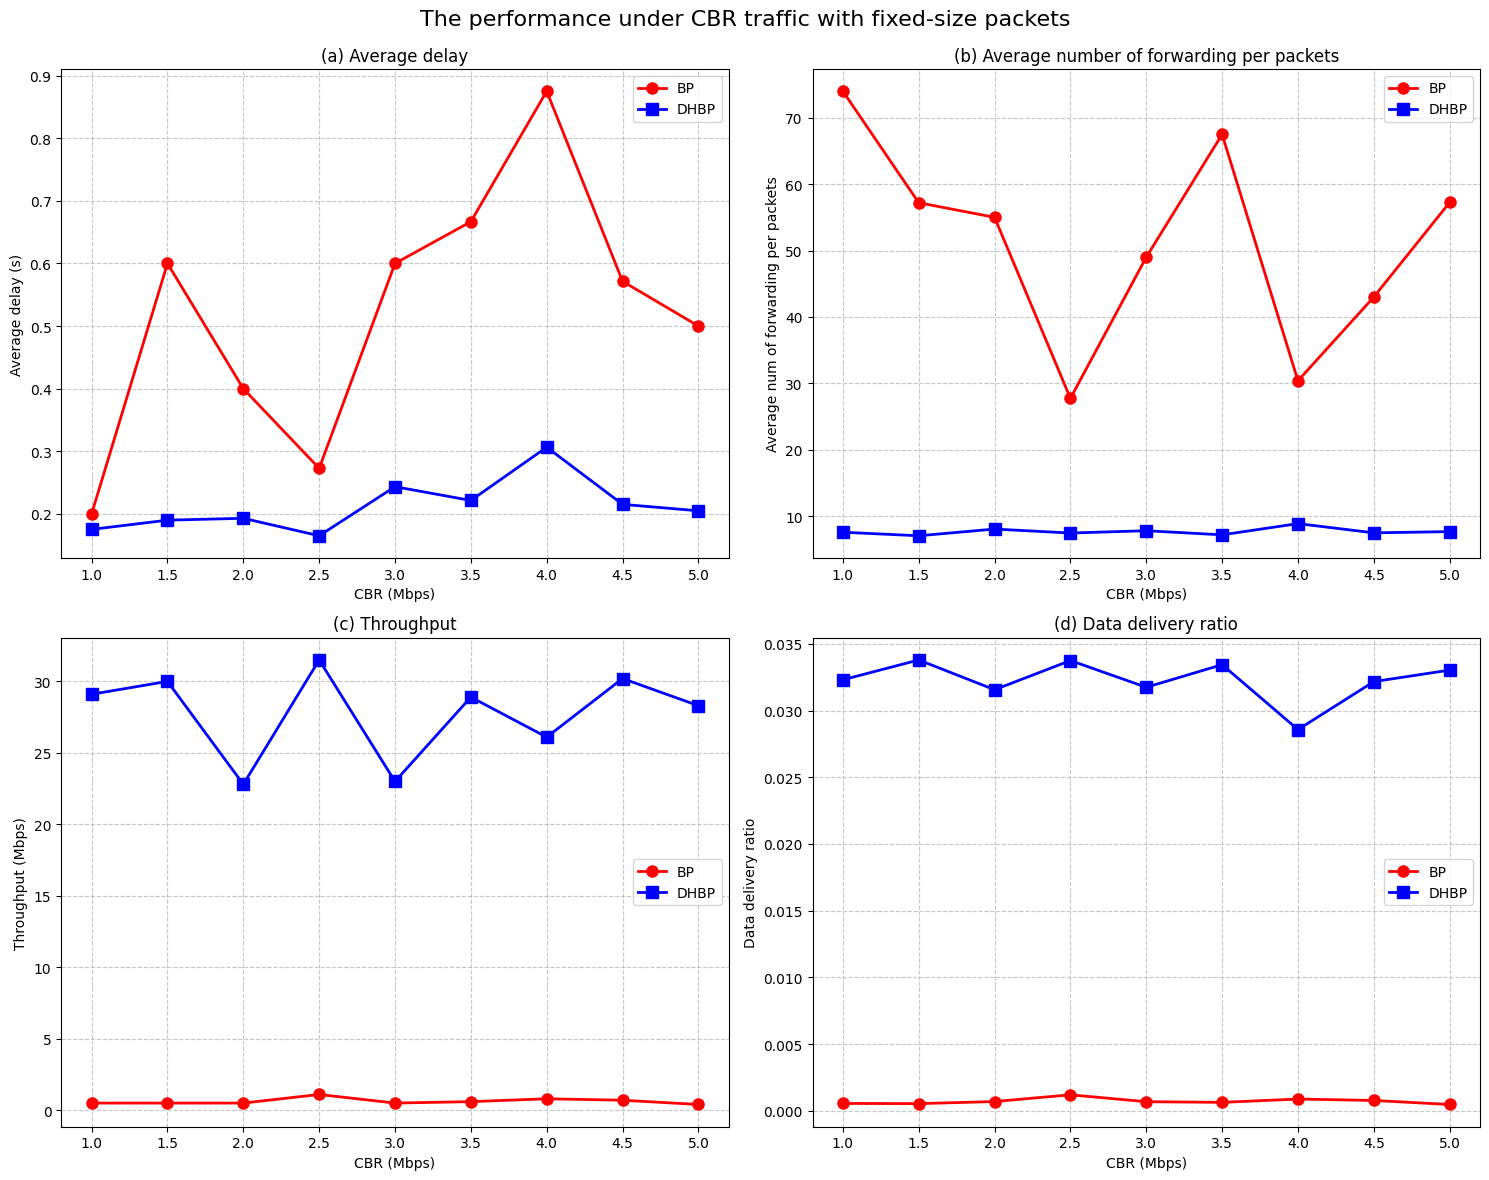

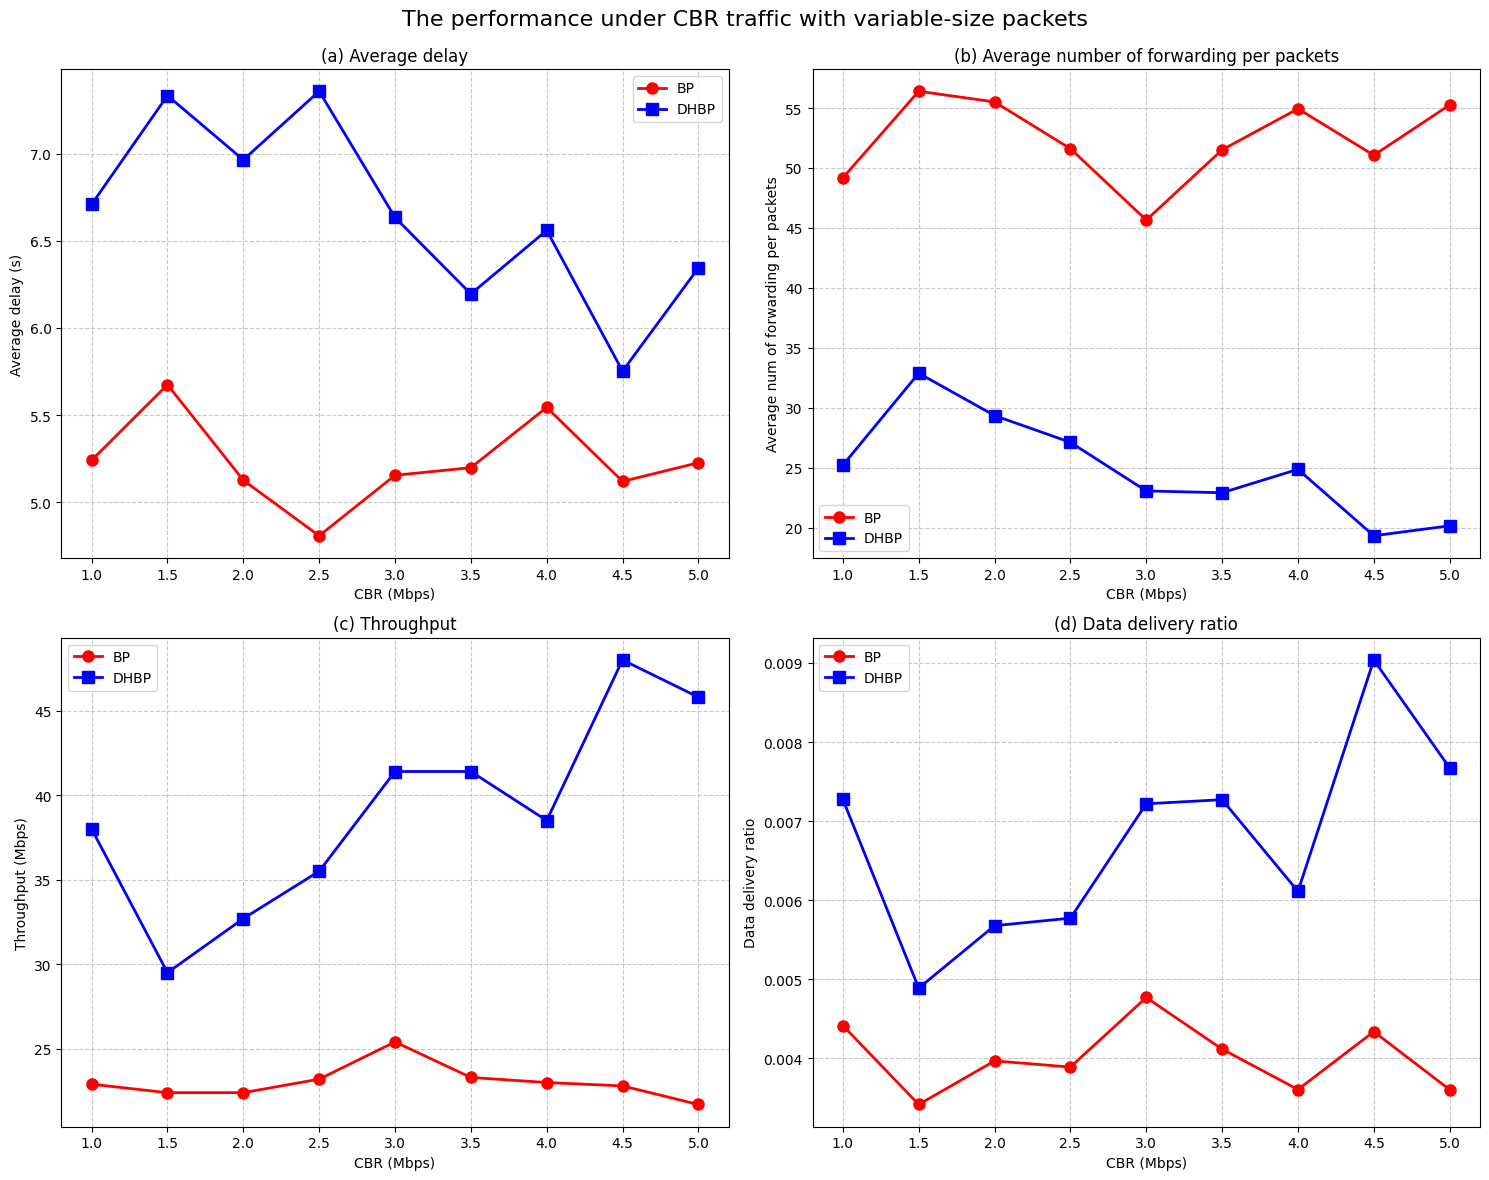

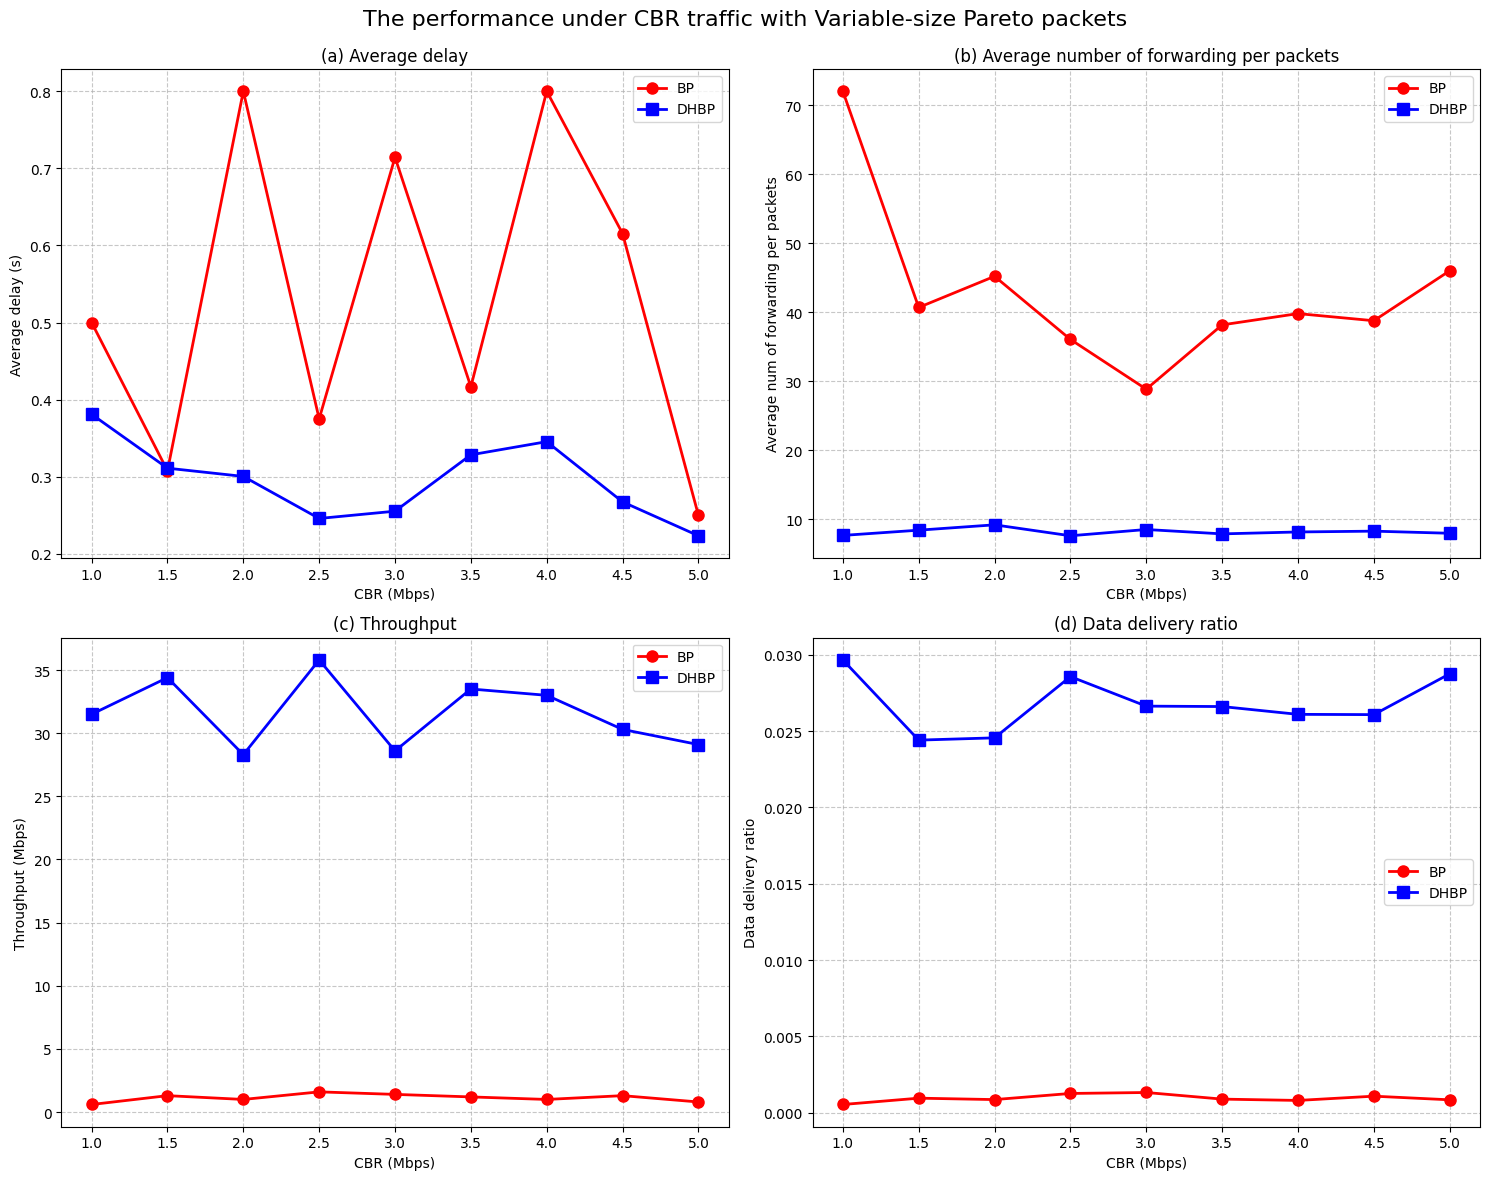

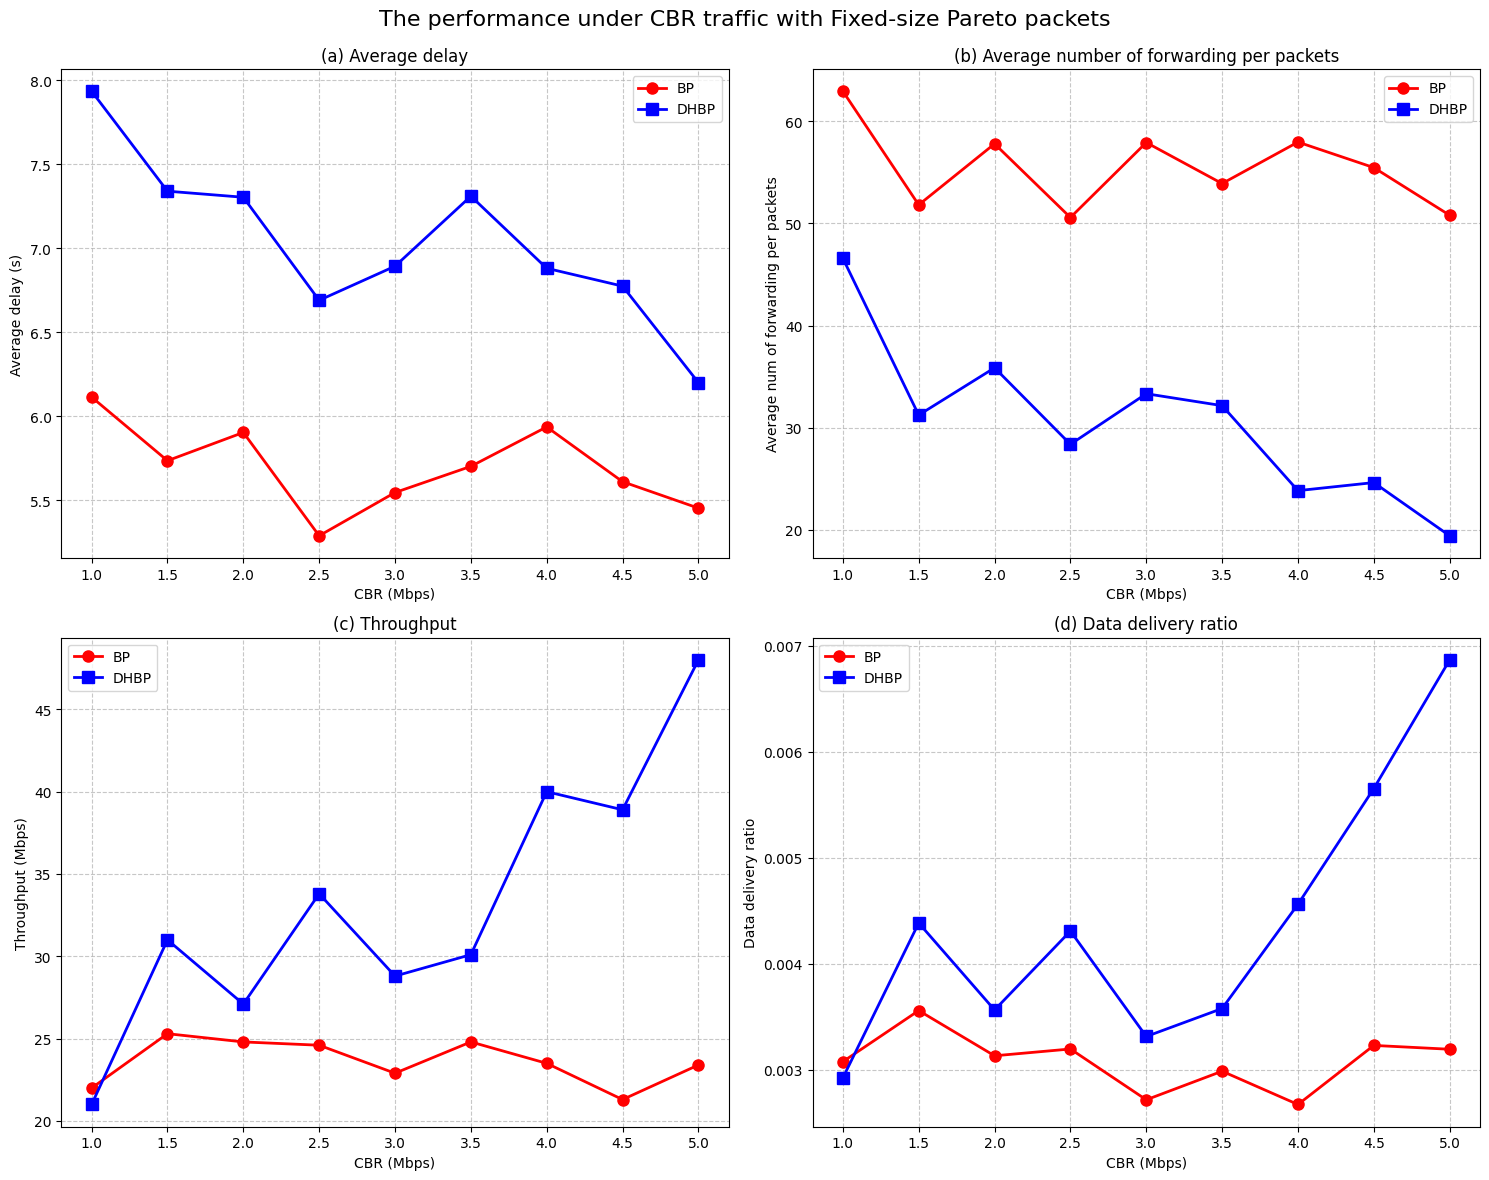

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from basepaper_with_sgp4_and_broadcast import LEOSatelliteNetwork
import random
import pandas as pd
import seaborn as sns

def run_comparison_with_increasing_traffic(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run a comparison between BP and DHBP with increasing traffic rates"""
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)  # Random target node
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running simulation with traffic rate: {rate} Mbps")

        # Create two identical networks
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        # Set the target node for both networks
        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        # Initialize orbital parameters for realistic hop calculation
        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # Set base traffic rate for all satellites
        for sat in bp_network.satellites:
            # Set shape and scale parameters to control traffic pattern
            sat.shape = random.uniform(1.0, 5.0)  # Pareto shape parameter
            sat.scale = rate  # Use the traffic rate as the scale parameter

        for sat in dhbp_network.satellites:
            # Use the same shape and scale for fair comparison
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second (10 timeslots/second)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def plot_comparison_results(results, packet_type="Variable-size", save_fig=True):
    """Plot comparison graphs similar to the research paper"""
    # Convert results to DataFrame for easier manipulation
    df = pd.DataFrame(results)

    # Create a figure with 4 subplots in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Set custom colors and markers
    bp_style = {'color': 'red', 'marker': 'o', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}
    dhbp_style = {'color': 'blue', 'marker': 's', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}

    # Plot 1: Average Delay
    bp_data = df[df['algorithm'] == 'BP']
    dhbp_data = df[df['algorithm'] == 'DHBP']

    axes[0, 0].plot(bp_data['traffic_rate'], bp_data['avg_delay'], **bp_style, label='BP')
    axes[0, 0].plot(dhbp_data['traffic_rate'], dhbp_data['avg_delay'], **dhbp_style, label='DHBP')
    axes[0, 0].set_xlabel('CBR (Mbps)')
    axes[0, 0].set_ylabel('Average delay (s)')
    axes[0, 0].set_title('(a) Average delay')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Average number of forwarding per packets
    axes[0, 1].plot(bp_data['traffic_rate'], bp_data['avg_forwarding'], **bp_style, label='BP')
    axes[0, 1].plot(dhbp_data['traffic_rate'], dhbp_data['avg_forwarding'], **dhbp_style, label='DHBP')
    axes[0, 1].set_xlabel('CBR (Mbps)')
    axes[0, 1].set_ylabel('Average num of forwarding per packets')
    axes[0, 1].set_title('(b) Average number of forwarding per packets')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Throughput
    axes[1, 0].plot(bp_data['traffic_rate'], bp_data['throughput'], **bp_style, label='BP')
    axes[1, 0].plot(dhbp_data['traffic_rate'], dhbp_data['throughput'], **dhbp_style, label='DHBP')
    axes[1, 0].set_xlabel('CBR (Mbps)')
    axes[1, 0].set_ylabel('Throughput (Mbps)')
    axes[1, 0].set_title('(c) Throughput')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Data delivery ratio
    axes[1, 1].plot(bp_data['traffic_rate'], bp_data['delivery_ratio'], **bp_style, label='BP')
    axes[1, 1].plot(dhbp_data['traffic_rate'], dhbp_data['delivery_ratio'], **dhbp_style, label='DHBP')
    axes[1, 1].set_xlabel('CBR (Mbps)')
    axes[1, 1].set_ylabel('Data delivery ratio')
    axes[1, 1].set_title('(d) Data delivery ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Set overall title
    fig.suptitle(f'The performance under CBR traffic with {packet_type} packets', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    if save_fig:
        plt.savefig(f"bp_dhbp_comparison_{packet_type.lower().replace('-', '_')}.png", dpi=300, bbox_inches='tight')

    return fig


def run_pareto_comparison(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run comparison with Pareto traffic distribution"""
    # Similar to the constant bit rate function but using Pareto distribution
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running Pareto simulation with base traffic rate: {rate} Mbps")

        # Create networks with identical initial settings
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # For Pareto distribution, ensure the shape parameters are set
        for sat in bp_network.satellites:
            # Shape controls the heaviness of the tail - lower values mean more burstiness
            sat.shape = random.uniform(1.0, 7.0)  # More bursty traffic with heavier tails
            sat.scale = rate  # Base rate

        # Ensure DHBP network has the same parameters
        for sat in dhbp_network.satellites:
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def main():
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Parameters for the comparison
    rows = 4
    cols = 5
    steps = 100  # Number of simulation steps
    traffic_rates = np.arange(1.0, 5.1, 0.5)  # From 1.0 to 5.0 Mbps with 0.5 increments

    # Run with variable packet sizes
    print("Running comparison with fixed-size packets and constant bit rate...")
    cbr_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot variable packet size results
    plot_comparison_results(cbr_results, "fixed-size")

    # Run with fixed packet sizes
    print("Running comparison with variable-size packets and constant bit rate...")
    cbr_fixed_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot fixed packet size results
    plot_comparison_results(cbr_fixed_results, "variable-size")

    # Run with Pareto traffic distribution and variable packet sizes
    print("Running comparison with variable-size packets and Pareto traffic...")
    pareto_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot Pareto with variable packet size results
    plot_comparison_results(pareto_results, "Variable-size Pareto", save_fig=True)

    # Run with Pareto traffic distribution and fixed packet sizes
    print("Running comparison with fixed-size packets and Pareto traffic...")
    pareto_fixed_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot Pareto with fixed packet size results
    plot_comparison_results(pareto_fixed_results, "Fixed-size Pareto", save_fig=True)

    print("All simulations and plots complete.")
    plt.show()


if __name__ == "__main__":
    main()

Base_paper_with_braodcast_analyser


=== Running Variable-Size Packet Comparison ===
Target node selected: 4

--- Running with traffic rate: 1.0 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 1.5 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.0 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.5 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running

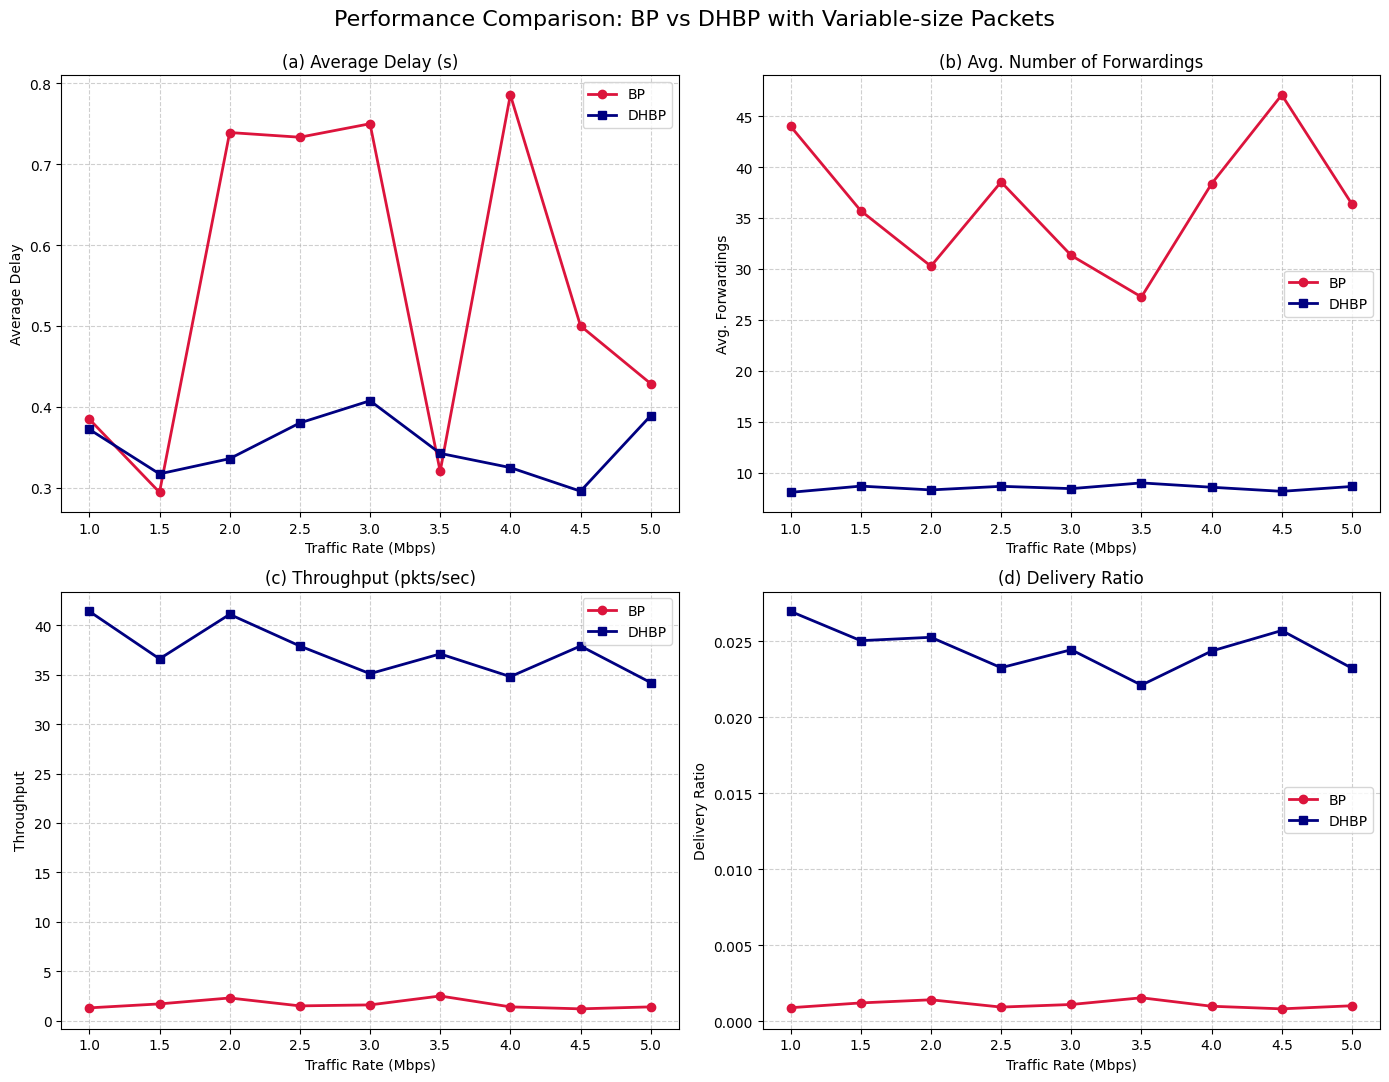

=== Running Fixed-Size Packet Comparison ===
Target node selected: 7

--- Running with traffic rate: 1.0 Mbps ---
Target node set to Satellite 7
Target node set to Satellite 7
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 1.5 Mbps ---
Target node set to Satellite 7
Target node set to Satellite 7
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.0 Mbps ---
Target node set to Satellite 7
Target node set to Satellite 7
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.5 Mbps ---
Target node set to Satellite 7
Target node set to Satellite 7
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running wi

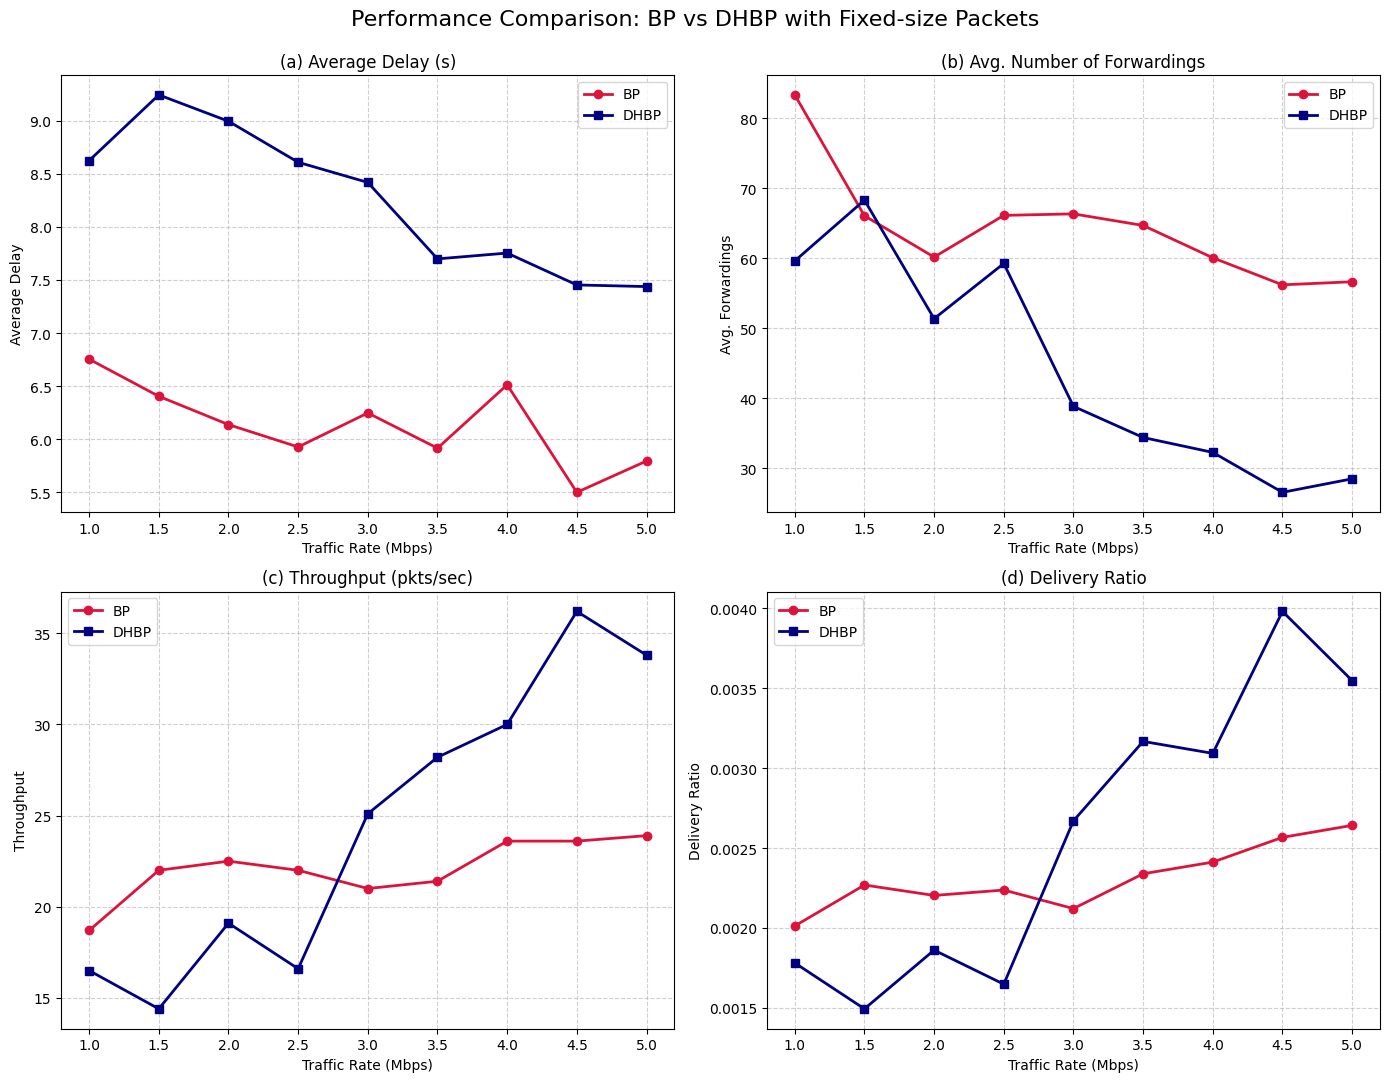

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from basepaper_with_sgp4_and_broadcast import LEOSatelliteNetwork  # Your final integrated file
import random
import pandas as pd
import seaborn as sns

def run_comparison(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)
    print(f"Target node selected: {target_node}")

    for rate in traffic_rates:
        print(f"\n--- Running with traffic rate: {rate} Mbps ---")

        bp_net = LEOSatelliteNetwork(rows, cols)
        dhbp_net = LEOSatelliteNetwork(rows, cols)

        bp_net.set_target_node(target_node)
        dhbp_net.set_target_node(target_node)

        bp_net.initialize_orbital_parameters()
        dhbp_net.initialize_orbital_parameters()

        for i, sat in enumerate(bp_net.satellites):
            sat.shape = random.uniform(3.0, 7.0)
            sat.scale = rate

        for i, sat in enumerate(dhbp_net.satellites):
            ref = bp_net.satellites[i]
            sat.shape = ref.shape
            sat.scale = ref.scale

        # Simulate
        bp_net.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_net.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Metrics
        def collect_stats(network, label):
            delivered = network.simulation_stats['delivered_packets']
            dropped = network.simulation_stats['dropped_packets']
            avg_delay = network.simulation_stats['avg_delay']
            throughput = delivered / steps * 10
            delivery_ratio = delivered / max(1, delivered + dropped)
            forwarding = sum(s.packets_forwarded for s in network.satellites) / max(1, delivered)

            results['traffic_rate'].append(rate)
            results['algorithm'].append(label)
            results['delivered_packets'].append(delivered)
            results['dropped_packets'].append(dropped)
            results['avg_delay'].append(avg_delay)
            results['throughput'].append(throughput)
            results['delivery_ratio'].append(delivery_ratio)
            results['avg_forwarding'].append(forwarding)

        collect_stats(bp_net, 'BP')
        collect_stats(dhbp_net, 'DHBP')

    return results


def plot_results(results, label="Variable-size"):
    df = pd.DataFrame(results)

    fig, axes = plt.subplots(2, 2, figsize=(14, 11))
    bp_style = {'color': 'crimson', 'marker': 'o', 'linewidth': 2, 'linestyle': '-'}
    dhbp_style = {'color': 'navy', 'marker': 's', 'linewidth': 2, 'linestyle': '-'}

    metrics = [
        ("avg_delay", "(a) Average Delay (s)", "Average Delay"),
        ("avg_forwarding", "(b) Avg. Number of Forwardings", "Avg. Forwardings"),
        ("throughput", "(c) Throughput (pkts/sec)", "Throughput"),
        ("delivery_ratio", "(d) Delivery Ratio", "Delivery Ratio")
    ]

    for ax, (metric, title, ylabel) in zip(axes.flat, metrics):
        for alg, style in zip(['BP', 'DHBP'], [bp_style, dhbp_style]):
            data = df[df['algorithm'] == alg]
            ax.plot(data['traffic_rate'], data[metric], label=alg, **style)
        ax.set_title(title)
        ax.set_xlabel("Traffic Rate (Mbps)")
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle(f"Performance Comparison: BP vs DHBP with {label} Packets", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f"bp_vs_dhbp_{label.lower().replace(' ', '_')}.png", dpi=300)
    plt.show()


def main():
    np.random.seed(42)
    random.seed(42)

    steps = 100
    rates = np.arange(1.0, 5.1, 0.5)

    print("=== Running Variable-Size Packet Comparison ===")
    results_var = run_comparison(steps=steps, traffic_rates=rates, use_fixed_size=False)
    plot_results(results_var, label="Variable-size")

    print("=== Running Fixed-Size Packet Comparison ===")
    results_fixed = run_comparison(steps=steps, traffic_rates=rates, use_fixed_size=True)
    plot_results(results_fixed, label="Fixed-size")


if __name__ == "__main__":
    main()


Base_paper_analyser

=== Running Variable-Size Packet Comparison ===
Target node selected: 4

--- Running with traffic rate: 1.0 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 1.5 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.0 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.5 Mbps ---
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running

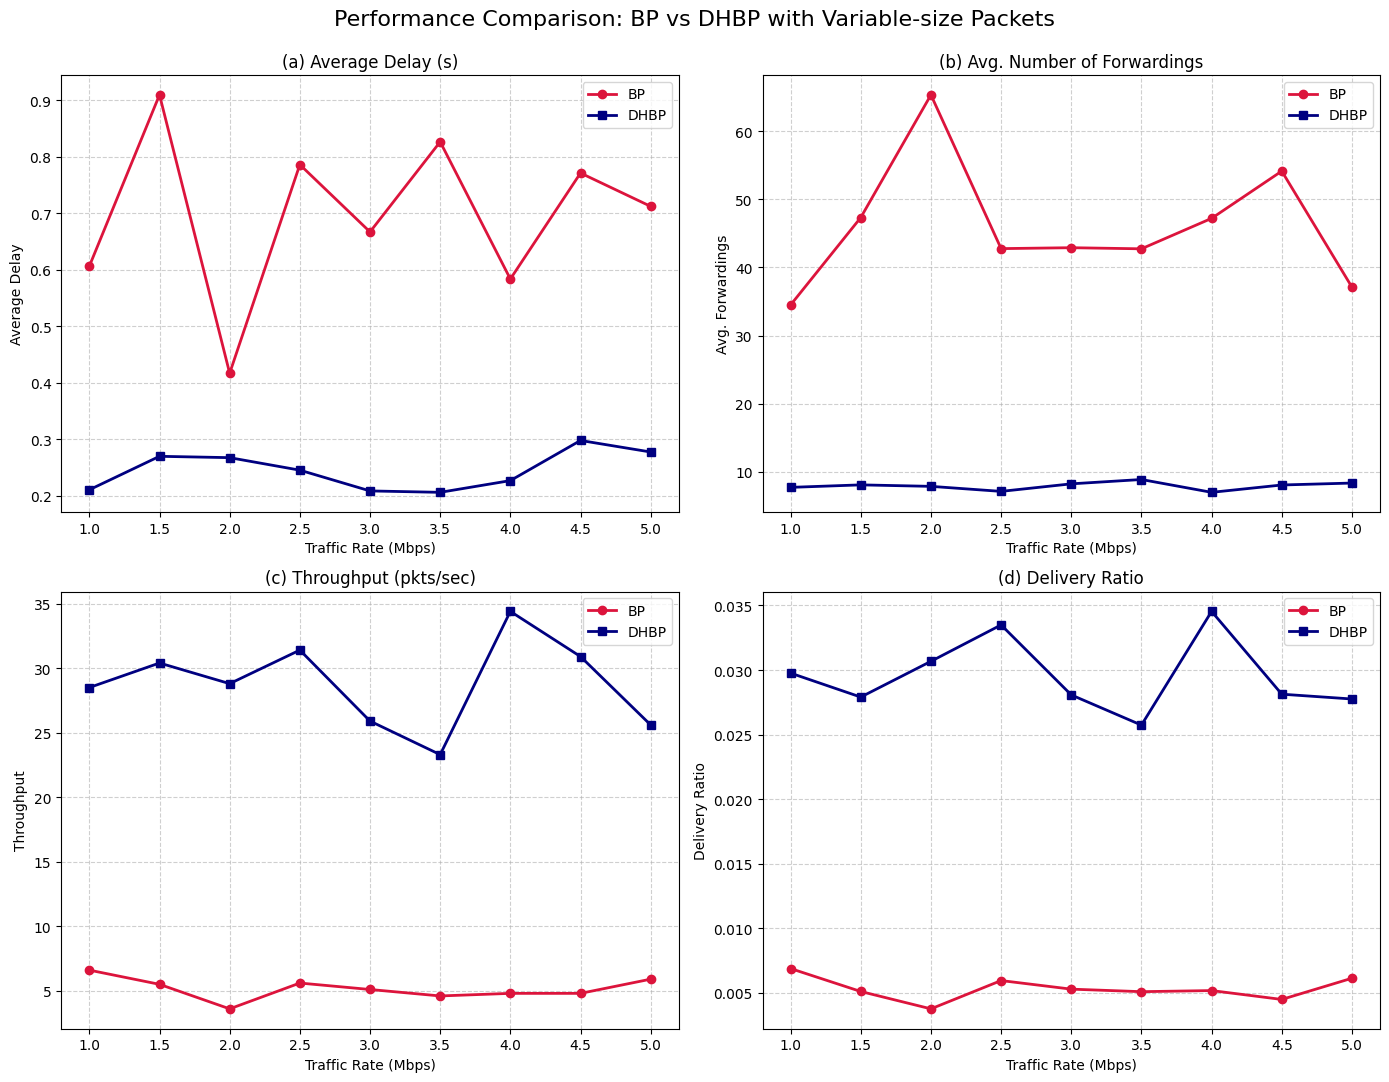

=== Running Fixed-Size Packet Comparison ===
Target node selected: 3

--- Running with traffic rate: 1.0 Mbps ---
Target node set to Satellite 3
Target node set to Satellite 3
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 1.5 Mbps ---
Target node set to Satellite 3
Target node set to Satellite 3
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.0 Mbps ---
Target node set to Satellite 3
Target node set to Satellite 3
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running with traffic rate: 2.5 Mbps ---
Target node set to Satellite 3
Target node set to Satellite 3
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation

--- Running wi

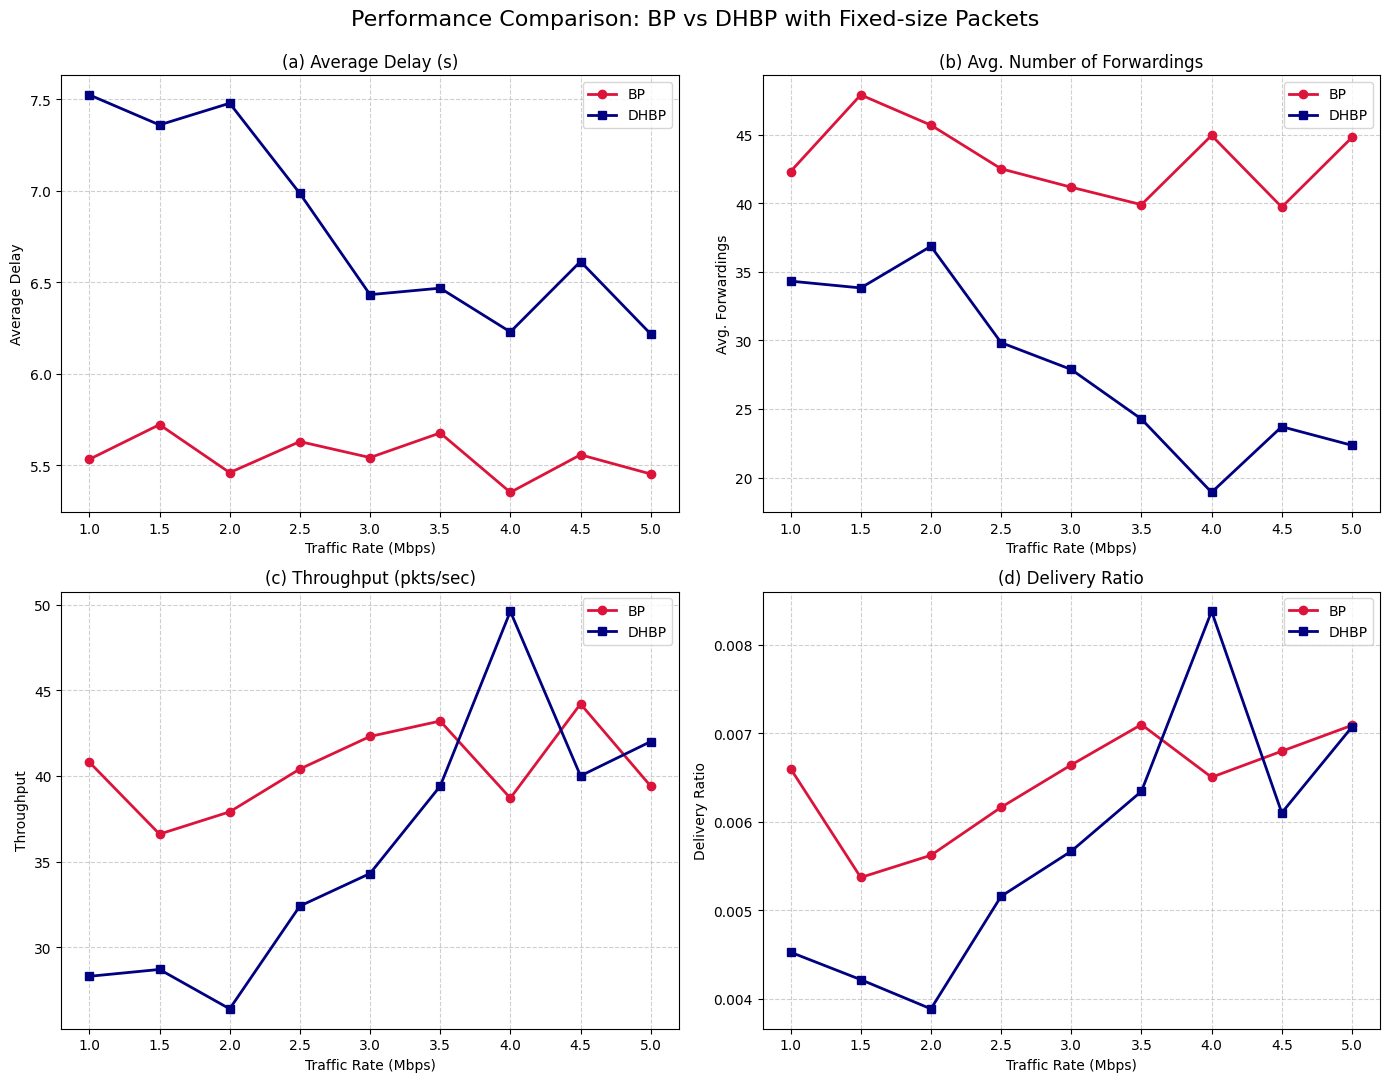

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from new1 import LEOSatelliteNetwork  # Your final integrated file
import random
import pandas as pd
import seaborn as sns

def run_comparison(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)
    print(f"Target node selected: {target_node}")

    for rate in traffic_rates:
        print(f"\n--- Running with traffic rate: {rate} Mbps ---")

        bp_net = LEOSatelliteNetwork(rows, cols)
        dhbp_net = LEOSatelliteNetwork(rows, cols)

        bp_net.set_target_node(target_node)
        dhbp_net.set_target_node(target_node)

        bp_net.initialize_orbital_parameters()
        dhbp_net.initialize_orbital_parameters()

        for i, sat in enumerate(bp_net.satellites):
            sat.shape = random.uniform(1.0, 5.0)
            sat.scale = rate

        for i, sat in enumerate(dhbp_net.satellites):
            ref = bp_net.satellites[i]
            sat.shape = ref.shape
            sat.scale = ref.scale

        # Simulate
        bp_net.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_net.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Metrics
        def collect_stats(network, label):
            delivered = network.simulation_stats['delivered_packets']
            dropped = network.simulation_stats['dropped_packets']
            avg_delay = network.simulation_stats['avg_delay']
            throughput = delivered / steps * 10
            delivery_ratio = delivered / max(1, delivered + dropped)
            forwarding = sum(s.packets_forwarded for s in network.satellites) / max(1, delivered)

            results['traffic_rate'].append(rate)
            results['algorithm'].append(label)
            results['delivered_packets'].append(delivered)
            results['dropped_packets'].append(dropped)
            results['avg_delay'].append(avg_delay)
            results['throughput'].append(throughput)
            results['delivery_ratio'].append(delivery_ratio)
            results['avg_forwarding'].append(forwarding)

        collect_stats(bp_net, 'BP')
        collect_stats(dhbp_net, 'DHBP')

    return results


def plot_results(results, label="Variable-size"):
    df = pd.DataFrame(results)

    fig, axes = plt.subplots(2, 2, figsize=(14, 11))
    bp_style = {'color': 'crimson', 'marker': 'o', 'linewidth': 2, 'linestyle': '-'}
    dhbp_style = {'color': 'navy', 'marker': 's', 'linewidth': 2, 'linestyle': '-'}

    metrics = [
        ("avg_delay", "(a) Average Delay (s)", "Average Delay"),
        ("avg_forwarding", "(b) Avg. Number of Forwardings", "Avg. Forwardings"),
        ("throughput", "(c) Throughput (pkts/sec)", "Throughput"),
        ("delivery_ratio", "(d) Delivery Ratio", "Delivery Ratio")
    ]

    for ax, (metric, title, ylabel) in zip(axes.flat, metrics):
        for alg, style in zip(['BP', 'DHBP'], [bp_style, dhbp_style]):
            data = df[df['algorithm'] == alg]
            ax.plot(data['traffic_rate'], data[metric], label=alg, **style)
        ax.set_title(title)
        ax.set_xlabel("Traffic Rate (Mbps)")
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.6)

    fig.suptitle(f"Performance Comparison: BP vs DHBP with {label} Packets", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.savefig(f"bp_vs_dhbp_{label.lower().replace(' ', '_')}.png", dpi=300)
    plt.show()


def main():
    np.random.seed(42)
    random.seed(42)

    steps = 100
    rates = np.arange(1.0, 5.1, 0.5)

    print("=== Running Variable-Size Packet Comparison ===")
    results_var = run_comparison(steps=steps, traffic_rates=rates, use_fixed_size=False)
    plot_results(results_var, label="Variable-size")

    print("=== Running Fixed-Size Packet Comparison ===")
    results_fixed = run_comparison(steps=steps, traffic_rates=rates, use_fixed_size=True)
    plot_results(results_fixed, label="Fixed-size")


if __name__ == "__main__":
    main()


Base paper with Broadcast with SGP4

Orbital parameters initialized for realistic hop calculation
Error loading TLE data: [Errno 2] No such file or directory: './STARLINK-tle.txt'
Target node set to Satellite 20
Running simulation with fixed-size packets...
Generating visualizations...


<ipython-input-21-743525f5a92a>:1134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Running simulation with variable-size packets...
Target node set to Satellite 20
Fixed-size packets delivered: 378
Variable-size packets delivered: 534
Fixed-size packets average delay: 6.158730158730159
Variable-size packets average delay: 4.917602996254682


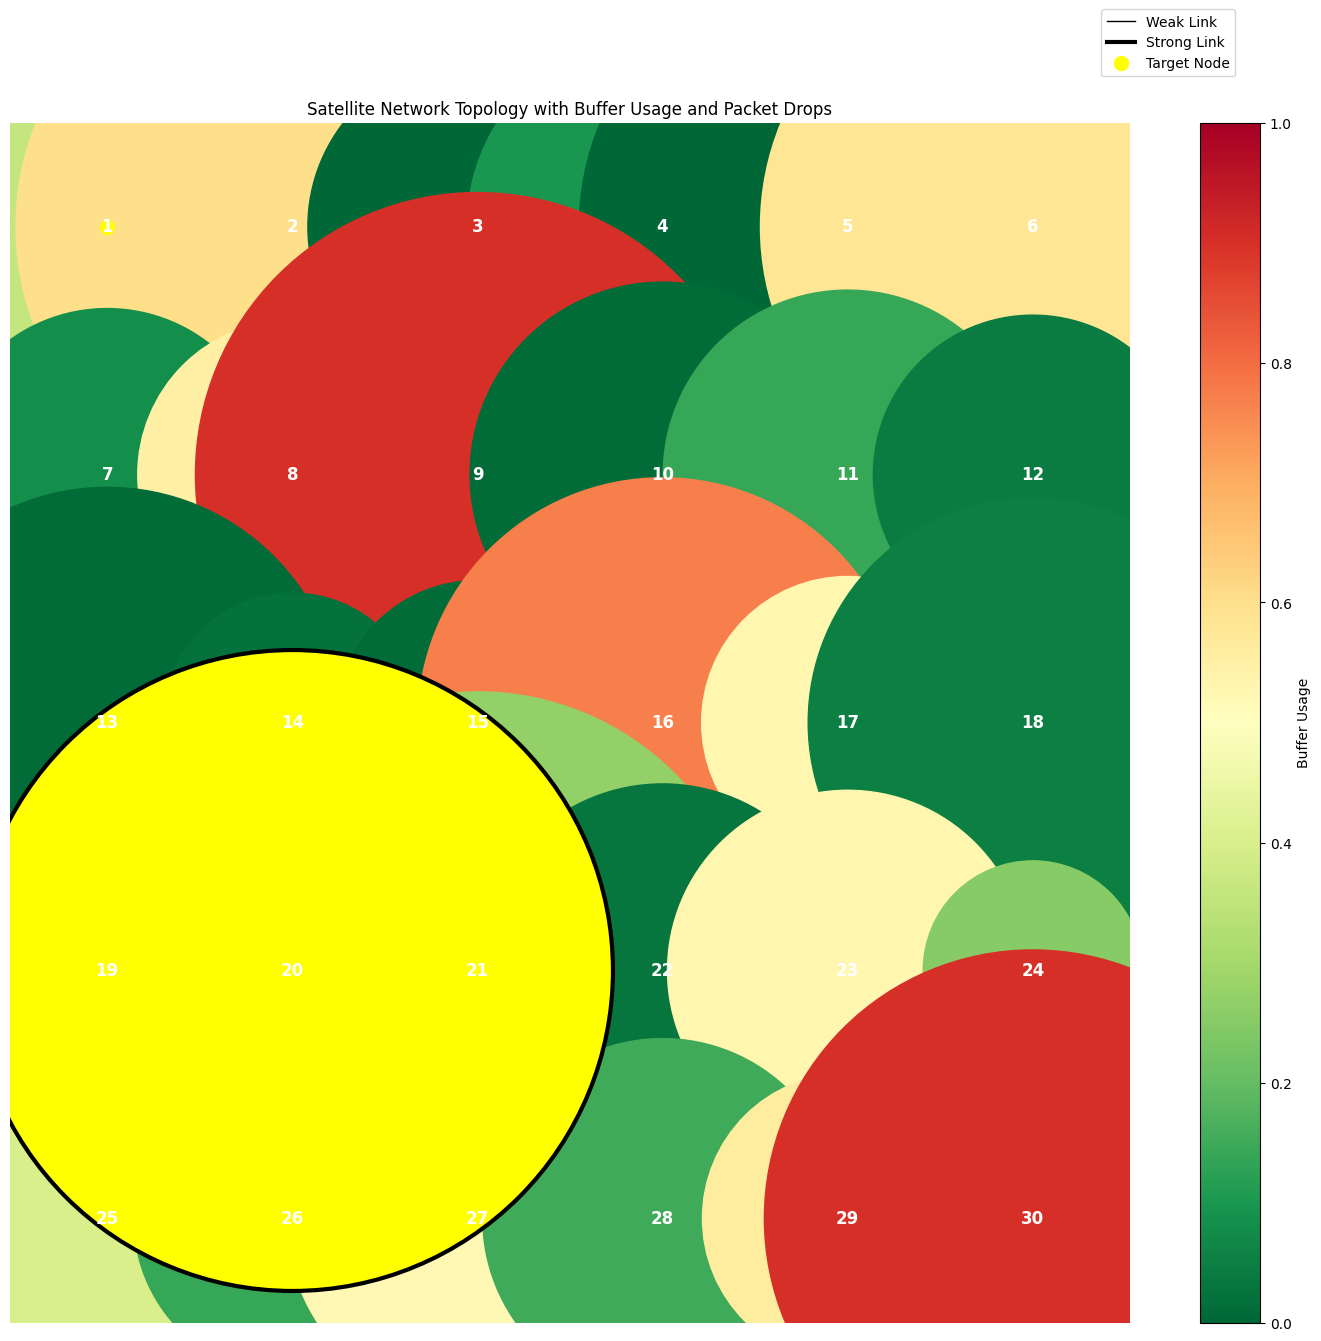

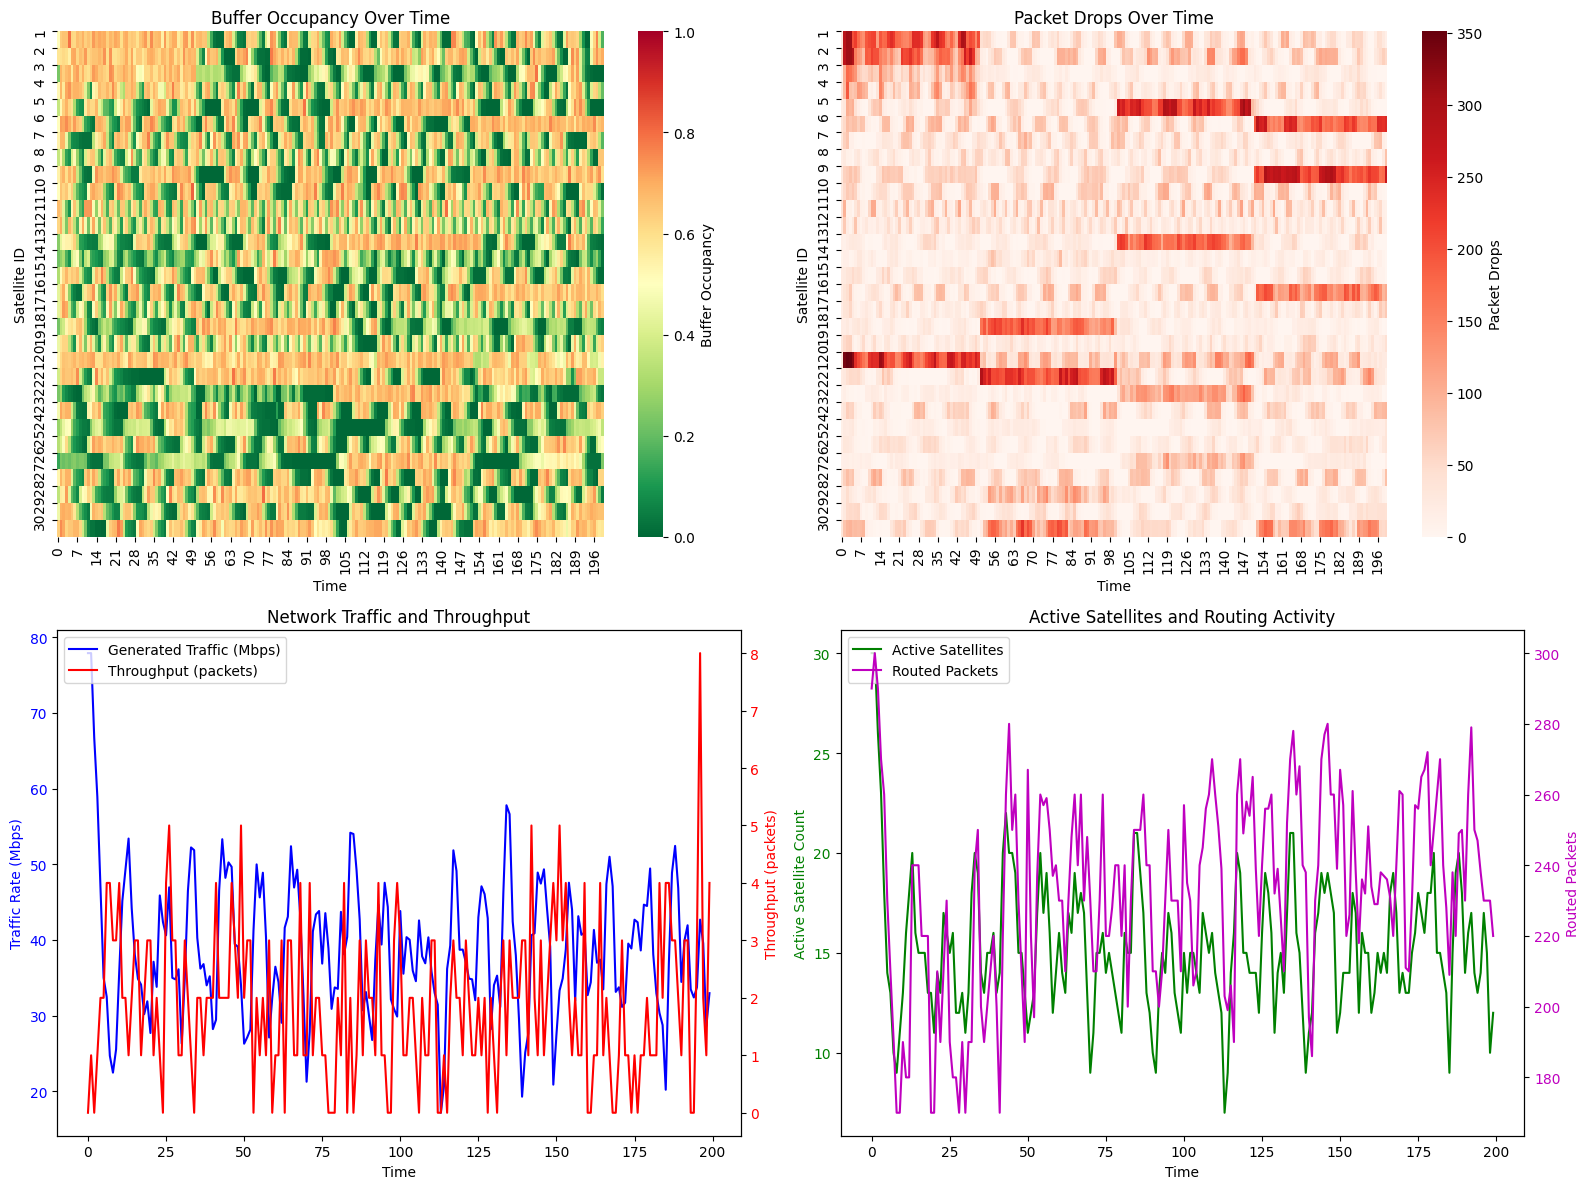

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
import networkx as nx
from collections import deque
import time
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sgp4.earth_gravity import wgs72
from sgp4.io import twoline2rv
import datetime
import math

class Packet:
    """Class representing a network packet"""
    next_id = 1

    def __init__(self, source, destination, size, creation_time):
        self.id = Packet.next_id
        Packet.next_id += 1
        self.source = source
        self.destination = destination
        self.size = size  # in KB
        self.creation_time = creation_time
        self.current_location = source
        self.hops = 0
        self.delay = 0
        self.dropped = False
        self.delivered = False

    def __repr__(self):
        return f"Packet({self.id}: {self.source}->{self.destination}, size={self.size:.1f}KB)"

class LEOSatellite:
    def __init__(self, id, position, altitude=500):
        self.id = id
        self.position = position  # (row, col)
        self.altitude = altitude  # km
        self.active = False
        self.traffic_rate = 0  # Mbps

        # Queue for packet storage
        self.buffer_capacity = 50  # KB (max buffer size)
        self.used_buffer = 0  # KB currently used
        self.queue = deque()
        self.queue_history = []
        self.buffer_occupancy_history = []
        self.drop_count = 0
        self.drop_history = []

        # Link properties
        self.link_capacity = 1  # Mbps
        self.link_utilization = 0
        self.link_utilization_history = []

        # Channel properties
        self.bit_error_rate = 0.0001  # Probability of bit error
        self.propagation_delay = 2  # ms

        # Pareto distribution parameters
        self.shape = random.uniform(1.5, 5.0)
        self.scale = random.uniform(1.0, 5.0)

        # On-Off timers
        self.on_duration = 0
        self.off_duration = 0
        self.time_left = 0

        # Traffic history
        self.traffic_history = []

        # Routing-related attributes
        self.neighbors = []  # Initialize neighbors list
        self.routing_table = {}
        self.backpressure_weights = {}

        # DHBP-specific attributes
        self.dhd_estimates = {}  # Destination-Hops-Delay estimates
        self.virtual_dhd_queues = {}  # Virtual DHD queues
        self.permitted_regions = {}  # Permitted propagation regions
        self.max_neighbors = 4  # Typical ISL count

        # Statistics
        self.packets_received = 0
        self.packets_forwarded = 0
        self.packets_delivered = 0
        self.packets_dropped = 0
        self.total_delay = 0

        self.neighbors_queue_info = {}
        self.broadcast_interval = 50
        self.last_broadcast = 0
        self.broadcast_range = 1
        self.broadcast_ttl = 1



# Add these methods to the LEOSatellite class
    def set_mobility_model(self, tle_line1, tle_line2):
        """Initialize SGP4 propagator using TLE data"""
        self.tle_line1 = tle_line1
        self.tle_line2 = tle_line2

        # Create SGP4 satellite object
        self.sgp4_satellite = twoline2rv(tle_line1, tle_line2, wgs72)

        # Store initial time (use epoch from TLE as starting point)
        self.initial_time = self.sgp4_satellite.epoch

        # Store initial position
        position, velocity = self.sgp4_satellite.propagate(
            self.sgp4_satellite.epoch.year,
            self.sgp4_satellite.epoch.month,
            self.sgp4_satellite.epoch.day,
            self.sgp4_satellite.epoch.hour,
            self.sgp4_satellite.epoch.minute,
            self.sgp4_satellite.epoch.second
        )

        self.physical_position = position  # (x, y, z) in km
        self.velocity = velocity  # (vx, vy, vz) in km/s

        return True

    def update_position(self, simulation_time):

        if not hasattr(self, 'sgp4_satellite'):
            # No mobility model set
            return None


        current_datetime = self.initial_time + datetime.timedelta(seconds=simulation_time)

        # Extract datetime components
        year = current_datetime.year
        month = current_datetime.month
        day = current_datetime.day
        hour = current_datetime.hour
        minute = current_datetime.minute
        second = current_datetime.second + current_datetime.microsecond / 1000000.0

        # Propagate satellite to new position
        position, velocity = self.sgp4_satellite.propagate(year, month, day, hour, minute, second)

        # Update satellite position and velocity
        self.physical_position = position
        self.velocity = velocity



        return position

    # Add this method to calculate distance between satellites
    def calculate_distance_to(self, other_satellite):

        if (not hasattr(self, 'physical_position') or
            not hasattr(other_satellite, 'physical_position')):
            # Fall back to grid-based distance if physical positions aren't available
            dx = abs(self.position[0] - other_satellite.position[0])
            dy = abs(self.position[1] - other_satellite.position[1])
            return math.sqrt(dx**2 + dy**2)

        # Calculate Euclidean distance in 3D space
        dx = self.physical_position[0] - other_satellite.physical_position[0]
        dy = self.physical_position[1] - other_satellite.physical_position[1]
        dz = self.physical_position[2] - other_satellite.physical_position[2]

        return math.sqrt(dx**2 + dy**2 + dz**2)

    def broadcast_queue_info(self, current_time):
        """Broadcast queue information to neighbors with realistic behavior"""
        if current_time - self.last_broadcast >= self.broadcast_interval:
            self.last_broadcast = current_time

            # Create queue information packet
            queue_info = {
                'queue_length': len(self.queue),
                'buffer_usage': self.used_buffer / self.buffer_capacity,
                'timestamp': current_time,
                'source_id': self.id,
                'ttl': self.broadcast_ttl
            }

            # Add our own information immediately (no delay or loss)
            self.neighbors_queue_info[self.id] = queue_info.copy()

            # Send to each neighbor with possible loss
            for neighbor in self.neighbors:
                # Simulate packet loss based on link quality
                link_quality = 1 - neighbor.bit_error_rate
                if random.random() < link_quality:  # Probability of successful transmission
                    neighbor.receive_queue_info(queue_info.copy())
                # If random value > link_quality, the broadcast is lost to this neighbor

            return True
        return False



    def receive_queue_info(self, queue_info):
        """Receive queue information with realistic delay"""
        source_id = queue_info['source_id']
        timestamp = queue_info['timestamp']

        # Calculate realistic propagation delay based on distance
        source_sat = self.network.get_satellite_by_id(source_id)
        if source_sat:
            distance = self.calculate_distance_to(source_sat)
            # Propagation delay: distance / speed of light (roughly 300,000 km/s)
            # Convert to simulation time units
            prop_delay = distance / 300  # Simplified delay calculation
        else:
            # Default delay if we can't calculate
            prop_delay = random.uniform(1, 5)  # Random delay between 1-5 time units

        # Add jitter to simulate network variability
        jitter = random.uniform(-0.5, 0.5)
        total_delay = max(1, prop_delay + jitter)

        # Calculate when this information will arrive
        arrival_time = timestamp + total_delay

        # Store the information with arrival time
        self.neighbors_queue_info[source_id] = {
            'queue_length': queue_info['queue_length'],
            'buffer_usage': queue_info['buffer_usage'],
            'timestamp': timestamp,
            'source_id': source_id,
            'ttl': queue_info['ttl'],
            'arrival_time': arrival_time,
            'prop_delay': total_delay
        }

        # Only propagate if TTL allows and we're not the source
        if queue_info['ttl'] > 1 and source_id != self.id:
            # Create propagated version with reduced TTL
            propagated_info = queue_info.copy()
            propagated_info['ttl'] = queue_info['ttl'] - 1

            # Add some processing delay before propagation
            processing_delay = random.uniform(0.2, 0.5)

            # Only propagate to neighbors that aren't the source
            # Simulate packet loss in propagation
            for neighbor in self.neighbors:
                if neighbor.id != source_id:
                    # Higher loss probability for propagated messages
                    if random.random() < 0.8:  # 80% chance of successful propagation
                        neighbor.receive_queue_info(propagated_info)



    def clean_stale_queue_info(self, current_time):
        """Remove stale queue information"""
        stale_ids = []
        for sat_id, info in self.neighbors_queue_info.items():
            # Information is stale if it's older than 3 broadcast intervals
            if current_time - info['timestamp'] > self.broadcast_interval * 3:
                stale_ids.append(sat_id)

        for sid in stale_ids:
            self.neighbors_queue_info.pop(sid, None)



    def calculate_permitted_region(self, source_id, dest_id):
        """Calculate rectangular permitted region between source and destination"""
        source = self.network.get_satellite_by_id(source_id)
        dest = self.network.get_satellite_by_id(dest_id)

        # Get grid coordinates
        min_row = min(source.position[0], dest.position[0])
        max_row = max(source.position[0], dest.position[0])
        min_col = min(source.position[1], dest.position[1])
        max_col = max(source.position[1], dest.position[1])

        self.permitted_regions[(source_id, dest_id)] = (min_row, max_row, min_col, max_col)
        return (min_row, max_row, min_col, max_col)

    def is_in_permitted_region(self, node_id, source_id, dest_id):
        """Check if a node is in permitted region for a flow"""
        if (source_id, dest_id) not in self.permitted_regions:
            self.calculate_permitted_region(source_id, dest_id)

        min_row, max_row, min_col, max_col = self.permitted_regions[(source_id, dest_id)]
        node = self.network.get_satellite_by_id(node_id)
        row, col = node.position

        return (min_row <= row <= max_row) and (min_col <= col <= max_col)

            # Modify packet generation to use fixed packet size
    def generate_fixed_size_packets(self, current_time):
        """Generate packets with fixed size of 512 bytes"""
        if self.active:
            # Convert Mbps to KB per timeslot
            kb_per_timeslot = (self.traffic_rate * 1000 / 8) / 10  # Assuming 10 timeslots per second

            # Calculate how many 0.5 KB packets to generate
            packet_size = 0.5  # 512 bytes = 0.5 KB
            num_packets = int(kb_per_timeslot / packet_size)

            # Generate packets
            for _ in range(num_packets):
                # Create packet with random destination
                destination = random.choice([sat_id for sat_id in range(1, len(self.network.satellites) + 1) if sat_id != self.id])
                packet = Packet(self.id, destination, packet_size, current_time)

                # Try to admit packet
                self.admit_packet(packet)

    def update_virtual_dhd_queue(self, packet=None, operation='add'):
        """Update virtual DHD queue for a packet flow"""
        if packet is None:
            return  # Nothing to update

        flow_key = (packet.source, packet.destination)
        h_p = self.calculate_dhd(packet.destination)

        if flow_key not in self.virtual_dhd_queues:
            self.virtual_dhd_queues[flow_key] = 0
            self.calculate_permitted_region(packet.source, packet.destination)

        if operation == 'add':
            self.virtual_dhd_queues[flow_key] += h_p
        elif operation == 'remove':
            self.virtual_dhd_queues[flow_key] = max(0, self.virtual_dhd_queues[flow_key] - h_p)



    def get_valid_next_hops(self, source_id, dest_id):
        """Get neighbors within permitted propagation region"""
        valid_neighbors = []
        for neighbor in self.neighbors:
            if self.is_in_permitted_region(neighbor.id, source_id, dest_id):
                valid_neighbors.append(neighbor)
        return valid_neighbors



    def can_admit_packet(self, packet):
        """Check if packet can be admitted based on buffer capacity"""
        return self.used_buffer + packet.size <= self.buffer_capacity

    def admit_packet(self, packet):
        """Add packet to queue and update virtual DHD queue"""
        if self.can_admit_packet(packet):
            self.queue.append(packet)
            self.used_buffer += packet.size
            packet.current_location = self.id
            self.update_virtual_dhd_queue(packet, 'add')
            return True
        else:
            self.packets_dropped += 1
            packet.dropped = True
            return False

    def remove_packet(self, packet):
        """Remove packet from queue and update virtual DHD queue"""
        if packet in self.queue:
            self.queue.remove(packet)
            self.used_buffer -= packet.size
            self.update_virtual_dhd_queue(packet, 'remove')
            return True
        return False

    def process_bit_errors(self):
        """Process bit errors in the queue, potentially dropping packets"""
        for packet in list(self.queue):

            corruption_probability = 1 - (1 - self.bit_error_rate) ** (packet.size * 8 * 1024)  # Convert KB to bits

            if random.random() < corruption_probability:
                # Packet is corrupted, drop it
                self.remove_packet(packet)
                self.packets_dropped += 1
                packet.dropped = True

    def update(self, current_time, use_fixed_size=False):
        """Update satellite state, generate traffic, and process queue"""
        # Update timer for on-off behavior
        if self.time_left > 0:
            self.time_left -= 1
        else:
            # Switch state when timer reaches zero
            if self.active:
                self.active = False
                # Generate new off duration from Pareto distribution
                self.off_duration = max(1, int(stats.pareto.rvs(b=self.shape, scale=self.scale)))
                self.time_left = self.off_duration
                self.traffic_rate = 0
            else:
                self.active = True
                # Generate new on duration from Pareto distribution
                self.on_duration = max(1, int(stats.pareto.rvs(b=self.shape, scale=self.scale)))
                self.time_left = self.on_duration
                # Generate traffic rate when active (in Mbps)
                self.traffic_rate = random.uniform(0.5, 1.0) * self.shape

        # Generate packets when active
        if self.active:
            if use_fixed_size:
                # Use the fixed-size packet generation method
                self.generate_fixed_size_packets(current_time)
            else:
                # Original packet generation code
                # Convert Mbps to KB per timeslot
                kb_per_timeslot = (self.traffic_rate * 1000 / 8) / 10  # Assuming 10 timeslots per second

                # Generate packets (keeping track of total size)
                total_size = 0
                while total_size < kb_per_timeslot:
                    # Random packet size from 1 to 5 KB
                    packet_size = random.uniform(1, 5)

                    # Check if this would exceed our traffic rate
                    if total_size + packet_size > kb_per_timeslot:
                        break

                    total_size += packet_size

                    # Create packet with random destination
                    destination = random.choice([sat_id for sat_id in range(1, len(self.network.satellites) + 1) if sat_id != self.id])
                    packet = Packet(self.id, destination, packet_size, current_time)

                    # Try to admit packet
                    if not self.admit_packet(packet):
                        # If admission fails, packet is dropped due to buffer overflow
                        pass

        # Process bit errors (may drop packets)
        self.process_bit_errors()

        # Record histories
        self.traffic_history.append(self.traffic_rate)
        self.queue_history.append(len(self.queue))
        self.buffer_occupancy_history.append(self.used_buffer / self.buffer_capacity if self.buffer_capacity > 0 else 0)
        self.drop_history.append(self.packets_dropped)

        if len(self.traffic_history) > 200:
            self.traffic_history = self.traffic_history[-200:]
        if len(self.queue_history) > 200:
            self.queue_history = self.queue_history[-200:]
        if len(self.buffer_occupancy_history) > 200:
            self.buffer_occupancy_history = self.buffer_occupancy_history[-200:]
        if len(self.drop_history) > 200:
            self.drop_history = self.drop_history[-200:]

        return self.traffic_rate



    def calculate_weight(self, neighbor, current_time, congestion_factor=0.8):
        """Calculate backpressure weight with realistic broadcast effects"""
        # Get our own queue occupancy
        my_queue_occupancy = self.used_buffer / self.buffer_capacity

        # Get neighbor queue information (with realistic effects)
        neighbor_info = self.neighbors_queue_info.get(neighbor.id)
        if neighbor_info:
            info_age = current_time - neighbor_info['timestamp']

            # Check if information is valid and not in transit
            if current_time >= neighbor_info.get('arrival_time', 0):
                # Information has arrived
                neighbor_queue_occupancy = neighbor_info['buffer_usage']

                # Apply significant decay effect based on information age
                # The older the information, the less reliable it is
                max_age = self.broadcast_interval * 3  # Max useful age
                decay_factor = max(0.0, 1.0 - (info_age / max_age))

                # As information ages, it becomes less accurate
                # Blend with a more pessimistic value as it ages
                base_assumption = 0.2  # Assume congested when uncertain
                blend_factor = decay_factor
                neighbor_queue_occupancy = (blend_factor * neighbor_queue_occupancy +
                                        (1 - blend_factor) * base_assumption)
            else:
                # Information still in transit, use pessimistic value
                neighbor_queue_occupancy = 0.2  # Assume relatively congested
        else:
            # No information at all, use very pessimistic value
            neighbor_queue_occupancy = 0.2  # Assume highly congested

        # Calculate differential backpressure
        queue_diff = my_queue_occupancy - neighbor_queue_occupancy

        # Apply link quality factor
        link_quality = 1 - neighbor.bit_error_rate

        # Apply congestion awareness
        neighbor_congestion = neighbor_queue_occupancy * congestion_factor

        # Final weight calculation
        weight = queue_diff * link_quality * (1 - neighbor_congestion)

        # Track historical weight information for analysis
        if not hasattr(self, 'weight_history'):
            self.weight_history = {}
        if neighbor.id not in self.weight_history:
            self.weight_history[neighbor.id] = []
        self.weight_history[neighbor.id].append((current_time, weight, info_age if neighbor_info else -1))

        return weight if weight > 0 else 0




    def update_backpressure_weights(self, current_time):
        """Update backpressure weights for all neighbors"""
        self.backpressure_weights = {}

        for neighbor in self.neighbors:
            weight = self.calculate_weight(neighbor,current_time)
            self.backpressure_weights[neighbor.id] = weight


    def route_packets(self, current_time, target_node_id=None, max_routes=10):
        """Route packets based on backpressure algorithm with constraints"""
        # Update backpressure weights first
        self.broadcast_queue_info(current_time)
        self.clean_stale_queue_info(current_time)
        self.update_backpressure_weights(current_time)

        # Don't route if queue is empty
        if not self.queue:
            return 0

        # Calculate available link capacity
        available_capacity = max(0, self.link_capacity - self.link_utilization)

        # Convert Mbps to KB per timeslot
        available_capacity_kb = (available_capacity * 1000 / 8) / 10  # Assuming 10 timeslots per second

        # Determine how many packets we can route (limited by capacity and max_routes)
        capacity_used = 0
        packets_routed = 0

        # Sort neighbors by weight (highest first)
        sorted_neighbors = sorted(
            [(n, self.backpressure_weights.get(n.id, 0)) for n in self.neighbors],
            key=lambda x: x[1] + 10 if x[0].id == target_node_id else x[1],
            reverse=True
        )

        # Try to route packets
        for packet in list(self.queue):
            if packets_routed >= max_routes:
                break

            # If this is the destination, deliver it
            if packet.destination == self.id:
                self.remove_packet(packet)
                packet.delivered = True
                self.packets_delivered += 1
                packet.delay = current_time - packet.creation_time
                self.total_delay += packet.delay
                packets_routed += 1
                continue

            # Otherwise, try to find a neighbor to forward to
            forwarded = False

            for neighbor, weight in sorted_neighbors:
                # Skip if no positive pressure or insufficient capacity
                if weight <= 0 or capacity_used + packet.size > available_capacity_kb:
                    continue

                # Calculate propagation delay based on distance
                prop_delay = self.propagation_delay

                # Try to admit packet to neighbor
                if neighbor.admit_packet(packet):
                    # Successfully forwarded
                    self.remove_packet(packet)
                    packet.hops += 1
                    packet.delay += prop_delay
                    self.packets_forwarded += 1
                    capacity_used += packet.size
                    packets_routed += 1
                    forwarded = True
                    break

            # If packet couldn't be forwarded, it stays in the queue
            if not forwarded:
                # Add delay for staying in queue
                packet.delay += 1

        # Update link utilization based on capacity used
        self.link_utilization = capacity_used * 8 * 10 / 1000  # Convert back to Mbps
        self.link_utilization_history.append(self.link_utilization)
        if len(self.link_utilization_history) > 200:
            self.link_utilization_history = self.link_utilization_history[-200:]

        return packets_routed


    def initialize_orbital_parameters(self):
        """Initialize orbital parameters for realistic LEO constellation modeling

        This should be called after network creation to set correct orbital parameters
        for each satellite based on its position in the constellation.
        """
        # Total number of planes in the constellation
        total_planes = self.network.cols

        # Set ascending meridian (longitude of ascending node)
        # Distribute evenly around Earth (0 to 2π)
        self.ascending_meridian = (self.position[1] * 2 * np.pi / total_planes)

        # Phase angle within the orbit plane
        # Distribute evenly within orbit (0 to 2π)
        satellites_per_orbit = self.network.rows
        self.phase_angle = (self.position[0] * 2 * np.pi / satellites_per_orbit)

        # Calculate orbital spacing parameters
        self.delta_omega = 2 * np.pi / total_planes  # Spacing between adjacent orbit planes
        self.delta_phi = 2 * np.pi / satellites_per_orbit  # Spacing between satellites in same plane

        # Delta_f is the phase shift between adjacent orbit planes
        # For simplicity, using a typical value for Walker constellations
        self.delta_f = 2 * np.pi / (satellites_per_orbit * total_planes)

    def calculate_orbital_hops(self, destination_id):

        # Get destination satellite
        dest_sat = self.network.get_satellite_by_id(destination_id)
        if not dest_sat:
            return 0  # Invalid destination

        # Get orbital parameters
        L1 = self.ascending_meridian
        L2 = dest_sat.ascending_meridian
        u1 = self.phase_angle
        u2 = dest_sat.phase_angle

        # Eq. (1): Calculate longitude difference of ascending points
        delta_L0 = (L2 - L1) % (2 * np.pi)

        # Eq. (2): Calculate inter-plane hops in both directions
        # Use nearest integer function as indicated by ⟨x⟩ in the paper
        H_h_west = round((2 * np.pi - delta_L0) / self.delta_omega)
        H_h_east = round(delta_L0 / self.delta_omega)

        # Eq. (4): Calculate phase difference with compensation for inter-plane movement
        delta_u_east = (u2 - u1 - H_h_east * self.delta_f) % (2 * np.pi)
        delta_u_west = (u2 - u1 + H_h_west * self.delta_f) % (2 * np.pi)

        # Eq. (5): Calculate intra-plane hops in all four directions
        H_v_northwest = round(delta_u_west / self.delta_phi)
        H_v_northeast = round(delta_u_east / self.delta_phi)
        H_v_southwest = round((2 * np.pi - delta_u_west) / self.delta_phi)
        H_v_southeast = round((2 * np.pi - delta_u_east) / self.delta_phi)

        # Calculate total hops for all possible directions
        total_hops = [
            H_h_west + H_v_northwest,    # Northwest path
            H_h_west + H_v_southwest,    # Southwest path
            H_h_east + H_v_northeast,    # Northeast path
            H_h_east + H_v_southeast     # Southeast path
        ]

        # Return minimum hop count
        return min(total_hops)

    def calculate_dhd(self, destination_id):
        """Calculate Destination-Hops-Delay estimate to destination

        Now uses orbital mechanics for realistic hop calculation
        Falls back to Manhattan distance if orbital parameters aren't initialized
        """
        if destination_id not in self.dhd_estimates:
            # Check if we have orbital parameters initialized
            if hasattr(self, 'ascending_meridian') and hasattr(self, 'delta_omega'):
                # Use realistic orbital hop calculation
                self.dhd_estimates[destination_id] = self.calculate_orbital_hops(destination_id)
            else:
                # Fallback to simple estimation: Manhattan distance in grid
                dest_sat = self.network.get_satellite_by_id(destination_id)
                dx = abs(self.position[0] - dest_sat.position[0])
                dy = abs(self.position[1] - dest_sat.position[1])
                self.dhd_estimates[destination_id] = dx + dy  # Manhattan distance

        return self.dhd_estimates[destination_id]

    def calculate_dhbp_weight(self, neighbor, flow_dest):
        """Calculate DHBP weight for a specific flow to neighbor"""
        # Get our virtual DHD backlog for this flow
        flow_key = (self.id, flow_dest)
        my_dhd_backlog = self.virtual_dhd_queues.get(flow_key, 0)

        # Get neighbor's virtual DHD backlog for this flow
        neighbor_flow_key = (neighbor.id, flow_dest)
        neighbor_dhd_backlog = neighbor.virtual_dhd_queues.get(neighbor_flow_key, 0)

        # Calculate weight difference
        weight = my_dhd_backlog - neighbor_dhd_backlog

        # Add congestion awareness (original BP factor)
        my_queue_occupancy = self.used_buffer / self.buffer_capacity
        neighbor_queue_occupancy = neighbor.used_buffer / neighbor.buffer_capacity
        congestion_factor = 1 - neighbor_queue_occupancy

        return max(0, weight * congestion_factor)


    def route_packets_dhbp(self, current_time, target_node_id=None, max_routes=5):
        """Complete DHBP routing with propagation region control"""
        # Don't route if queue is empty
        if not self.queue:
            return 0

        self.broadcast_queue_info(current_time)
        self.clean_stale_queue_info(current_time)

        # Calculate available capacity
        available_capacity = max(0, self.link_capacity - self.link_utilization)
        available_capacity_kb = (available_capacity * 1000 / 8) / 10

        # Group packets by flow (source,destination pairs)
        flow_packets = {}
        for packet in list(self.queue):
            flow_key = (packet.source, packet.destination)
            if flow_key not in flow_packets:
                flow_packets[flow_key] = []
            flow_packets[flow_key].append(packet)

        # Route packets flow by flow
        capacity_used = 0
        packets_routed = 0

        for (source_id, dest_id), packets in flow_packets.items():
            if packets_routed >= max_routes:
                break

            # Get valid next hops within permitted region
            # valid_neighbors = self.get_valid_next_hops(source_id, dest_id)
            valid_neighbors = [
                neighbor for neighbor in self.neighbors
                if self.is_in_permitted_region(neighbor.id, source_id, dest_id)
            ]

            if not valid_neighbors:
                continue

            # Calculate weights for valid neighbors
            neighbor_weights = {}
            my_virtual_queue = self.virtual_dhd_queues.get((source_id, dest_id), 0)

            for neighbor in valid_neighbors:
                neighbor_virtual_queue = neighbor.virtual_dhd_queues.get((source_id, dest_id), 0)
                # weight = my_virtual_queue - neighbor_virtual_queue
                weight = self.calculate_dhbp_weight(neighbor, dest_id)
                neighbor_weights[neighbor.id] = max(0, weight)

            # Find best neighbor
            if not neighbor_weights:
                continue

            best_neighbor_id = max(neighbor_weights.items(), key=lambda x: x[1])[0]
            best_neighbor = self.network.get_satellite_by_id(best_neighbor_id)

            # Route packets to best neighbor
            for packet in packets:
                if packets_routed >= max_routes or capacity_used + packet.size > available_capacity_kb:
                    break

                # Deliver if at destination
                if packet.destination == self.id:
                    self.remove_packet(packet)
                    self.update_virtual_dhd_queue(packet, 'remove')
                    packet.delivered = True
                    self.packets_delivered += 1
                    packet.delay = current_time - packet.creation_time
                    self.total_delay += packet.delay
                    packets_routed += 1
                    continue

                # Forward to best neighbor
                if best_neighbor.admit_packet(packet):
                    self.remove_packet(packet)
                    self.update_virtual_dhd_queue(packet, 'remove')
                    best_neighbor.update_virtual_dhd_queue(packet, 'add')

                    packet.hops += 1
                    packet.delay += self.propagation_delay
                    self.packets_forwarded += 1
                    capacity_used += packet.size
                    packets_routed += 1
                else:
                    packet.delay += 1

        # Update link utilization
        self.link_utilization = capacity_used * 8 * 10 / 1000
        self.link_utilization_history.append(self.link_utilization)
        if len(self.link_utilization_history) > 200:
            self.link_utilization_history = self.link_utilization_history[-200:]

        return packets_routed

class LEOSatelliteNetwork:
    def __init__(self, rows=4, cols=5):
        self.rows = rows
        self.cols = cols
        self.satellites = []
        self.total_traffic = 0
        self.traffic_history = []
        self.routed_packets_history = []
        self.time = 0
        self.target_node_id = None
        self.simulation_stats = {
            'delivered_packets': 0,
            'dropped_packets': 0,
            'avg_delay': 0,
            'avg_hops': 0,
            'network_throughput': []
        }

        # Initialize satellites
        for i in range(rows):
            for j in range(cols):
                sat_id = i * cols + j + 1
                position = (i, j)
                self.satellites.append(LEOSatellite(sat_id, position))

        # Set up network topology and neighbors
        self._setup_neighbors()

        # Add reference to network in each satellite
        for sat in self.satellites:
            sat.network = self

    def _setup_neighbors(self, max_intra_plane=2, max_inter_plane=2):
        """Set up neighbors with specific intra-plane and inter-plane connections"""
        for sat in self.satellites:
            row, col = sat.position
            sat.neighbors = []

            # Intra-plane connections (same column, adjacent rows)
            intra_plane_neighbors = []
            for offset in range(1, max_intra_plane + 1):
                # Connect with next satellite in orbit (wrap around at edges)
                next_row = (row + offset) % self.rows
                next_sat = self.get_satellite_by_position(next_row, col)
                if next_sat:
                    intra_plane_neighbors.append(next_sat)

                # Connect with previous satellite in orbit
                prev_row = (row - offset) % self.rows
                prev_sat = self.get_satellite_by_position(prev_row, col)
                if prev_sat:
                    intra_plane_neighbors.append(prev_sat)

            # Inter-plane connections (same row, adjacent columns)
            inter_plane_neighbors = []
            for offset in range(1, max_inter_plane + 1):
                # Connect with satellite in next plane (wrap around at edges)
                next_col = (col + offset) % self.cols
                next_plane_sat = self.get_satellite_by_position(row, next_col)
                if next_plane_sat:
                    inter_plane_neighbors.append(next_plane_sat)

                # Connect with satellite in previous plane
                prev_col = (col - offset) % self.cols
                prev_plane_sat = self.get_satellite_by_position(row, prev_col)
                if prev_plane_sat:
                    inter_plane_neighbors.append(prev_plane_sat)

            # Add all neighbors (limited to the maximum number allowed)
            sat.neighbors = intra_plane_neighbors[:max_intra_plane] + inter_plane_neighbors[:max_inter_plane]

            # Set up link properties for each neighbor
            for neighbor in sat.neighbors:
                if not hasattr(sat, 'link_properties'):
                    sat.link_properties = {}

                # Calculate distance
                n_row, n_col = neighbor.position
                distance = np.sqrt((row - n_row)**2 + (col - n_col)**2)

                # Store link-specific properties
                sat.link_properties[neighbor.id] = {
                    'distance': distance,
                    'propagation_delay': int(2 * distance),  # ms
                    'bit_error_rate': 0.0001 * distance,  # Higher BER with distance
                    'is_intra_plane': n_col == col,  # Is it an intra-plane link?
                    'is_inter_plane': n_row == row   # Is it an inter-plane link?
                }

    def load_tle_data(self, tle_file_path):

        try:
            with open(tle_file_path, 'r') as file:
                lines = file.readlines()

            # Process TLE data in sets of three lines (name, line1, line2)
            satellite_index = 0
            for i in range(0, len(lines), 3):
                if satellite_index >= len(self.satellites):
                    break

                name = lines[i].strip()
                line1 = lines[i+1].strip()
                line2 = lines[i+2].strip()

                # Set mobility model for the satellite
                self.satellites[satellite_index].set_mobility_model(line1, line2)
                satellite_index += 1

            return True
        except Exception as e:
            print(f"Error loading TLE data: {e}")
            return False

    def update_all_positions(self, simulation_time):

        for sat in self.satellites:
            sat.update_position(simulation_time)

        # Optionally recalculate topology based on new positions
        self._recalculate_topology()

    def _recalculate_topology(self):
        """Recalculate satellite connections based on current physical positions"""
        # Define maximum ISL range in kilometers
        max_isl_range = 1000  # Example value, adjust based on your constellation parameters

        for sat in self.satellites:
            # Clear existing neighbors
            sat.neighbors = []

            # Find new neighbors based on physical distance
            for other_sat in self.satellites:
                if other_sat.id != sat.id:
                    distance = sat.calculate_distance_to(other_sat)

                    # If within range, add as neighbor
                    if distance <= max_isl_range:
                        sat.neighbors.append(other_sat)

                        # Update link properties based on distance
                        if not hasattr(sat, 'link_properties'):
                            sat.link_properties = {}

                        # Calculate propagation delay based on distance
                        prop_delay = distance / 300  # Light speed is ~300,000 km/s, time in ms

                        # Store link properties
                        sat.link_properties[other_sat.id] = {
                            'distance': distance,
                            'propagation_delay': prop_delay,
                            'bit_error_rate': 0.0001 * (distance / 1000),  # Higher BER with distance
                            'is_intra_plane': False,  # Will determine this based on orbital elements
                            'is_inter_plane': False    # Will determine this based on orbital elements
                        }



    # Add helper method to get satellite by position
    def get_satellite_by_position(self, row, col):
        """Get satellite by its position in the grid"""
        for sat in self.satellites:
            if sat.position == (row, col):
                return sat
        return None

    def get_satellite_by_id(self, sat_id):
        """Get satellite object by ID"""
        for sat in self.satellites:
            if sat.id == sat_id:
                return sat
        return None

    # Add this method to the LEOSatelliteNetwork class
    def initialize_orbital_parameters(self):
        """Initialize orbital parameters for all satellites in the network"""
        for satellite in self.satellites:
            satellite.initialize_orbital_parameters()
        print("Orbital parameters initialized for realistic hop calculation")


    def set_target_node(self, target_id):
        """Set a target node for back-pressure routing"""
        if 1 <= target_id <= len(self.satellites):
            self.target_node_id = target_id
            print(f"Target node set to Satellite {target_id}")
            return True
        else:
            print(f"Invalid satellite ID: {target_id}")
            return False

    def update(self, use_dhbp=False, use_fixed_size=True):

        self.time += 1
        self.total_traffic = 0
        total_routed = 0

        # Update satellite positions based on simulation time
        if hasattr(self, 'use_mobility_model') and self.use_mobility_model:
            self.update_all_positions(self.time)



        # Update all satellites (generate traffic and update queues)
        for sat in self.satellites:
            self.total_traffic += sat.update(self.time, use_fixed_size)

        # Apply routing for each satellite
        for sat in self.satellites:
            if use_dhbp:
                routed = sat.route_packets_dhbp(self.time, self.target_node_id)
            else:
                routed = sat.route_packets(self.time, self.target_node_id)
            total_routed += routed

        # Record history
        self.traffic_history.append(self.total_traffic)
        self.routed_packets_history.append(total_routed)

        if len(self.traffic_history) > 200:
            self.traffic_history = self.traffic_history[-200:]
        if len(self.routed_packets_history) > 200:
            self.routed_packets_history = self.routed_packets_history[-200:]

        # Calculate network throughput
        total_delivered = sum(sat.packets_delivered for sat in self.satellites)
        new_delivered = total_delivered - self.simulation_stats['delivered_packets']
        self.simulation_stats['network_throughput'].append(new_delivered)

        # Update statistics
        self.simulation_stats['delivered_packets'] = total_delivered
        self.simulation_stats['dropped_packets'] = sum(sat.packets_dropped for sat in self.satellites)

        # Calculate average delay and hops
        total_delay = sum(sat.total_delay for sat in self.satellites)
        if total_delivered > 0:
            self.simulation_stats['avg_delay'] = total_delay / total_delivered

        return self.total_traffic

    def get_active_count(self):
        return sum(1 for sat in self.satellites if sat.active)

    def get_queue_lengths(self):
        """Return current queue length for each satellite"""
        return {sat.id: len(sat.queue) for sat in self.satellites}

    def get_buffer_usage(self):
        """Return current buffer usage percentage for each satellite"""
        return {sat.id: sat.used_buffer / sat.buffer_capacity * 100 for sat in self.satellites}

    def run_simulation(self, steps=100, target_node=None, use_dhbp=False, use_fixed_size=True):
        """Run simulation for a specified number of steps"""
        if target_node:
            self.set_target_node(target_node)

        for _ in range(steps):
            self.update(use_dhbp, use_fixed_size)
        return self

    def visualize_network_graph(self):
        """Create a network graph visualization showing satellite connections and buffer usage"""
        G = nx.Graph()

        # Add nodes
        for sat in self.satellites:
            G.add_node(sat.id, buffer_usage=sat.used_buffer / sat.buffer_capacity,
                      active=sat.active, dropped=sat.packets_dropped)

        # Add edges
        edge_weights = []
        for sat in self.satellites:
            for neighbor in sat.neighbors:
                G.add_edge(sat.id, neighbor.id)
                # Store the weight for the edge
                if (sat.id, neighbor.id) not in edge_weights and (neighbor.id, sat.id) not in edge_weights:
                    weight = sat.backpressure_weights.get(neighbor.id, 0)
                    edge_weights.append(((sat.id, neighbor.id), weight))

        # Create figure
        plt.figure(figsize=(14, 12))

        # Get positions based on grid layout
        pos = {sat.id: (sat.position[1], -sat.position[0]) for sat in self.satellites}

        # Node colors based on buffer usage (from green to red)
        buffer_usage = [sat.used_buffer / sat.buffer_capacity for sat in self.satellites]
        cmap = plt.cm.RdYlGn_r
        node_colors = [cmap(usage) for usage in buffer_usage]

        # Node sizes based on packet drop count
        node_sizes = [300 + sat.packets_dropped * 10 for sat in self.satellites]

        # Edge widths based on weights
        edge_width = []
        for edge in G.edges():
            weight = 1.0  # Default width
            for (u, v), w in edge_weights:
                if (edge[0] == u and edge[1] == v) or (edge[0] == v and edge[1] == u):
                    weight = max(0.5, min(5, w * 5))  # Scale weight between 0.5 and 5
                    break
            edge_width.append(weight)

        # Draw the graph
        nx.draw(G, pos, with_labels=True, node_color=node_colors,
                node_size=node_sizes, width=edge_width,
                font_color='white', font_weight='bold')

        # Highlight target node if set
        if self.target_node_id:
            target_node_pos = {self.target_node_id: pos[self.target_node_id]}
            nx.draw_networkx_nodes(G, target_node_pos, nodelist=[self.target_node_id],
                                  node_color='yellow', node_size=node_sizes[self.target_node_id-1]+100,
                                  edgecolors='black', linewidths=3)

        plt.title('Satellite Network Topology with Buffer Usage and Packet Drops')

        # Create a colorbar for buffer usage
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(buffer_usage)
        cbar = plt.colorbar(sm, ax=plt.gca())
        cbar.set_label('Buffer Usage')

        # Add a legend
        plt.plot([0], [0], '-', color='black', linewidth=1, label='Weak Link')
        plt.plot([0], [0], '-', color='black', linewidth=3, label='Strong Link')
        plt.plot([0], [0], 'o', color='yellow', markersize=10, label='Target Node')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

        plt.axis('off')
        plt.tight_layout()
        return plt.gcf()

    def plot_network_statistics(self):
        """Plot comprehensive statistics about the network"""
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Buffer occupancy heatmap for all satellites over time
        data = []
        for sat in self.satellites:
            data.append(sat.buffer_occupancy_history)

        # Create DataFrame for buffer occupancy
        buffer_df = pd.DataFrame(data)

        # Create heatmap
        sns.heatmap(buffer_df, ax=axs[0, 0], cmap='RdYlGn_r',
                   vmin=0, vmax=1, cbar_kws={'label': 'Buffer Occupancy'})
        axs[0, 0].set_title('Buffer Occupancy Over Time')
        axs[0, 0].set_xlabel('Time')
        axs[0, 0].set_ylabel('Satellite ID')
        axs[0, 0].set_yticks(range(len(self.satellites)))
        axs[0, 0].set_yticklabels([sat.id for sat in self.satellites])

        # Plot 2: Packet drops
        drop_data = []
        for sat in self.satellites:
            # Get differences between consecutive values
            drops = [sat.drop_history[i] - sat.drop_history[i-1] if i > 0 else sat.drop_history[i]
                    # for i in range(len(sat.drop_
                    for i in range(len(sat.drop_history))]
            drop_data.append(drops)

        # Create DataFrame for packet drops
        drop_df = pd.DataFrame(drop_data)

        # Create heatmap for packet drops
        sns.heatmap(drop_df, ax=axs[0, 1], cmap='Reds',
                   cbar_kws={'label': 'Packet Drops'})
        axs[0, 1].set_title('Packet Drops Over Time')
        axs[0, 1].set_xlabel('Time')
        axs[0, 1].set_ylabel('Satellite ID')
        axs[0, 1].set_yticks(range(len(self.satellites)))
        axs[0, 1].set_yticklabels([sat.id for sat in self.satellites])

        # Plot 3: Network Traffic and Throughput
        ax3 = axs[1, 0]
        t = range(len(self.traffic_history))
        ax3.plot(t, self.traffic_history, 'b-', label='Generated Traffic (Mbps)')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Traffic Rate (Mbps)', color='b')
        ax3.tick_params(axis='y', labelcolor='b')

        # Create a twin axis for throughput
        ax3_twin = ax3.twinx()
        ax3_twin.plot(t, self.simulation_stats['network_throughput'][-len(t):], 'r-', label='Throughput (packets)')
        ax3_twin.set_ylabel('Throughput (packets)', color='r')
        ax3_twin.tick_params(axis='y', labelcolor='r')

        ax3.set_title('Network Traffic and Throughput')
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        # Plot 4: Active satellites and routed packets
        ax4 = axs[1, 1]
        active_counts = [sum(1 for sat in self.satellites if len(sat.traffic_history) > i and sat.traffic_history[i] > 0)
                         for i in range(min(len(t), max([len(sat.traffic_history) for sat in self.satellites])))]
        ax4.plot(t[:len(active_counts)], active_counts, 'g-', label='Active Satellites')
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Active Satellite Count', color='g')
        ax4.tick_params(axis='y', labelcolor='g')

        # Create a twin axis for routed packets
        ax4_twin = ax4.twinx()
        ax4_twin.plot(t, self.routed_packets_history[-len(t):], 'm-', label='Routed Packets')
        ax4_twin.set_ylabel('Routed Packets', color='m')
        ax4_twin.tick_params(axis='y', labelcolor='m')

        ax4.set_title('Active Satellites and Routing Activity')
        lines1, labels1 = ax4.get_legend_handles_labels()
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.tight_layout()
        return fig

    def plot_sat_dhbp_queues(self, sat_id):
        """Plot DHBP virtual queue statistics for a satellite"""
        satellite = self.get_satellite_by_id(sat_id)
        if not satellite or not satellite.virtual_dhd_queues:
            return None

        plt.figure(figsize=(10, 6))
        flows = list(satellite.virtual_dhd_queues.keys())
        values = list(satellite.virtual_dhd_queues.values())

        flow_labels = [f"{src}->{dst}" for src, dst in flows]
        plt.bar(flow_labels, values)
        plt.xlabel('Flows (Source->Destination)')
        plt.ylabel('Virtual Queue Size')
        plt.title(f'DHBP Virtual Queue Sizes for Satellite {sat_id}')
        plt.xticks(rotation=45)
        # plt.tight_layout()

        return plt.gcf()

    def compare_routing_algorithms(self, steps=100, target_node=None, use_fixed_size=True):
        """Compare standard BP and DHBP routing algorithms"""
        # Create two identical networks
        bp_network = LEOSatelliteNetwork(self.rows, self.cols)
        dhbp_network = LEOSatelliteNetwork(self.rows, self.cols)

        if target_node:
            bp_network.set_target_node(target_node)
            dhbp_network.set_target_node(target_node)

        # Run simulations
        bp_results = []
        dhbp_results = []

        for _ in range(steps):
            bp_network.update(use_dhbp=False, use_fixed_size=use_fixed_size)
            dhbp_network.update(use_dhbp=True, use_fixed_size=use_fixed_size)

            bp_results.append({
                'delivered': bp_network.simulation_stats['delivered_packets'],
                'dropped': bp_network.simulation_stats['dropped_packets'],
                'avg_delay': bp_network.simulation_stats['avg_delay']
            })

            dhbp_results.append({
                'delivered': dhbp_network.simulation_stats['delivered_packets'],
                'dropped': dhbp_network.simulation_stats['dropped_packets'],
                'avg_delay': dhbp_network.simulation_stats['avg_delay']
            })

        # Plot comparison
        fig, axes = plt.subplots(3, 1, figsize=(12, 15), constrained_layout=True)

        t = range(steps)

        # Plot delivered packets
        axes[0].plot(t, [r['delivered'] for r in bp_results], 'b-', label='Standard BP')
        axes[0].plot(t, [r['delivered'] for r in dhbp_results], 'r-', label='DHBP')
        axes[0].set_title('Delivered Packets Comparison' + (' (Fixed-Size)' if use_fixed_size else ''))
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Cumulative Delivered Packets')
        axes[0].legend()

        # Plot dropped packets
        axes[1].plot(t, [r['dropped'] for r in bp_results], 'b-', label='Standard BP')
        axes[1].plot(t, [r['dropped'] for r in dhbp_results], 'r-', label='DHBP')
        axes[1].set_title('Dropped Packets Comparison' + (' (Fixed-Size)' if use_fixed_size else ''))
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Cumulative Dropped Packets')
        axes[1].legend()

        # Plot average delay
        axes[2].plot(t, [r['avg_delay'] for r in bp_results], 'b-', label='Standard BP')
        axes[2].plot(t, [r['avg_delay'] for r in dhbp_results], 'r-', label='DHBP')
        axes[2].set_title('Average Delay Comparison' + (' (Fixed-Size)' if use_fixed_size else ''))
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('Average Delay (ms)')
        axes[2].legend()

        fig.tight_layout()
        return fig, bp_network, dhbp_network
    #  Add a method to visualize the impact of the broadcast mechanism
    def plot_broadcast_effectiveness(self, satellite_id, duration=100):
        """Plot the effectiveness of the broadcast mechanism for a satellite"""
        satellite = self.get_satellite_by_id(satellite_id)
        if not satellite or not hasattr(satellite, 'weight_history'):
            return None

        # Extract data
        neighbors = list(satellite.weight_history.keys())
        times = {}
        weights = {}
        info_ages = {}

        for neighbor_id in neighbors:
            times[neighbor_id] = [entry[0] for entry in satellite.weight_history[neighbor_id]]
            weights[neighbor_id] = [entry[1] for entry in satellite.weight_history[neighbor_id]]
            info_ages[neighbor_id] = [entry[2] for entry in satellite.weight_history[neighbor_id]]

        # Create plot
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        # Plot weights over time
        for neighbor_id in neighbors:
            ax1.plot(times[neighbor_id], weights[neighbor_id], label=f'Neighbor {neighbor_id}')

        ax1.set_ylabel('Backpressure Weight')
        ax1.set_title(f'Broadcast Effectiveness for Satellite {satellite_id}')
        ax1.legend()
        ax1.grid(True)

        # Plot information age
        for neighbor_id in neighbors:
            ax2.plot(times[neighbor_id], info_ages[neighbor_id], label=f'Neighbor {neighbor_id}')

        ax2.set_xlabel('Simulation Time')
        ax2.set_ylabel('Information Age (time units)')
        ax2.set_title('Queue Information Age')
        ax2.legend()
        ax2.grid(True)

        # Indicate broadcast interval
        for t in range(0, duration, satellite.broadcast_interval):
            ax1.axvline(x=t, color='gray', linestyle='--', alpha=0.3)
            ax2.axvline(x=t, color='gray', linestyle='--', alpha=0.3)

        plt.tight_layout()
        return fig

def create_starlink_like_network():
    # Create a LEO satellite network with 18 orbital planes, 36 satellites per plane
    network = LEOSatelliteNetwork(rows=5, cols=6)

    # Update satellite parameters
    for sat in network.satellites:
        # Set altitude to 550 km
        sat.altitude = 550

        # Configure link capacity to 10 Mbps
        sat.link_capacity = 10  # Mbps

        # Set buffer capacity to handle 100 packets (assuming 512 bytes per packet)
        # 100 packets * 512 bytes = 51200 bytes = 50 KB
        sat.buffer_capacity = 50  # KB

        # Configure fixed packet size
        sat.packet_size = 0.5  # KB (512 bytes)

        # Set orbital inclination to 53 degrees
        sat.inclination = 53

    # Initialize orbital parameters for realistic simulation
    network.initialize_orbital_parameters()

    # Reconfigure neighbor connections for 4 ISLs (2 intra-plane, 2 inter-plane)
    network._setup_neighbors(max_intra_plane=2, max_inter_plane=2)

    return network

def run_realistic_simulation():
    """Run a realistic LEO constellation simulation for 100 seconds"""
    # Create the network with real parameters
    network = create_starlink_like_network()

    # Set a traffic pattern (CBR from 2 Mbps to 4 Mbps)
    traffic_rates = np.arange(2.0, 4.25, 0.25)  # From 2 to 4 Mbps at 0.25 intervals

    results = {
        'traffic_rate': [],
        'avg_delay': [],
        'avg_forwarding': [],
        'throughput': [],
        'delivery_ratio': []
    }

    # Run simulation for each traffic rate
    for rate in traffic_rates:
        # Set base traffic rate for all satellites
        for sat in network.satellites:
            sat.base_traffic_rate = rate

        # Run for 100 seconds (assuming 10 steps = 1 second)
        network.run_simulation(steps=1000)

        # Collect results
        results['traffic_rate'].append(rate)
        results['avg_delay'].append(network.simulation_stats['avg_delay'])
        results['avg_forwarding'].append(sum(sat.packets_forwarded for sat in network.satellites) /
                                        max(1, network.simulation_stats['delivered_packets']))
        results['throughput'].append(network.simulation_stats['delivered_packets'] / 100)  # Packets per second
        results['delivery_ratio'].append(network.simulation_stats['delivered_packets'] /
                                        (network.simulation_stats['delivered_packets'] +
                                         network.simulation_stats['dropped_packets']))

    return results, network

def create_starlink_like_network_with_mobility(tle_file_path):
    """Create a Starlink-like network with mobility model using real TLE data"""
    # Create basic network
    network = create_starlink_like_network()

    # Load TLE data for mobility model
    network.load_tle_data(tle_file_path)

    # Enable mobility model
    network.use_mobility_model = True

    return network
# Example usage
if __name__ == "__main__":

    # Create a LEO satellite network with a 4x5 grid
    network = create_starlink_like_network_with_mobility('./STARLINK-tle.txt')

    # Set a target node
    network.set_target_node(20)

    # Run simulation with fixed-size packets
    print("Running simulation with fixed-size packets...")
    network.run_simulation(steps=200, use_fixed_size=True)

    # Visualize the network
    print("Generating visualizations...")
    network.visualize_network_graph()
    plt.savefig("network_graph_fixed_size.png")

    # Plot network statistics
    network.plot_network_statistics()
    plt.savefig("network_stats_fixed_size.png")

    # Compare with original packet generation
    print("Running simulation with variable-size packets...")
    network_var = LEOSatelliteNetwork(rows=4, cols=5)
    network_var.set_target_node(20)
    network_var.run_simulation(steps=200, use_fixed_size=True)

    # Compare results
    print("Fixed-size packets delivered:", network.simulation_stats['delivered_packets'])
    print("Variable-size packets delivered:", network_var.simulation_stats['delivered_packets'])
    print("Fixed-size packets average delay:", network.simulation_stats['avg_delay'])
    print("Variable-size packets average delay:", network_var.simulation_stats['avg_delay'])

Orbital parameters initialized for realistic hop calculation
Error loading TLE data: [Errno 2] No such file or directory: './STARLINK-tle.txt'
Target node set to Satellite 20
Running simulation with fixed-size packets...
Generating visualizations...


<ipython-input-20-2351403ea185>:1127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Running simulation with variable-size packets...
Target node set to Satellite 20
Fixed-size packets delivered: 979
Variable-size packets delivered: 994
Fixed-size packets average delay: 4.819203268641471
Variable-size packets average delay: 4.575452716297787


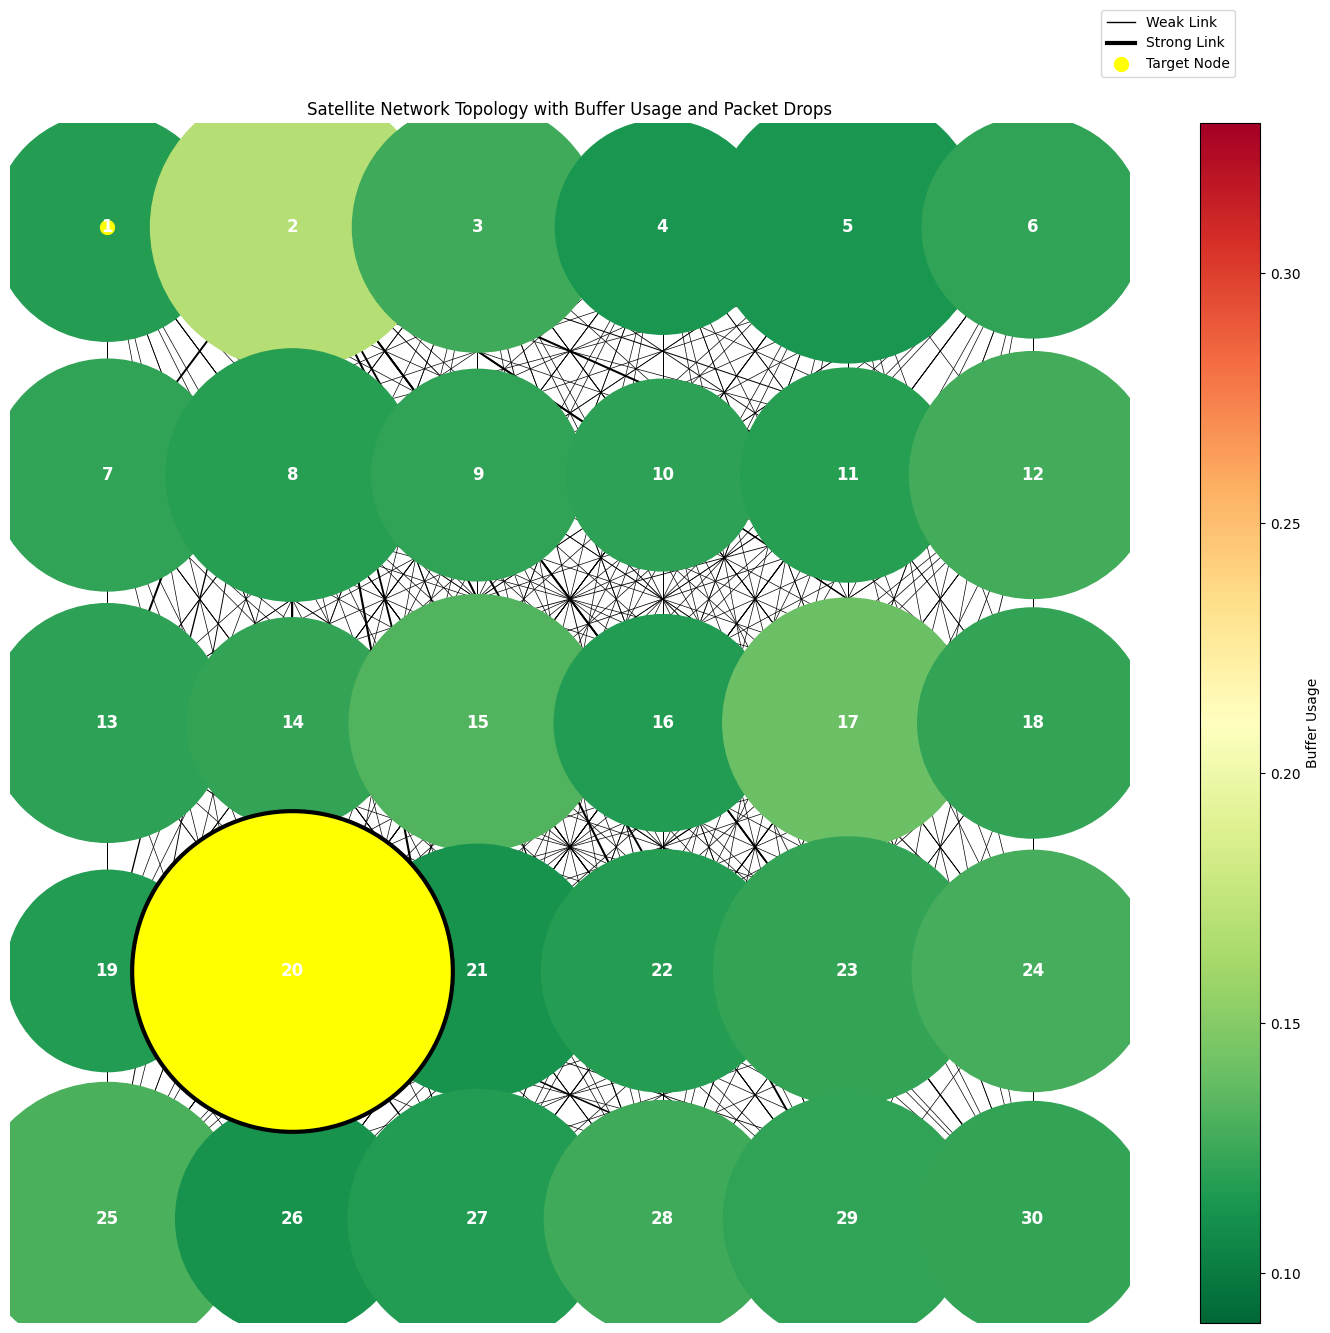

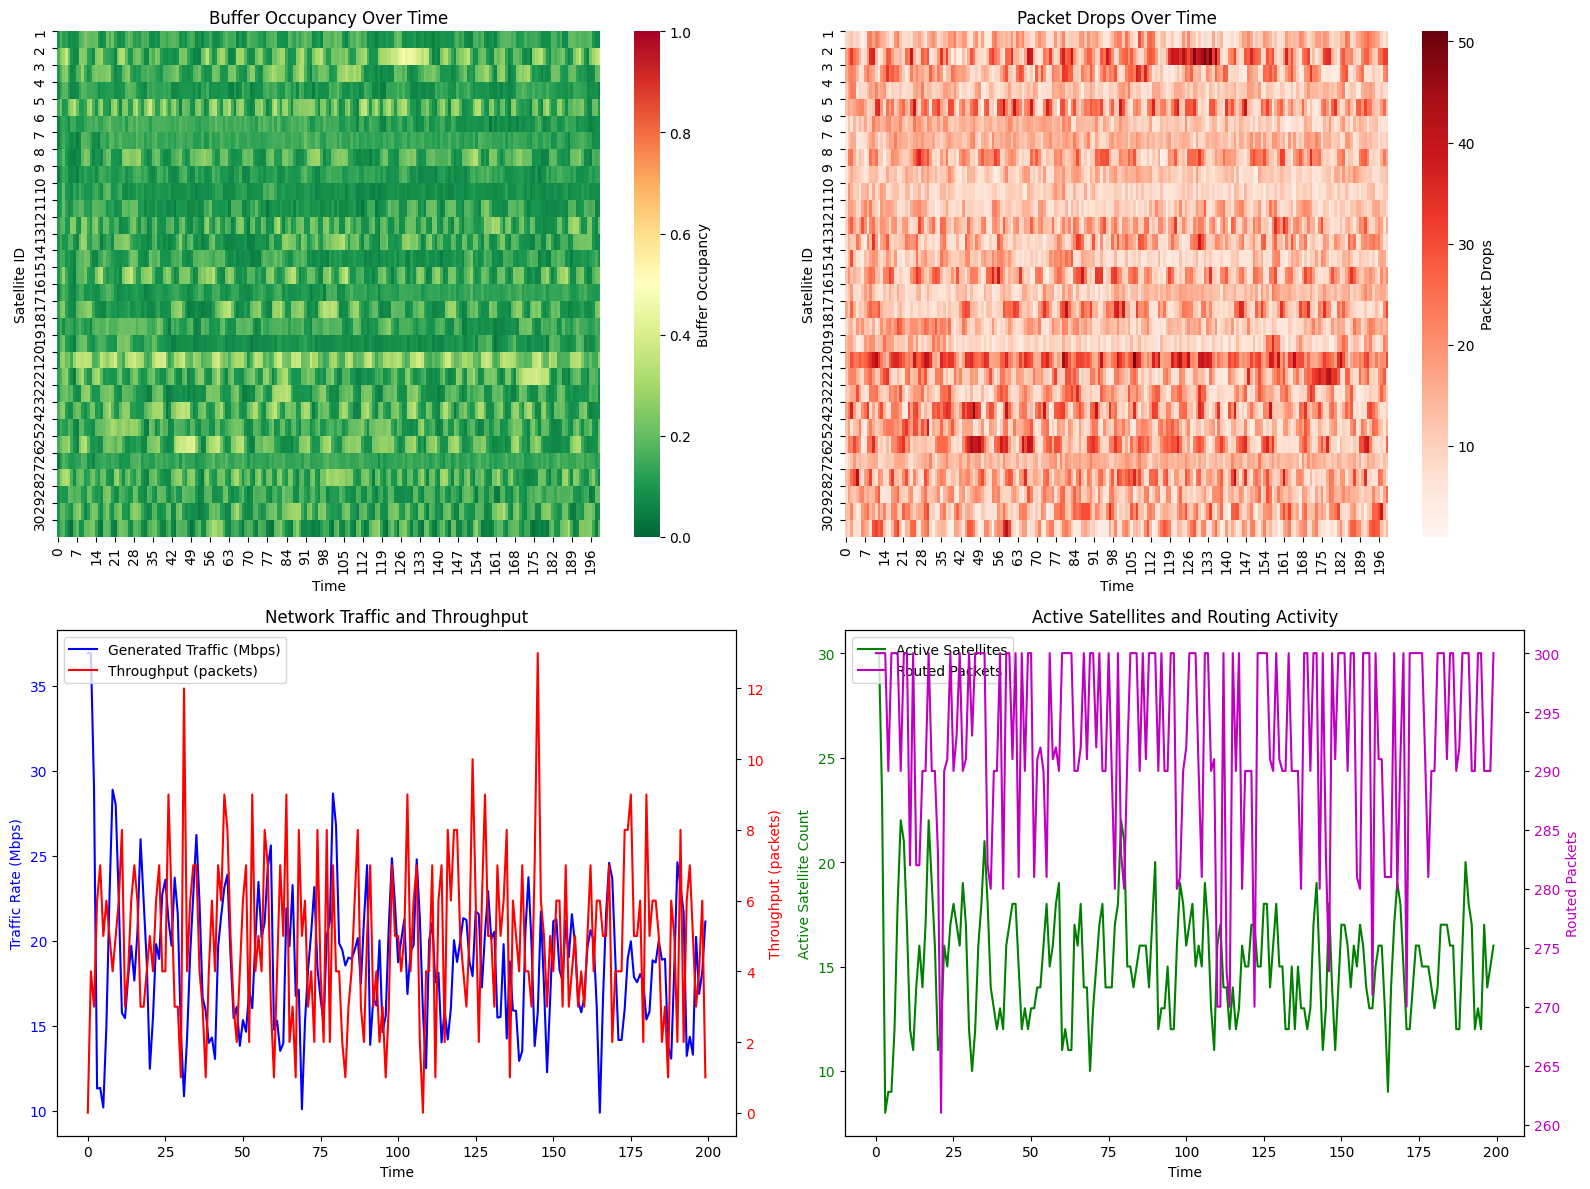

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
import networkx as nx
from collections import deque
import time
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sgp4.earth_gravity import wgs72
from sgp4.io import twoline2rv
import datetime
import math

class Packet:
    """Class representing a network packet"""
    next_id = 1

    def __init__(self, source, destination, size, creation_time):
        self.id = Packet.next_id
        Packet.next_id += 1
        self.source = source
        self.destination = destination
        self.size = size  # in KB
        self.creation_time = creation_time
        self.current_location = source
        self.hops = 0
        self.delay = 0
        self.dropped = False
        self.delivered = False

    def __repr__(self):
        return f"Packet({self.id}: {self.source}->{self.destination}, size={self.size:.1f}KB)"

class LEOSatellite:
    def __init__(self, id, position, altitude=500):
        self.id = id
        self.position = position  # (row, col)
        self.altitude = altitude  # km
        self.active = False
        self.traffic_rate = 0  # Mbps

        # Queue for packet storage
        self.buffer_capacity = 50  # KB (max buffer size)
        self.used_buffer = 0  # KB currently used
        self.queue = deque()
        self.queue_history = []
        self.buffer_occupancy_history = []
        self.drop_count = 0
        self.drop_history = []

        # Link properties
        self.link_capacity = 1  # Mbps
        self.link_utilization = 0
        self.link_utilization_history = []

        # Channel properties
        self.bit_error_rate = 0.0001  # Probability of bit error
        self.propagation_delay = 2  # ms

        # Pareto distribution parameters
        self.shape = random.uniform(1.0, 3.0)
        self.scale = random.uniform(1.0, 3.0)

        # On-Off timers
        self.on_duration = 0
        self.off_duration = 0
        self.time_left = 0

        # Traffic history
        self.traffic_history = []

        # Routing-related attributes
        self.neighbors = []  # Initialize neighbors list
        self.routing_table = {}
        self.backpressure_weights = {}

        # DHBP-specific attributes
        self.dhd_estimates = {}  # Destination-Hops-Delay estimates
        self.virtual_dhd_queues = {}  # Virtual DHD queues
        self.permitted_regions = {}  # Permitted propagation regions
        self.max_neighbors = 4  # Typical ISL count

        # Statistics
        self.packets_received = 0
        self.packets_forwarded = 0
        self.packets_delivered = 0
        self.packets_dropped = 0
        self.total_delay = 0


# Add these methods to the LEOSatellite class
    def set_mobility_model(self, tle_line1, tle_line2):
        """Initialize SGP4 propagator using TLE data"""
        self.tle_line1 = tle_line1
        self.tle_line2 = tle_line2

        # Create SGP4 satellite object
        self.sgp4_satellite = twoline2rv(tle_line1, tle_line2, wgs72)

        # Store initial time (use epoch from TLE as starting point)
        self.initial_time = self.sgp4_satellite.epoch

        # Store initial position
        position, velocity = self.sgp4_satellite.propagate(
            self.sgp4_satellite.epoch.year,
            self.sgp4_satellite.epoch.month,
            self.sgp4_satellite.epoch.day,
            self.sgp4_satellite.epoch.hour,
            self.sgp4_satellite.epoch.minute,
            self.sgp4_satellite.epoch.second
        )

        self.physical_position = position  # (x, y, z) in km
        self.velocity = velocity  # (vx, vy, vz) in km/s

        # Update the grid position based on initial projection to 2D grid
        # This maintains the logical grid topology but now we have physical coordinates too
        # You may need to modify this mapping based on your specific requirements
        return True

    def update_position(self, simulation_time):
        """Update satellite position based on simulation time

        Args:
            simulation_time: Current simulation time in seconds

        Returns:
            tuple: New position (x, y, z) in km
        """
        if not hasattr(self, 'sgp4_satellite'):
            # No mobility model set
            return None

        # Convert simulation time to real time (from initial epoch)
        # Here we assume 1 simulation time unit = 1 second
        current_datetime = self.initial_time + datetime.timedelta(seconds=simulation_time)

        # Extract datetime components
        year = current_datetime.year
        month = current_datetime.month
        day = current_datetime.day
        hour = current_datetime.hour
        minute = current_datetime.minute
        second = current_datetime.second + current_datetime.microsecond / 1000000.0

        # Propagate satellite to new position
        position, velocity = self.sgp4_satellite.propagate(year, month, day, hour, minute, second)

        # Update satellite position and velocity
        self.physical_position = position
        self.velocity = velocity

        # Calculate and update ground track (lat, lon) if needed
        # This would require conversion from ECEF to lat/lon

        # Update satellite connections based on new position
        # This would involve recalculating distances to other satellites
        # and potentially updating the neighbors list

        return position

    # Add this method to calculate distance between satellites
    def calculate_distance_to(self, other_satellite):
        """Calculate distance to another satellite based on physical positions

        Args:
            other_satellite: Another LEOSatellite object

        Returns:
            float: Distance in kilometers, or None if physical positions not available
        """
        if (not hasattr(self, 'physical_position') or
            not hasattr(other_satellite, 'physical_position')):
            # Fall back to grid-based distance if physical positions aren't available
            dx = abs(self.position[0] - other_satellite.position[0])
            dy = abs(self.position[1] - other_satellite.position[1])
            return math.sqrt(dx**2 + dy**2)

        # Calculate Euclidean distance in 3D space
        dx = self.physical_position[0] - other_satellite.physical_position[0]
        dy = self.physical_position[1] - other_satellite.physical_position[1]
        dz = self.physical_position[2] - other_satellite.physical_position[2]

        return math.sqrt(dx**2 + dy**2 + dz**2)




    def calculate_permitted_region(self, source_id, dest_id):
        """Calculate rectangular permitted region between source and destination"""
        source = self.network.get_satellite_by_id(source_id)
        dest = self.network.get_satellite_by_id(dest_id)

        # Get grid coordinates
        min_row = min(source.position[0], dest.position[0])
        max_row = max(source.position[0], dest.position[0])
        min_col = min(source.position[1], dest.position[1])
        max_col = max(source.position[1], dest.position[1])

        self.permitted_regions[(source_id, dest_id)] = (min_row, max_row, min_col, max_col)
        return (min_row, max_row, min_col, max_col)

    def is_in_permitted_region(self, node_id, source_id, dest_id):
        """Check if a node is in permitted region for a flow"""
        if (source_id, dest_id) not in self.permitted_regions:
            self.calculate_permitted_region(source_id, dest_id)

        min_row, max_row, min_col, max_col = self.permitted_regions[(source_id, dest_id)]
        node = self.network.get_satellite_by_id(node_id)
        row, col = node.position

        return (min_row <= row <= max_row) and (min_col <= col <= max_col)

            # Modify packet generation to use fixed packet size
    def generate_fixed_size_packets(self, current_time):
        """Generate packets with fixed size of 512 bytes"""
        if self.active:
            # Convert Mbps to KB per timeslot
            kb_per_timeslot = (self.traffic_rate * 1000 / 8) / 10  # Assuming 10 timeslots per second

            # Calculate how many 0.5 KB packets to generate
            packet_size = 0.5  # 512 bytes = 0.5 KB
            num_packets = int(kb_per_timeslot / packet_size)

            # Generate packets
            for _ in range(num_packets):
                # Create packet with random destination
                destination = random.choice([sat_id for sat_id in range(1, len(self.network.satellites) + 1) if sat_id != self.id])
                packet = Packet(self.id, destination, packet_size, current_time)

                # Try to admit packet
                self.admit_packet(packet)

    def update_virtual_dhd_queue(self, packet=None, operation='add'):
        """Update virtual DHD queue for a packet flow"""
        if packet is None:
            return  # Nothing to update

        flow_key = (packet.source, packet.destination)
        h_p = self.calculate_dhd(packet.destination)

        if flow_key not in self.virtual_dhd_queues:
            self.virtual_dhd_queues[flow_key] = 0
            self.calculate_permitted_region(packet.source, packet.destination)

        if operation == 'add':
            self.virtual_dhd_queues[flow_key] += h_p
        elif operation == 'remove':
            self.virtual_dhd_queues[flow_key] = max(0, self.virtual_dhd_queues[flow_key] - h_p)

    #version 2

    # def update_virtual_dhd_queue(self, packet=None, operation='add'):
    #     if packet is None:
    #         return  # Nothing to update
    #     flow_key = (packet.source, packet.destination)
    #     h_p = self.calculate_dhd(packet.destination)

    #     if operation == 'add':
    #         self.virtual_dhd_queues[flow_key] = self.virtual_dhd_queues.get(flow_key, 0) + h_p
    #     elif operation == 'remove':
    #         self.virtual_dhd_queues[flow_key] = max(0, self.virtual_dhd_queues.get(flow_key, 0) - h_p)


    def get_valid_next_hops(self, source_id, dest_id):
        """Get neighbors within permitted propagation region"""
        valid_neighbors = []
        for neighbor in self.neighbors:
            if self.is_in_permitted_region(neighbor.id, source_id, dest_id):
                valid_neighbors.append(neighbor)
        return valid_neighbors

        # Link properties
        self.link_capacity = 10  # Mbps
        self.link_utilization = 0
        self.link_utilization_history = []

        # Channel properties
        self.bit_error_rate = 0.0001  # Probability of bit error
        self.propagation_delay = 2  # ms

        # Pareto distribution parameters (random for each satellite)
        self.shape = random.uniform(1.5, 5.0)  # Shape parameter for Pareto distribution
        self.scale = random.uniform(1.0, 3.0)  # Scale parameter for Pareto distribution

        # On-Off timers
        self.on_duration = 0
        self.off_duration = 0
        self.time_left = 0

        # Traffic history
        self.traffic_history = []

        # Routing-related attributes
        self.neighbors = []
        self.routing_table = {}
        self.backpressure_weights = {}

        # Statistics
        self.packets_received = 0
        self.packets_forwarded = 0
        self.packets_delivered = 0
        self.packets_dropped = 0
        self.total_delay = 0

    def can_admit_packet(self, packet):
        """Check if packet can be admitted based on buffer capacity"""
        return self.used_buffer + packet.size <= self.buffer_capacity

    def admit_packet(self, packet):
        """Add packet to queue and update virtual DHD queue"""
        if self.can_admit_packet(packet):
            self.queue.append(packet)
            self.used_buffer += packet.size
            packet.current_location = self.id
            self.update_virtual_dhd_queue(packet, 'add')
            return True
        else:
            self.packets_dropped += 1
            packet.dropped = True
            return False

    def remove_packet(self, packet):
        """Remove packet from queue and update virtual DHD queue"""
        if packet in self.queue:
            self.queue.remove(packet)
            self.used_buffer -= packet.size
            self.update_virtual_dhd_queue(packet, 'remove')
            return True
        return False

    def process_bit_errors(self):
        """Process bit errors in the queue, potentially dropping packets"""
        for packet in list(self.queue):
            # Check if packet is corrupted due to bit errors
            # Calculate probability based on packet size (larger packets more likely to be corrupted)
            corruption_probability = 1 - (1 - self.bit_error_rate) ** (packet.size * 8 * 1024)  # Convert KB to bits

            if random.random() < corruption_probability:
                # Packet is corrupted, drop it
                self.remove_packet(packet)
                self.packets_dropped += 1
                packet.dropped = True

    def update(self, current_time, use_fixed_size=False):
        """Update satellite state, generate traffic, and process queue"""
        # Update timer for on-off behavior
        if self.time_left > 0:
            self.time_left -= 1
        else:
            # Switch state when timer reaches zero
            if self.active:
                self.active = False
                # Generate new off duration from Pareto distribution
                self.off_duration = max(1, int(stats.pareto.rvs(b=self.shape, scale=self.scale)))
                self.time_left = self.off_duration
                self.traffic_rate = 0
            else:
                self.active = True
                # Generate new on duration from Pareto distribution
                self.on_duration = max(1, int(stats.pareto.rvs(b=self.shape, scale=self.scale)))
                self.time_left = self.on_duration
                # Generate traffic rate when active (in Mbps)
                self.traffic_rate = random.uniform(0.5, 0.75) * self.shape

        # Generate packets when active
        if self.active:
            if use_fixed_size:
                # Use the fixed-size packet generation method
                self.generate_fixed_size_packets(current_time)
            else:
                # Original packet generation code
                # Convert Mbps to KB per timeslot
                kb_per_timeslot = (self.traffic_rate * 1000 / 8) / 10  # Assuming 10 timeslots per second

                # Generate packets (keeping track of total size)
                total_size = 0
                while total_size < kb_per_timeslot:
                    # Random packet size from 1 to 5 KB
                    packet_size = random.uniform(1, 5)

                    # Check if this would exceed our traffic rate
                    if total_size + packet_size > kb_per_timeslot:
                        break

                    total_size += packet_size

                    # Create packet with random destination
                    destination = random.choice([sat_id for sat_id in range(1, len(self.network.satellites) + 1) if sat_id != self.id])
                    packet = Packet(self.id, destination, packet_size, current_time)

                    # Try to admit packet
                    if not self.admit_packet(packet):
                        # If admission fails, packet is dropped due to buffer overflow
                        pass

        # Process bit errors (may drop packets)
        self.process_bit_errors()

        # Record histories
        self.traffic_history.append(self.traffic_rate)
        self.queue_history.append(len(self.queue))
        self.buffer_occupancy_history.append(self.used_buffer / self.buffer_capacity if self.buffer_capacity > 0 else 0)
        self.drop_history.append(self.packets_dropped)

        if len(self.traffic_history) > 200:
            self.traffic_history = self.traffic_history[-200:]
        if len(self.queue_history) > 200:
            self.queue_history = self.queue_history[-200:]
        if len(self.buffer_occupancy_history) > 200:
            self.buffer_occupancy_history = self.buffer_occupancy_history[-200:]
        if len(self.drop_history) > 200:
            self.drop_history = self.drop_history[-200:]

        return self.traffic_rate



        # Process bit errors (may drop packets)
        self.process_bit_errors()

        # Record histories
        self.traffic_history.append(self.traffic_rate)
        self.queue_history.append(len(self.queue))
        self.buffer_occupancy_history.append(self.used_buffer / self.buffer_capacity if self.buffer_capacity > 0 else 0)
        self.drop_history.append(self.packets_dropped)

        if len(self.traffic_history) > 200:
            self.traffic_history = self.traffic_history[-200:]
        if len(self.queue_history) > 200:
            self.queue_history = self.queue_history[-200:]
        if len(self.buffer_occupancy_history) > 200:
            self.buffer_occupancy_history = self.buffer_occupancy_history[-200:]
        if len(self.drop_history) > 200:
            self.drop_history = self.drop_history[-200:]

        return self.traffic_rate

    def calculate_weight(self, neighbor, congestion_factor=0.8):
        """Calculate backpressure weight based on queue differentials with congestion awareness"""
        # Queue length differential
        my_queue_occupancy = self.used_buffer / self.buffer_capacity
        neighbor_queue_occupancy = neighbor.used_buffer / neighbor.buffer_capacity

        # Calculate differential
        queue_diff = my_queue_occupancy - neighbor_queue_occupancy

        # Calculate link quality factor (based on bit error rate)
        link_quality = 1 - neighbor.bit_error_rate

        # Calculate congestion factor (consider both queue state and link capacity)
        neighbor_congestion = neighbor_queue_occupancy * congestion_factor

        # If neighbor is highly congested, reduce the weight
        weight = queue_diff * link_quality * (1 - neighbor_congestion)

        return weight if weight > 0 else 0  # Only return positive weights

    # version 2
    # def calculate_weight(self, neighbor, flow_dest, congestion_factor=0.8):
    #     my_queue_occupancy = self.used_buffer / self.buffer_capacity
    #     neighbor_queue_occupancy = neighbor.used_buffer / neighbor.buffer_capacity

    #     # Incorporating hops into the weight calculation
    #     hops_to_dest = self.calculate_dhd(flow_dest)
    #     neighbor_hops_to_dest = neighbor.calculate_dhd(flow_dest)

    #     # Calculate weight difference considering hops and congestion
    #     weight = (my_queue_occupancy - neighbor_queue_occupancy) * (hops_to_dest - neighbor_hops_to_dest) * (1 - neighbor_queue_occupancy * congestion_factor)
    #     return max(0, weight)

    def update_backpressure_weights(self):
        """Update backpressure weights for all neighbors"""
        self.backpressure_weights = {}

        for neighbor in self.neighbors:
            weight = self.calculate_weight(neighbor)
            self.backpressure_weights[neighbor.id] = weight
            # version 2
    # def update_backpressure_weights(self):
    # # """Update backpressure weights for all neighbors"""
    #     self.backpressure_weights = {}

    #     for neighbor in self.neighbors:
    #         # Use the target node (destination) for the flow. You can adjust this based on your network setup.
    #         flow_dest = self.network.target_node_id  # This assumes you have a target node set somewhere
    #         weight = self.calculate_weight(neighbor, flow_dest)
    #         self.backpressure_weights[neighbor.id] = weight


    def route_packets(self, current_time, target_node_id=None, max_routes=10):
        """Route packets based on backpressure algorithm with constraints"""
        # Update backpressure weights first
        self.update_backpressure_weights()

        # Don't route if queue is empty
        if not self.queue:
            return 0

        # Calculate available link capacity
        available_capacity = max(0, self.link_capacity - self.link_utilization)

        # Convert Mbps to KB per timeslot
        available_capacity_kb = (available_capacity * 1000 / 8) / 10  # Assuming 10 timeslots per second

        # Determine how many packets we can route (limited by capacity and max_routes)
        capacity_used = 0
        packets_routed = 0

        # Sort neighbors by weight (highest first)
        sorted_neighbors = sorted(
            [(n, self.backpressure_weights.get(n.id, 0)) for n in self.neighbors],
            key=lambda x: x[1] + 10 if x[0].id == target_node_id else x[1],
            reverse=True
        )

        # Try to route packets
        for packet in list(self.queue):
            if packets_routed >= max_routes:
                break

            # If this is the destination, deliver it
            if packet.destination == self.id:
                self.remove_packet(packet)
                packet.delivered = True
                self.packets_delivered += 1
                packet.delay = current_time - packet.creation_time
                self.total_delay += packet.delay
                packets_routed += 1
                continue

            # Otherwise, try to find a neighbor to forward to
            forwarded = False

            for neighbor, weight in sorted_neighbors:
                # Skip if no positive pressure or insufficient capacity
                if weight <= 0 or capacity_used + packet.size > available_capacity_kb:
                    continue

                # Calculate propagation delay based on distance
                prop_delay = self.propagation_delay

                # Try to admit packet to neighbor
                if neighbor.admit_packet(packet):
                    # Successfully forwarded
                    self.remove_packet(packet)
                    packet.hops += 1
                    packet.delay += prop_delay
                    self.packets_forwarded += 1
                    capacity_used += packet.size
                    packets_routed += 1
                    forwarded = True
                    break

            # If packet couldn't be forwarded, it stays in the queue
            if not forwarded:
                # Add delay for staying in queue
                packet.delay += 1

        # Update link utilization based on capacity used
        self.link_utilization = capacity_used * 8 * 10 / 1000  # Convert back to Mbps
        self.link_utilization_history.append(self.link_utilization)
        if len(self.link_utilization_history) > 200:
            self.link_utilization_history = self.link_utilization_history[-200:]

        return packets_routed

    # def calculate_dhd(self, destination_id):
    #     """Calculate Destination-Hops-Delay estimate to destination"""
    #     if destination_id not in self.dhd_estimates:
    #         # Simple estimation: Manhattan distance in grid
    #         dest_sat = self.network.get_satellite_by_id(destination_id)
    #         dx = abs(self.position[0] - dest_sat.position[0])
    #         dy = abs(self.position[1] - dest_sat.position[1])
    #         self.dhd_estimates[destination_id] = dx + dy  # Manhattan distance
    #     return self.dhd_estimates[destination_id]
    # Add these methods to the LEOSatellite class

    def initialize_orbital_parameters(self):
        """Initialize orbital parameters for realistic LEO constellation modeling

        This should be called after network creation to set correct orbital parameters
        for each satellite based on its position in the constellation.
        """
        # Total number of planes in the constellation
        total_planes = self.network.cols

        # Set ascending meridian (longitude of ascending node)
        # Distribute evenly around Earth (0 to 2π)
        self.ascending_meridian = (self.position[1] * 2 * np.pi / total_planes)

        # Phase angle within the orbit plane
        # Distribute evenly within orbit (0 to 2π)
        satellites_per_orbit = self.network.rows
        self.phase_angle = (self.position[0] * 2 * np.pi / satellites_per_orbit)

        # Calculate orbital spacing parameters
        self.delta_omega = 2 * np.pi / total_planes  # Spacing between adjacent orbit planes
        self.delta_phi = 2 * np.pi / satellites_per_orbit  # Spacing between satellites in same plane

        # Delta_f is the phase shift between adjacent orbit planes
        # For simplicity, using a typical value for Walker constellations
        self.delta_f = 2 * np.pi / (satellites_per_orbit * total_planes)

    def calculate_orbital_hops(self, destination_id):
        """Calculate minimum hops using orbital mechanics according to equations 1-5

        Returns the minimum hop count between this satellite and the destination
        considering both inter-plane (Hh) and intra-plane (Hv) movements.
        """
        # Get destination satellite
        dest_sat = self.network.get_satellite_by_id(destination_id)
        if not dest_sat:
            return 0  # Invalid destination

        # Get orbital parameters
        L1 = self.ascending_meridian
        L2 = dest_sat.ascending_meridian
        u1 = self.phase_angle
        u2 = dest_sat.phase_angle

        # Eq. (1): Calculate longitude difference of ascending points
        delta_L0 = (L2 - L1) % (2 * np.pi)

        # Eq. (2): Calculate inter-plane hops in both directions
        # Use nearest integer function as indicated by ⟨x⟩ in the paper
        H_h_west = round((2 * np.pi - delta_L0) / self.delta_omega)
        H_h_east = round(delta_L0 / self.delta_omega)

        # Eq. (4): Calculate phase difference with compensation for inter-plane movement
        delta_u_east = (u2 - u1 - H_h_east * self.delta_f) % (2 * np.pi)
        delta_u_west = (u2 - u1 + H_h_west * self.delta_f) % (2 * np.pi)

        # Eq. (5): Calculate intra-plane hops in all four directions
        H_v_northwest = round(delta_u_west / self.delta_phi)
        H_v_northeast = round(delta_u_east / self.delta_phi)
        H_v_southwest = round((2 * np.pi - delta_u_west) / self.delta_phi)
        H_v_southeast = round((2 * np.pi - delta_u_east) / self.delta_phi)

        # Calculate total hops for all possible directions
        total_hops = [
            H_h_west + H_v_northwest,    # Northwest path
            H_h_west + H_v_southwest,    # Southwest path
            H_h_east + H_v_northeast,    # Northeast path
            H_h_east + H_v_southeast     # Southeast path
        ]

        # Return minimum hop count
        return min(total_hops)

    def calculate_dhd(self, destination_id):
        """Calculate Destination-Hops-Delay estimate to destination

        Now uses orbital mechanics for realistic hop calculation
        Falls back to Manhattan distance if orbital parameters aren't initialized
        """
        if destination_id not in self.dhd_estimates:
            # Check if we have orbital parameters initialized
            if hasattr(self, 'ascending_meridian') and hasattr(self, 'delta_omega'):
                # Use realistic orbital hop calculation
                self.dhd_estimates[destination_id] = self.calculate_orbital_hops(destination_id)
            else:
                # Fallback to simple estimation: Manhattan distance in grid
                dest_sat = self.network.get_satellite_by_id(destination_id)
                dx = abs(self.position[0] - dest_sat.position[0])
                dy = abs(self.position[1] - dest_sat.position[1])
                self.dhd_estimates[destination_id] = dx + dy  # Manhattan distance

        return self.dhd_estimates[destination_id]

    def calculate_dhbp_weight(self, neighbor, flow_dest):
        """Calculate DHBP weight for a specific flow to neighbor"""
        # Get our virtual DHD backlog for this flow
        flow_key = (self.id, flow_dest)
        my_dhd_backlog = self.virtual_dhd_queues.get(flow_key, 0)

        # Get neighbor's virtual DHD backlog for this flow
        neighbor_flow_key = (neighbor.id, flow_dest)
        neighbor_dhd_backlog = neighbor.virtual_dhd_queues.get(neighbor_flow_key, 0)

        # Calculate weight difference
        weight = my_dhd_backlog - neighbor_dhd_backlog

        # Add congestion awareness (original BP factor)
        my_queue_occupancy = self.used_buffer / self.buffer_capacity
        neighbor_queue_occupancy = neighbor.used_buffer / neighbor.buffer_capacity
        congestion_factor = 1 - neighbor_queue_occupancy

        return max(0, weight * congestion_factor)


    def route_packets_dhbp(self, current_time, target_node_id=None, max_routes=5):
        """Complete DHBP routing with propagation region control"""
        # Don't route if queue is empty
        if not self.queue:
            return 0

        # Calculate available capacity
        available_capacity = max(0, self.link_capacity - self.link_utilization)
        available_capacity_kb = (available_capacity * 1000 / 8) / 10

        # Group packets by flow (source,destination pairs)
        flow_packets = {}
        for packet in list(self.queue):
            flow_key = (packet.source, packet.destination)
            if flow_key not in flow_packets:
                flow_packets[flow_key] = []
            flow_packets[flow_key].append(packet)

        # Route packets flow by flow
        capacity_used = 0
        packets_routed = 0

        for (source_id, dest_id), packets in flow_packets.items():
            if packets_routed >= max_routes:
                break

            # Get valid next hops within permitted region
            # valid_neighbors = self.get_valid_next_hops(source_id, dest_id)
            valid_neighbors = [
                neighbor for neighbor in self.neighbors
                if self.is_in_permitted_region(neighbor.id, source_id, dest_id)
            ]

            if not valid_neighbors:
                continue

            # Calculate weights for valid neighbors
            neighbor_weights = {}
            my_virtual_queue = self.virtual_dhd_queues.get((source_id, dest_id), 0)

            for neighbor in valid_neighbors:
                neighbor_virtual_queue = neighbor.virtual_dhd_queues.get((source_id, dest_id), 0)
                # weight = my_virtual_queue - neighbor_virtual_queue
                weight = self.calculate_dhbp_weight(neighbor, dest_id)
                neighbor_weights[neighbor.id] = max(0, weight)

            # Find best neighbor
            if not neighbor_weights:
                continue

            best_neighbor_id = max(neighbor_weights.items(), key=lambda x: x[1])[0]
            best_neighbor = self.network.get_satellite_by_id(best_neighbor_id)

            # Route packets to best neighbor
            for packet in packets:
                if packets_routed >= max_routes or capacity_used + packet.size > available_capacity_kb:
                    break

                # Deliver if at destination
                if packet.destination == self.id:
                    self.remove_packet(packet)
                    self.update_virtual_dhd_queue(packet, 'remove')
                    packet.delivered = True
                    self.packets_delivered += 1
                    packet.delay = current_time - packet.creation_time
                    self.total_delay += packet.delay
                    packets_routed += 1
                    continue

                # Forward to best neighbor
                if best_neighbor.admit_packet(packet):
                    self.remove_packet(packet)
                    self.update_virtual_dhd_queue(packet, 'remove')
                    best_neighbor.update_virtual_dhd_queue(packet, 'add')

                    packet.hops += 1
                    packet.delay += self.propagation_delay
                    self.packets_forwarded += 1
                    capacity_used += packet.size
                    packets_routed += 1
                else:
                    packet.delay += 1

        # Update link utilization
        self.link_utilization = capacity_used * 8 * 10 / 1000
        self.link_utilization_history.append(self.link_utilization)
        if len(self.link_utilization_history) > 200:
            self.link_utilization_history = self.link_utilization_history[-200:]

        return packets_routed

class LEOSatelliteNetwork:
    def __init__(self, rows=4, cols=5):
        self.rows = rows
        self.cols = cols
        self.satellites = []
        self.total_traffic = 0
        self.traffic_history = []
        self.routed_packets_history = []
        self.time = 0
        self.target_node_id = None
        self.simulation_stats = {
            'delivered_packets': 0,
            'dropped_packets': 0,
            'avg_delay': 0,
            'avg_hops': 0,
            'network_throughput': []
        }

        # Initialize satellites
        for i in range(rows):
            for j in range(cols):
                sat_id = i * cols + j + 1
                position = (i, j)
                self.satellites.append(LEOSatellite(sat_id, position))

        # Set up network topology and neighbors
        self._setup_neighbors()

        # Add reference to network in each satellite
        for sat in self.satellites:
            sat.network = self

    def _setup_neighbors(self, max_intra_plane=2, max_inter_plane=2):
        """Set up neighbors with specific intra-plane and inter-plane connections"""
        for sat in self.satellites:
            row, col = sat.position
            sat.neighbors = []

            # Intra-plane connections (same column, adjacent rows)
            intra_plane_neighbors = []
            for offset in range(1, max_intra_plane + 1):
                # Connect with next satellite in orbit (wrap around at edges)
                next_row = (row + offset) % self.rows
                next_sat = self.get_satellite_by_position(next_row, col)
                if next_sat:
                    intra_plane_neighbors.append(next_sat)

                # Connect with previous satellite in orbit
                prev_row = (row - offset) % self.rows
                prev_sat = self.get_satellite_by_position(prev_row, col)
                if prev_sat:
                    intra_plane_neighbors.append(prev_sat)

            # Inter-plane connections (same row, adjacent columns)
            inter_plane_neighbors = []
            for offset in range(1, max_inter_plane + 1):
                # Connect with satellite in next plane (wrap around at edges)
                next_col = (col + offset) % self.cols
                next_plane_sat = self.get_satellite_by_position(row, next_col)
                if next_plane_sat:
                    inter_plane_neighbors.append(next_plane_sat)

                # Connect with satellite in previous plane
                prev_col = (col - offset) % self.cols
                prev_plane_sat = self.get_satellite_by_position(row, prev_col)
                if prev_plane_sat:
                    inter_plane_neighbors.append(prev_plane_sat)

            # Add all neighbors (limited to the maximum number allowed)
            sat.neighbors = intra_plane_neighbors[:max_intra_plane] + inter_plane_neighbors[:max_inter_plane]

            # Set up link properties for each neighbor
            for neighbor in sat.neighbors:
                if not hasattr(sat, 'link_properties'):
                    sat.link_properties = {}

                # Calculate distance
                n_row, n_col = neighbor.position
                distance = np.sqrt((row - n_row)**2 + (col - n_col)**2)

                # Store link-specific properties
                sat.link_properties[neighbor.id] = {
                    'distance': distance,
                    'propagation_delay': int(2 * distance),  # ms
                    'bit_error_rate': 0.0001 * distance,  # Higher BER with distance
                    'is_intra_plane': n_col == col,  # Is it an intra-plane link?
                    'is_inter_plane': n_row == row   # Is it an inter-plane link?
                }

    def load_tle_data(self, tle_file_path):
        """Load TLE data from file and assign to satellites

        Args:
            tle_file_path: Path to the TLE data file

        Returns:
            bool: True if successful, False otherwise
        """
        try:
            with open(tle_file_path, 'r') as file:
                lines = file.readlines()

            # Process TLE data in sets of three lines (name, line1, line2)
            satellite_index = 0
            for i in range(0, len(lines), 3):
                if satellite_index >= len(self.satellites):
                    break

                name = lines[i].strip()
                line1 = lines[i+1].strip()
                line2 = lines[i+2].strip()

                # Set mobility model for the satellite
                self.satellites[satellite_index].set_mobility_model(line1, line2)
                satellite_index += 1

            return True
        except Exception as e:
            print(f"Error loading TLE data: {e}")
            return False

    def update_all_positions(self, simulation_time):
        """Update positions of all satellites in the network

        Args:
            simulation_time: Current simulation time in seconds
        """
        for sat in self.satellites:
            sat.update_position(simulation_time)

        # Optionally recalculate topology based on new positions
        self._recalculate_topology()

    def _recalculate_topology(self):
        """Recalculate satellite connections based on current physical positions"""
        # Define maximum ISL range in kilometers
        max_isl_range = 1000  # Example value, adjust based on your constellation parameters

        for sat in self.satellites:
            # Clear existing neighbors
            sat.neighbors = []

            # Find new neighbors based on physical distance
            for other_sat in self.satellites:
                if other_sat.id != sat.id:
                    distance = sat.calculate_distance_to(other_sat)

                    # If within range, add as neighbor
                    if distance <= max_isl_range:
                        sat.neighbors.append(other_sat)

                        # Update link properties based on distance
                        if not hasattr(sat, 'link_properties'):
                            sat.link_properties = {}

                        # Calculate propagation delay based on distance
                        prop_delay = distance / 300  # Light speed is ~300,000 km/s, time in ms

                        # Store link properties
                        sat.link_properties[other_sat.id] = {
                            'distance': distance,
                            'propagation_delay': prop_delay,
                            'bit_error_rate': 0.0001 * (distance / 1000),  # Higher BER with distance
                            'is_intra_plane': False,  # Will determine this based on orbital elements
                            'is_inter_plane': False    # Will determine this based on orbital elements
                        }



    # Add helper method to get satellite by position
    def get_satellite_by_position(self, row, col):
        """Get satellite by its position in the grid"""
        for sat in self.satellites:
            if sat.position == (row, col):
                return sat
        return None

    def get_satellite_by_id(self, sat_id):
        """Get satellite object by ID"""
        for sat in self.satellites:
            if sat.id == sat_id:
                return sat
        return None

    # Add this method to the LEOSatelliteNetwork class
    def initialize_orbital_parameters(self):
        """Initialize orbital parameters for all satellites in the network"""
        for satellite in self.satellites:
            satellite.initialize_orbital_parameters()
        print("Orbital parameters initialized for realistic hop calculation")


    def set_target_node(self, target_id):
        """Set a target node for back-pressure routing"""
        if 1 <= target_id <= len(self.satellites):
            self.target_node_id = target_id
            print(f"Target node set to Satellite {target_id}")
            return True
        else:
            print(f"Invalid satellite ID: {target_id}")
            return False

    def update(self, use_dhbp=False, use_fixed_size=True):

        self.time += 1
        self.total_traffic = 0
        total_routed = 0

        # Update satellite positions based on simulation time
        if hasattr(self, 'use_mobility_model') and self.use_mobility_model:
            self.update_all_positions(self.time)



        # Update all satellites (generate traffic and update queues)
        for sat in self.satellites:
            self.total_traffic += sat.update(self.time, use_fixed_size)

        # Apply routing for each satellite
        for sat in self.satellites:
            if use_dhbp:
                routed = sat.route_packets_dhbp(self.time, self.target_node_id)
            else:
                routed = sat.route_packets(self.time, self.target_node_id)
            total_routed += routed

        # Record history
        self.traffic_history.append(self.total_traffic)
        self.routed_packets_history.append(total_routed)

        if len(self.traffic_history) > 200:
            self.traffic_history = self.traffic_history[-200:]
        if len(self.routed_packets_history) > 200:
            self.routed_packets_history = self.routed_packets_history[-200:]

        # Calculate network throughput
        total_delivered = sum(sat.packets_delivered for sat in self.satellites)
        new_delivered = total_delivered - self.simulation_stats['delivered_packets']
        self.simulation_stats['network_throughput'].append(new_delivered)

        # Update statistics
        self.simulation_stats['delivered_packets'] = total_delivered
        self.simulation_stats['dropped_packets'] = sum(sat.packets_dropped for sat in self.satellites)

        # Calculate average delay and hops
        total_delay = sum(sat.total_delay for sat in self.satellites)
        if total_delivered > 0:
            self.simulation_stats['avg_delay'] = total_delay / total_delivered

        return self.total_traffic

    def get_active_count(self):
        return sum(1 for sat in self.satellites if sat.active)

    def get_queue_lengths(self):
        """Return current queue length for each satellite"""
        return {sat.id: len(sat.queue) for sat in self.satellites}

    def get_buffer_usage(self):
        """Return current buffer usage percentage for each satellite"""
        return {sat.id: sat.used_buffer / sat.buffer_capacity * 100 for sat in self.satellites}

    def run_simulation(self, steps=100, target_node=None, use_dhbp=False, use_fixed_size=True):
        """Run simulation for a specified number of steps"""
        if target_node:
            self.set_target_node(target_node)

        for _ in range(steps):
            self.update(use_dhbp, use_fixed_size)
        return self

    def visualize_network_graph(self):
        """Create a network graph visualization showing satellite connections and buffer usage"""
        G = nx.Graph()

        # Add nodes
        for sat in self.satellites:
            G.add_node(sat.id, buffer_usage=sat.used_buffer / sat.buffer_capacity,
                      active=sat.active, dropped=sat.packets_dropped)

        # Add edges
        edge_weights = []
        for sat in self.satellites:
            for neighbor in sat.neighbors:
                G.add_edge(sat.id, neighbor.id)
                # Store the weight for the edge
                if (sat.id, neighbor.id) not in edge_weights and (neighbor.id, sat.id) not in edge_weights:
                    weight = sat.backpressure_weights.get(neighbor.id, 0)
                    edge_weights.append(((sat.id, neighbor.id), weight))

        # Create figure
        plt.figure(figsize=(14, 12))

        # Get positions based on grid layout
        pos = {sat.id: (sat.position[1], -sat.position[0]) for sat in self.satellites}

        # Node colors based on buffer usage (from green to red)
        buffer_usage = [sat.used_buffer / sat.buffer_capacity for sat in self.satellites]
        cmap = plt.cm.RdYlGn_r
        node_colors = [cmap(usage) for usage in buffer_usage]

        # Node sizes based on packet drop count
        node_sizes = [300 + sat.packets_dropped * 10 for sat in self.satellites]

        # Edge widths based on weights
        edge_width = []
        for edge in G.edges():
            weight = 1.0  # Default width
            for (u, v), w in edge_weights:
                if (edge[0] == u and edge[1] == v) or (edge[0] == v and edge[1] == u):
                    weight = max(0.5, min(5, w * 5))  # Scale weight between 0.5 and 5
                    break
            edge_width.append(weight)

        # Draw the graph
        nx.draw(G, pos, with_labels=True, node_color=node_colors,
                node_size=node_sizes, width=edge_width,
                font_color='white', font_weight='bold')

        # Highlight target node if set
        if self.target_node_id:
            target_node_pos = {self.target_node_id: pos[self.target_node_id]}
            nx.draw_networkx_nodes(G, target_node_pos, nodelist=[self.target_node_id],
                                  node_color='yellow', node_size=node_sizes[self.target_node_id-1]+100,
                                  edgecolors='black', linewidths=3)

        plt.title('Satellite Network Topology with Buffer Usage and Packet Drops')

        # Create a colorbar for buffer usage
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(buffer_usage)
        cbar = plt.colorbar(sm, ax=plt.gca())
        cbar.set_label('Buffer Usage')

        # Add a legend
        plt.plot([0], [0], '-', color='black', linewidth=1, label='Weak Link')
        plt.plot([0], [0], '-', color='black', linewidth=3, label='Strong Link')
        plt.plot([0], [0], 'o', color='yellow', markersize=10, label='Target Node')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

        plt.axis('off')
        plt.tight_layout()
        return plt.gcf()

    def plot_network_statistics(self):
        """Plot comprehensive statistics about the network"""
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Buffer occupancy heatmap for all satellites over time
        data = []
        for sat in self.satellites:
            data.append(sat.buffer_occupancy_history)

        # Create DataFrame for buffer occupancy
        buffer_df = pd.DataFrame(data)

        # Create heatmap
        sns.heatmap(buffer_df, ax=axs[0, 0], cmap='RdYlGn_r',
                   vmin=0, vmax=1, cbar_kws={'label': 'Buffer Occupancy'})
        axs[0, 0].set_title('Buffer Occupancy Over Time')
        axs[0, 0].set_xlabel('Time')
        axs[0, 0].set_ylabel('Satellite ID')
        axs[0, 0].set_yticks(range(len(self.satellites)))
        axs[0, 0].set_yticklabels([sat.id for sat in self.satellites])

        # Plot 2: Packet drops
        drop_data = []
        for sat in self.satellites:
            # Get differences between consecutive values
            drops = [sat.drop_history[i] - sat.drop_history[i-1] if i > 0 else sat.drop_history[i]
                    # for i in range(len(sat.drop_
                    for i in range(len(sat.drop_history))]
            drop_data.append(drops)

        # Create DataFrame for packet drops
        drop_df = pd.DataFrame(drop_data)

        # Create heatmap for packet drops
        sns.heatmap(drop_df, ax=axs[0, 1], cmap='Reds',
                   cbar_kws={'label': 'Packet Drops'})
        axs[0, 1].set_title('Packet Drops Over Time')
        axs[0, 1].set_xlabel('Time')
        axs[0, 1].set_ylabel('Satellite ID')
        axs[0, 1].set_yticks(range(len(self.satellites)))
        axs[0, 1].set_yticklabels([sat.id for sat in self.satellites])

        # Plot 3: Network Traffic and Throughput
        ax3 = axs[1, 0]
        t = range(len(self.traffic_history))
        ax3.plot(t, self.traffic_history, 'b-', label='Generated Traffic (Mbps)')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Traffic Rate (Mbps)', color='b')
        ax3.tick_params(axis='y', labelcolor='b')

        # Create a twin axis for throughput
        ax3_twin = ax3.twinx()
        ax3_twin.plot(t, self.simulation_stats['network_throughput'][-len(t):], 'r-', label='Throughput (packets)')
        ax3_twin.set_ylabel('Throughput (packets)', color='r')
        ax3_twin.tick_params(axis='y', labelcolor='r')

        ax3.set_title('Network Traffic and Throughput')
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        # Plot 4: Active satellites and routed packets
        ax4 = axs[1, 1]
        active_counts = [sum(1 for sat in self.satellites if len(sat.traffic_history) > i and sat.traffic_history[i] > 0)
                         for i in range(min(len(t), max([len(sat.traffic_history) for sat in self.satellites])))]
        ax4.plot(t[:len(active_counts)], active_counts, 'g-', label='Active Satellites')
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Active Satellite Count', color='g')
        ax4.tick_params(axis='y', labelcolor='g')

        # Create a twin axis for routed packets
        ax4_twin = ax4.twinx()
        ax4_twin.plot(t, self.routed_packets_history[-len(t):], 'm-', label='Routed Packets')
        ax4_twin.set_ylabel('Routed Packets', color='m')
        ax4_twin.tick_params(axis='y', labelcolor='m')

        ax4.set_title('Active Satellites and Routing Activity')
        lines1, labels1 = ax4.get_legend_handles_labels()
        lines2, labels2 = ax4_twin.get_legend_handles_labels()
        ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        plt.tight_layout()
        return fig

    def plot_sat_dhbp_queues(self, sat_id):
        """Plot DHBP virtual queue statistics for a satellite"""
        satellite = self.get_satellite_by_id(sat_id)
        if not satellite or not satellite.virtual_dhd_queues:
            return None

        plt.figure(figsize=(10, 6))
        flows = list(satellite.virtual_dhd_queues.keys())
        values = list(satellite.virtual_dhd_queues.values())

        flow_labels = [f"{src}->{dst}" for src, dst in flows]
        plt.bar(flow_labels, values)
        plt.xlabel('Flows (Source->Destination)')
        plt.ylabel('Virtual Queue Size')
        plt.title(f'DHBP Virtual Queue Sizes for Satellite {sat_id}')
        plt.xticks(rotation=45)
        # plt.tight_layout()

        return plt.gcf()

    def compare_routing_algorithms(self, steps=100, target_node=None, use_fixed_size=True):
        """Compare standard BP and DHBP routing algorithms"""
        # Create two identical networks
        bp_network = LEOSatelliteNetwork(self.rows, self.cols)
        dhbp_network = LEOSatelliteNetwork(self.rows, self.cols)

        if target_node:
            bp_network.set_target_node(target_node)
            dhbp_network.set_target_node(target_node)

        # Run simulations
        bp_results = []
        dhbp_results = []

        for _ in range(steps):
            bp_network.update(use_dhbp=False, use_fixed_size=use_fixed_size)
            dhbp_network.update(use_dhbp=True, use_fixed_size=use_fixed_size)

            bp_results.append({
                'delivered': bp_network.simulation_stats['delivered_packets'],
                'dropped': bp_network.simulation_stats['dropped_packets'],
                'avg_delay': bp_network.simulation_stats['avg_delay']
            })

            dhbp_results.append({
                'delivered': dhbp_network.simulation_stats['delivered_packets'],
                'dropped': dhbp_network.simulation_stats['dropped_packets'],
                'avg_delay': dhbp_network.simulation_stats['avg_delay']
            })

        # Plot comparison
        fig, axes = plt.subplots(3, 1, figsize=(12, 15), constrained_layout=True)

        t = range(steps)

        # Plot delivered packets
        axes[0].plot(t, [r['delivered'] for r in bp_results], 'b-', label='Standard BP')
        axes[0].plot(t, [r['delivered'] for r in dhbp_results], 'r-', label='DHBP')
        axes[0].set_title('Delivered Packets Comparison' + (' (Fixed-Size)' if use_fixed_size else ''))
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Cumulative Delivered Packets')
        axes[0].legend()

        # Plot dropped packets
        axes[1].plot(t, [r['dropped'] for r in bp_results], 'b-', label='Standard BP')
        axes[1].plot(t, [r['dropped'] for r in dhbp_results], 'r-', label='DHBP')
        axes[1].set_title('Dropped Packets Comparison' + (' (Fixed-Size)' if use_fixed_size else ''))
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('Cumulative Dropped Packets')
        axes[1].legend()

        # Plot average delay
        axes[2].plot(t, [r['avg_delay'] for r in bp_results], 'b-', label='Standard BP')
        axes[2].plot(t, [r['avg_delay'] for r in dhbp_results], 'r-', label='DHBP')
        axes[2].set_title('Average Delay Comparison' + (' (Fixed-Size)' if use_fixed_size else ''))
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('Average Delay (ms)')
        axes[2].legend()

        fig.tight_layout()
        return fig, bp_network, dhbp_network

def create_starlink_like_network():
    network = LEOSatelliteNetwork(rows=5, cols=6)

    # Update satellite parameters
    for sat in network.satellites:
        # Set altitude to 550 km
        sat.altitude = 550

        # Configure link capacity to 10 Mbps
        sat.link_capacity = 10  # Mbps

        sat.buffer_capacity = 100  # KB

        # Configure fixed packet size
        sat.packet_size = 0.5  # KB (512 bytes)

        # Set orbital inclination to 53 degrees
        sat.inclination = 53

    # Initialize orbital parameters for realistic simulation
    network.initialize_orbital_parameters()

    # Reconfigure neighbor connections for 4 ISLs (2 intra-plane, 2 inter-plane)
    network._setup_neighbors(max_intra_plane=2, max_inter_plane=2)

    return network

def run_realistic_simulation():
    """Run a realistic LEO constellation simulation for 100 seconds"""
    # Create the network with real parameters
    network = create_starlink_like_network()

    # Set a traffic pattern (CBR from 2 Mbps to 4 Mbps)
    traffic_rates = np.arange(1.0, 3.25, 0.25)  # From 2 to 4 Mbps at 0.25 intervals

    results = {
        'traffic_rate': [],
        'avg_delay': [],
        'avg_forwarding': [],
        'throughput': [],
        'delivery_ratio': []
    }

    # Run simulation for each traffic rate
    for rate in traffic_rates:
        # Set base traffic rate for all satellites
        for sat in network.satellites:
            sat.base_traffic_rate = rate

        # Run for 100 seconds (assuming 10 steps = 1 second)
        network.run_simulation(steps=1000)

        # Collect results
        results['traffic_rate'].append(rate)
        results['avg_delay'].append(network.simulation_stats['avg_delay'])
        results['avg_forwarding'].append(sum(sat.packets_forwarded for sat in network.satellites) /
                                        max(1, network.simulation_stats['delivered_packets']))
        results['throughput'].append(network.simulation_stats['delivered_packets'] / 100)  # Packets per second
        results['delivery_ratio'].append(network.simulation_stats['delivered_packets'] /
                                        (network.simulation_stats['delivered_packets'] +
                                         network.simulation_stats['dropped_packets']))

    return results, network

def create_starlink_like_network_with_mobility(tle_file_path):
    """Create a Starlink-like network with mobility model using real TLE data"""
    # Create basic network
    network = create_starlink_like_network()

    # Load TLE data for mobility model
    network.load_tle_data(tle_file_path)

    # Enable mobility model
    network.use_mobility_model = True

    return network
# Example usage
if __name__ == "__main__":

    # Create a LEO satellite network with a 4x5 grid
    network = create_starlink_like_network_with_mobility('./STARLINK-tle.txt')

    # Set a target node
    network.set_target_node(20)

    # Run simulation with fixed-size packets
    print("Running simulation with fixed-size packets...")
    network.run_simulation(steps=200, use_fixed_size=True)

    # Visualize the network
    print("Generating visualizations...")
    network.visualize_network_graph()
    plt.savefig("network_graph_fixed_size.png")

    # Plot network statistics
    network.plot_network_statistics()
    plt.savefig("network_stats_fixed_size.png")

    # Compare with original packet generation
    print("Running simulation with variable-size packets...")
    network_var = LEOSatelliteNetwork(rows=4, cols=5)
    network_var.set_target_node(20)
    network_var.run_simulation(steps=200, use_fixed_size=True)

    # Compare results
    print("Fixed-size packets delivered:", network.simulation_stats['delivered_packets'])
    print("Variable-size packets delivered:", network_var.simulation_stats['delivered_packets'])
    print("Fixed-size packets average delay:", network.simulation_stats['avg_delay'])
    print("Variable-size packets average delay:", network_var.simulation_stats['avg_delay'])

Running comparison with fixed-size packets and constant bit rate...
Using target node: 4
Running simulation with traffic rate: 1.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 1.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop

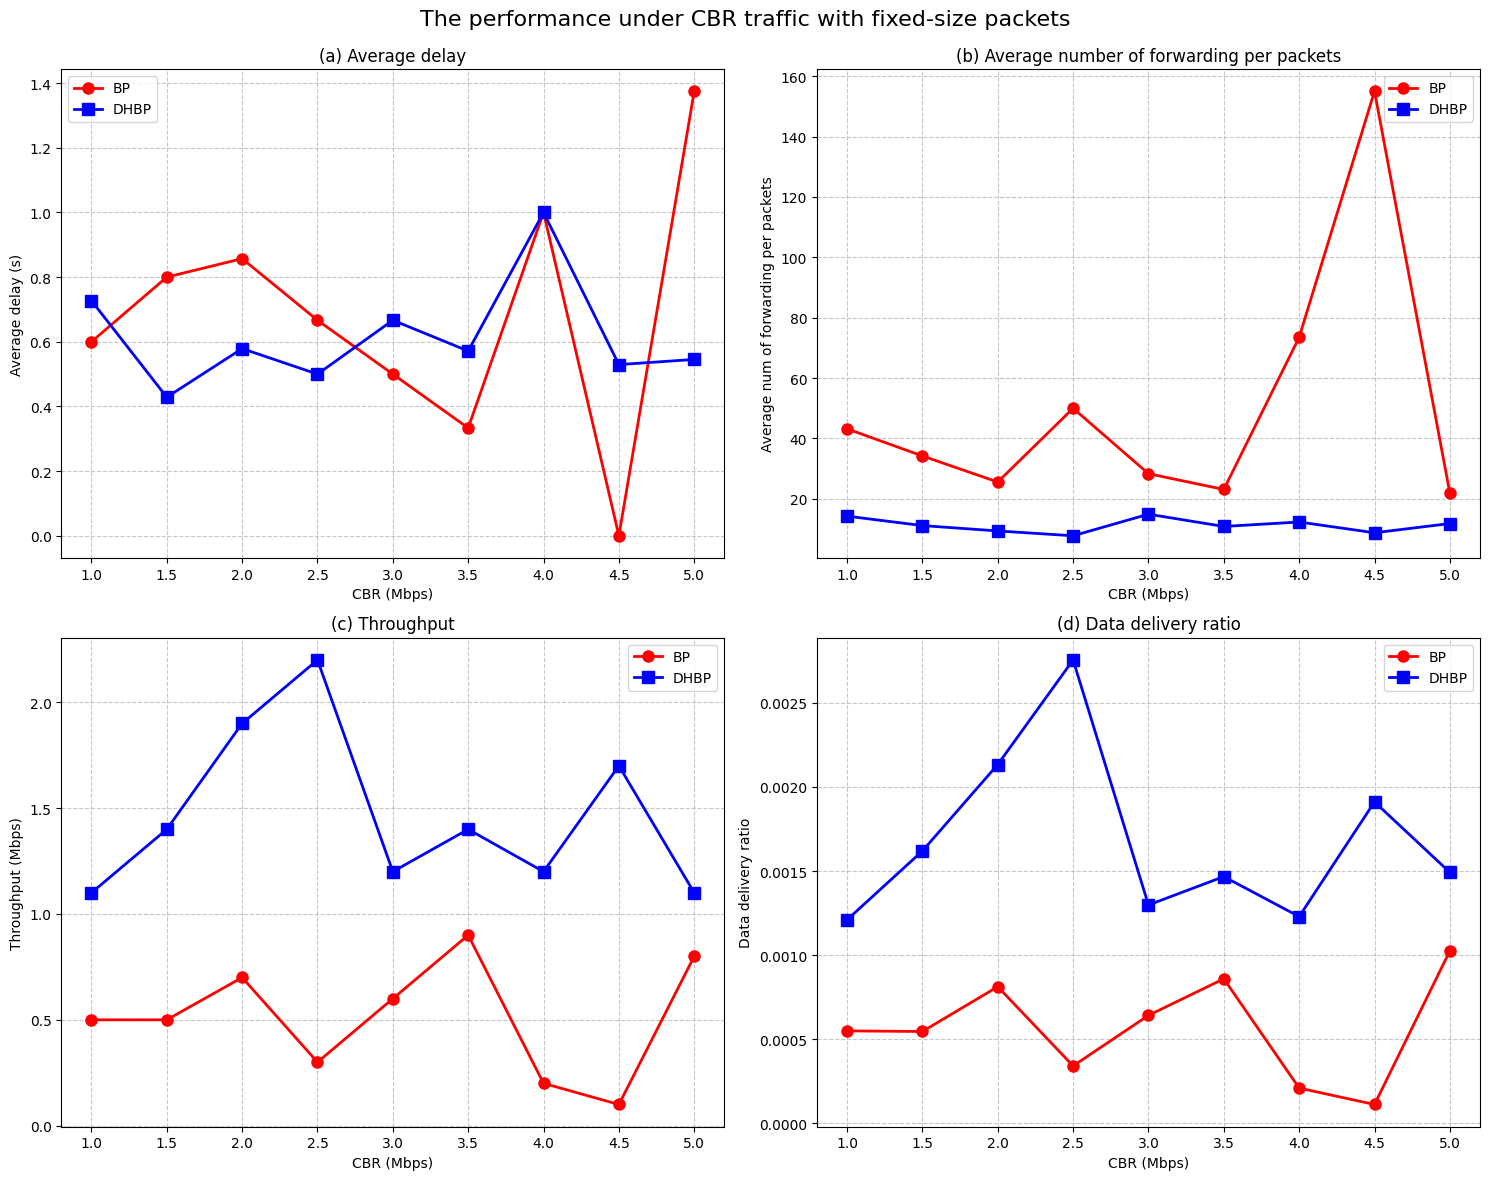

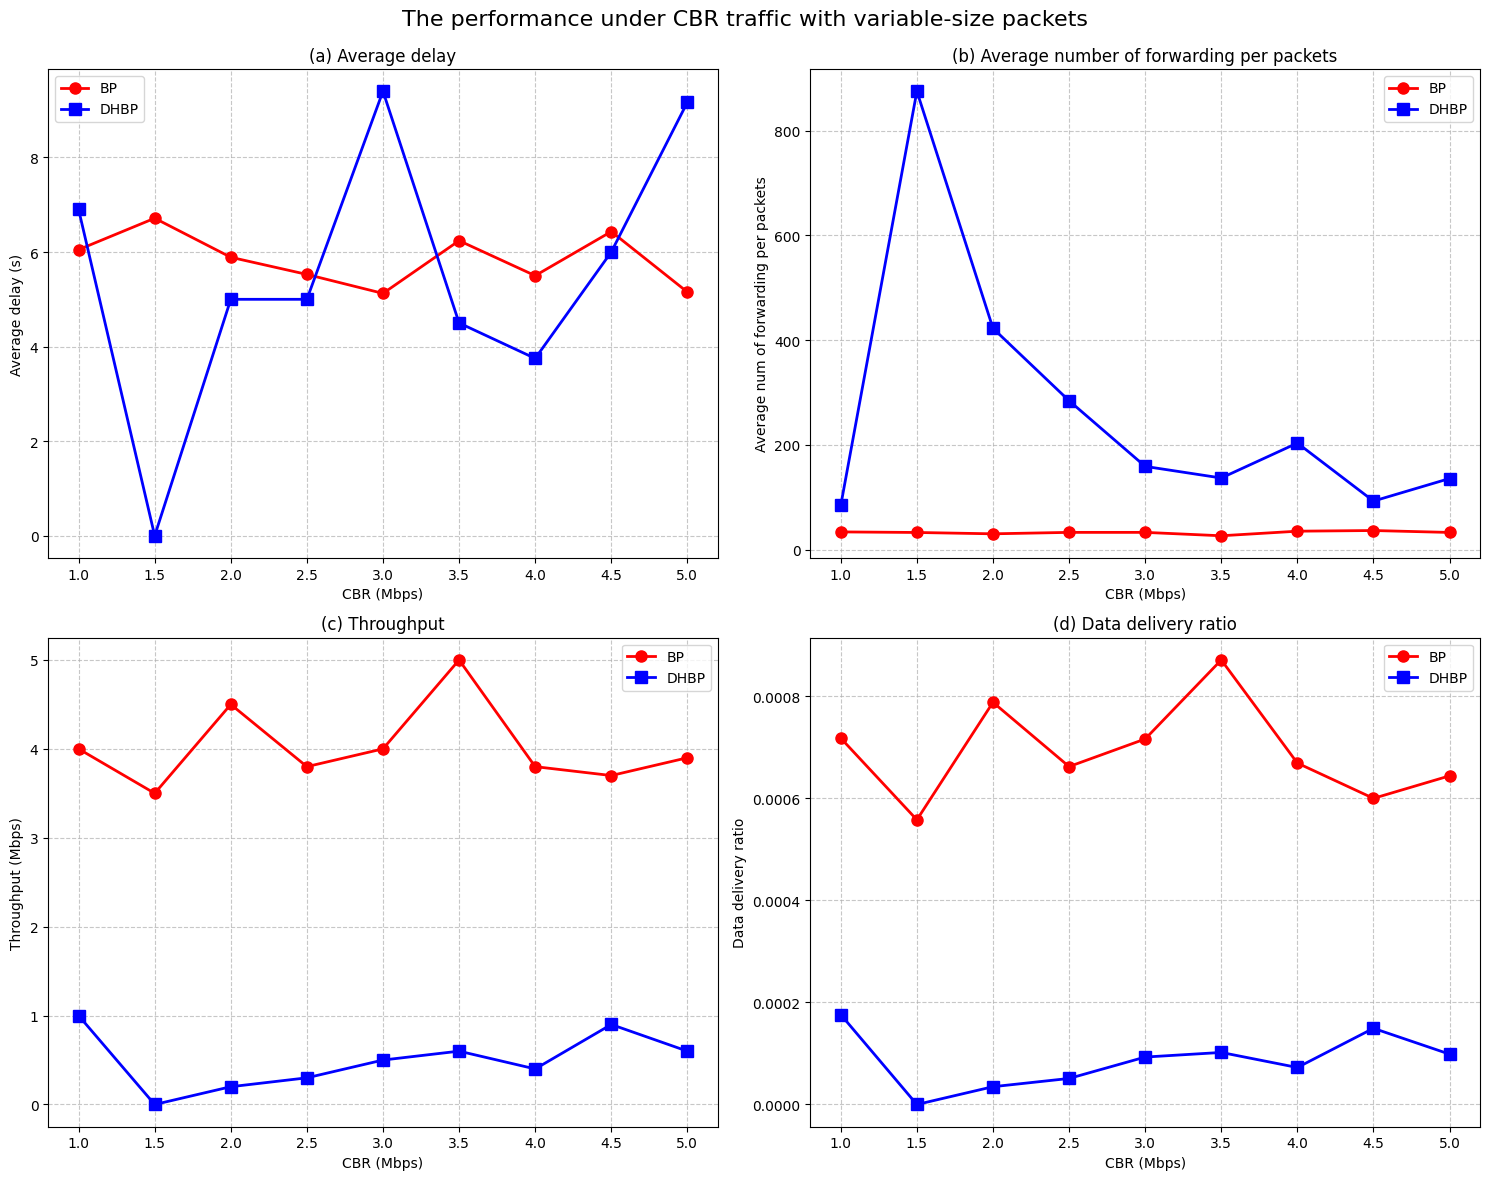

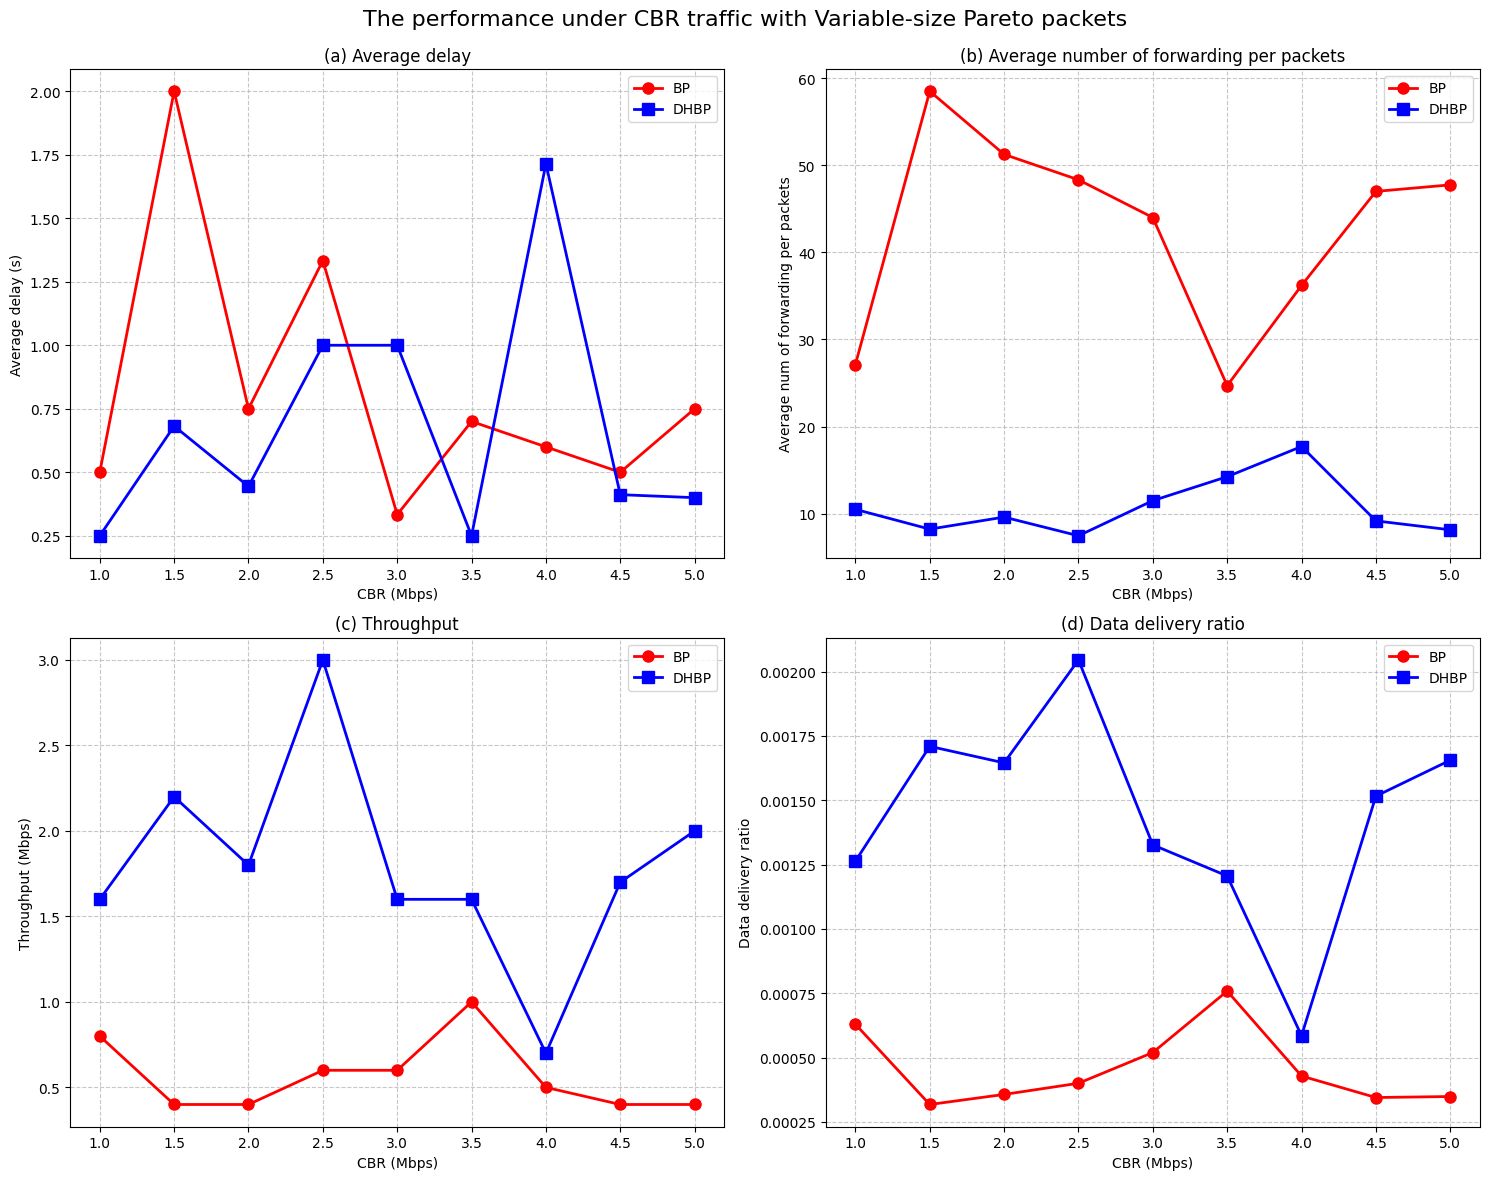

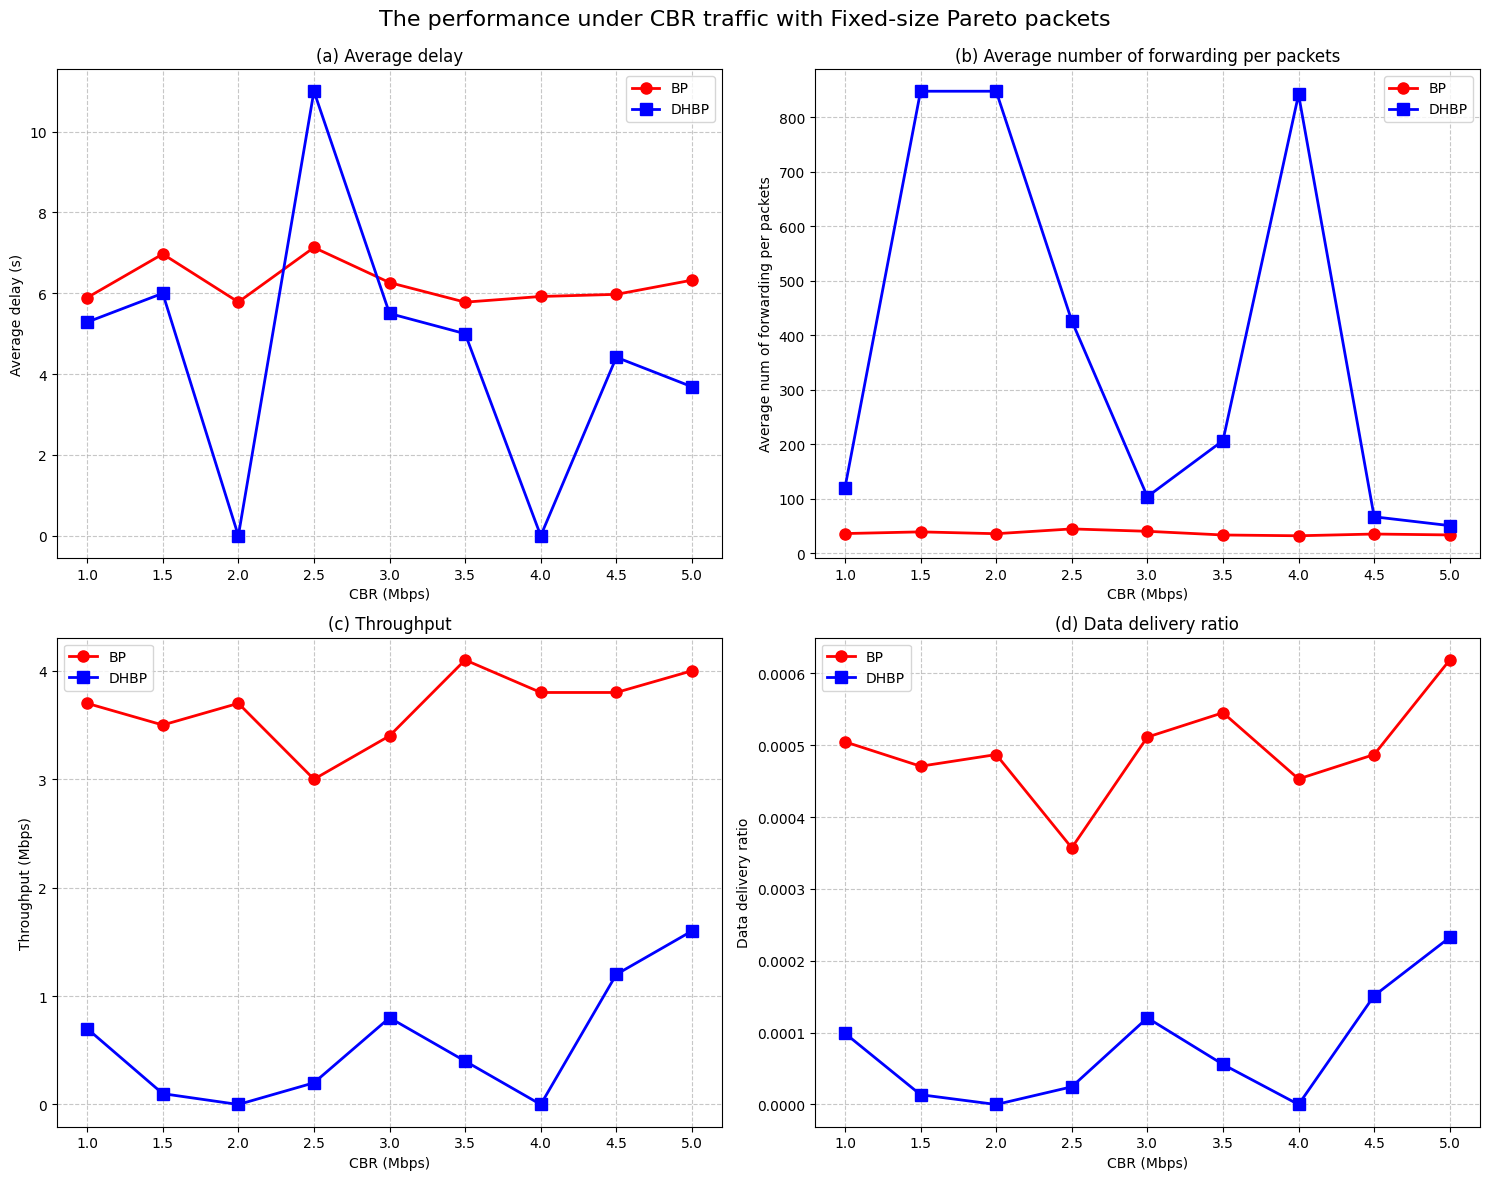

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dhbp_with_broadcast import LEOSatelliteNetwork
import random
import pandas as pd
import seaborn as sns

def run_comparison_with_increasing_traffic(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run a comparison between BP and DHBP with increasing traffic rates"""
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)  # Random target node
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running simulation with traffic rate: {rate} Mbps")

        # Create two identical networks
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        # Set the target node for both networks
        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        # Initialize orbital parameters for realistic hop calculation
        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # Set base traffic rate for all satellites
        for sat in bp_network.satellites:
            # Set shape and scale parameters to control traffic pattern
            sat.shape = random.uniform(1.0, 5.0)  # Pareto shape parameter
            sat.scale = rate  # Use the traffic rate as the scale parameter

        for sat in dhbp_network.satellites:
            # Use the same shape and scale for fair comparison
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second (10 timeslots/second)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def plot_comparison_results(results, packet_type="Variable-size", save_fig=True):
    """Plot comparison graphs similar to the research paper"""
    # Convert results to DataFrame for easier manipulation
    df = pd.DataFrame(results)

    # Create a figure with 4 subplots in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Set custom colors and markers
    bp_style = {'color': 'red', 'marker': 'o', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}
    dhbp_style = {'color': 'blue', 'marker': 's', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}

    # Plot 1: Average Delay
    bp_data = df[df['algorithm'] == 'BP']
    dhbp_data = df[df['algorithm'] == 'DHBP']

    axes[0, 0].plot(bp_data['traffic_rate'], bp_data['avg_delay'], **bp_style, label='BP')
    axes[0, 0].plot(dhbp_data['traffic_rate'], dhbp_data['avg_delay'], **dhbp_style, label='DHBP')
    axes[0, 0].set_xlabel('CBR (Mbps)')
    axes[0, 0].set_ylabel('Average delay (s)')
    axes[0, 0].set_title('(a) Average delay')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Average number of forwarding per packets
    axes[0, 1].plot(bp_data['traffic_rate'], bp_data['avg_forwarding'], **bp_style, label='BP')
    axes[0, 1].plot(dhbp_data['traffic_rate'], dhbp_data['avg_forwarding'], **dhbp_style, label='DHBP')
    axes[0, 1].set_xlabel('CBR (Mbps)')
    axes[0, 1].set_ylabel('Average num of forwarding per packets')
    axes[0, 1].set_title('(b) Average number of forwarding per packets')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Throughput
    axes[1, 0].plot(bp_data['traffic_rate'], bp_data['throughput'], **bp_style, label='BP')
    axes[1, 0].plot(dhbp_data['traffic_rate'], dhbp_data['throughput'], **dhbp_style, label='DHBP')
    axes[1, 0].set_xlabel('CBR (Mbps)')
    axes[1, 0].set_ylabel('Throughput (Mbps)')
    axes[1, 0].set_title('(c) Throughput')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Data delivery ratio
    axes[1, 1].plot(bp_data['traffic_rate'], bp_data['delivery_ratio'], **bp_style, label='BP')
    axes[1, 1].plot(dhbp_data['traffic_rate'], dhbp_data['delivery_ratio'], **dhbp_style, label='DHBP')
    axes[1, 1].set_xlabel('CBR (Mbps)')
    axes[1, 1].set_ylabel('Data delivery ratio')
    axes[1, 1].set_title('(d) Data delivery ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Set overall title
    fig.suptitle(f'The performance under CBR traffic with {packet_type} packets', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    if save_fig:
        plt.savefig(f"bp_dhbp_comparison_{packet_type.lower().replace('-', '_')}.png", dpi=300, bbox_inches='tight')

    return fig


def run_pareto_comparison(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run comparison with Pareto traffic distribution"""
    # Similar to the constant bit rate function but using Pareto distribution
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running Pareto simulation with base traffic rate: {rate} Mbps")

        # Create networks with identical initial settings
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # For Pareto distribution, ensure the shape parameters are set
        for sat in bp_network.satellites:
            # Shape controls the heaviness of the tail - lower values mean more burstiness
            sat.shape = random.uniform(1.0, 7.0)  # More bursty traffic with heavier tails
            sat.scale = rate  # Base rate

        # Ensure DHBP network has the same parameters
        for sat in dhbp_network.satellites:
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def main():
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Parameters for the comparison
    rows = 4
    cols = 5
    steps = 100  # Number of simulation steps
    traffic_rates = np.arange(1.0, 5.1, 0.5)  # From 1.0 to 5.0 Mbps with 0.5 increments

    # Run with variable packet sizes
    print("Running comparison with fixed-size packets and constant bit rate...")
    cbr_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot variable packet size results
    plot_comparison_results(cbr_results, "fixed-size")

    # Run with fixed packet sizes
    print("Running comparison with variable-size packets and constant bit rate...")
    cbr_fixed_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot fixed packet size results
    plot_comparison_results(cbr_fixed_results, "variable-size")

    # Run with Pareto traffic distribution and variable packet sizes
    print("Running comparison with variable-size packets and Pareto traffic...")
    pareto_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot Pareto with variable packet size results
    plot_comparison_results(pareto_results, "Variable-size Pareto", save_fig=True)

    # Run with Pareto traffic distribution and fixed packet sizes
    print("Running comparison with fixed-size packets and Pareto traffic...")
    pareto_fixed_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot Pareto with fixed packet size results
    plot_comparison_results(pareto_fixed_results, "Fixed-size Pareto", save_fig=True)

    print("All simulations and plots complete.")
    plt.show()


if __name__ == "__main__":
    main()

Running comparison with fixed-size packets and constant bit rate...
Using target node: 4
Running simulation with traffic rate: 1.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 1.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop

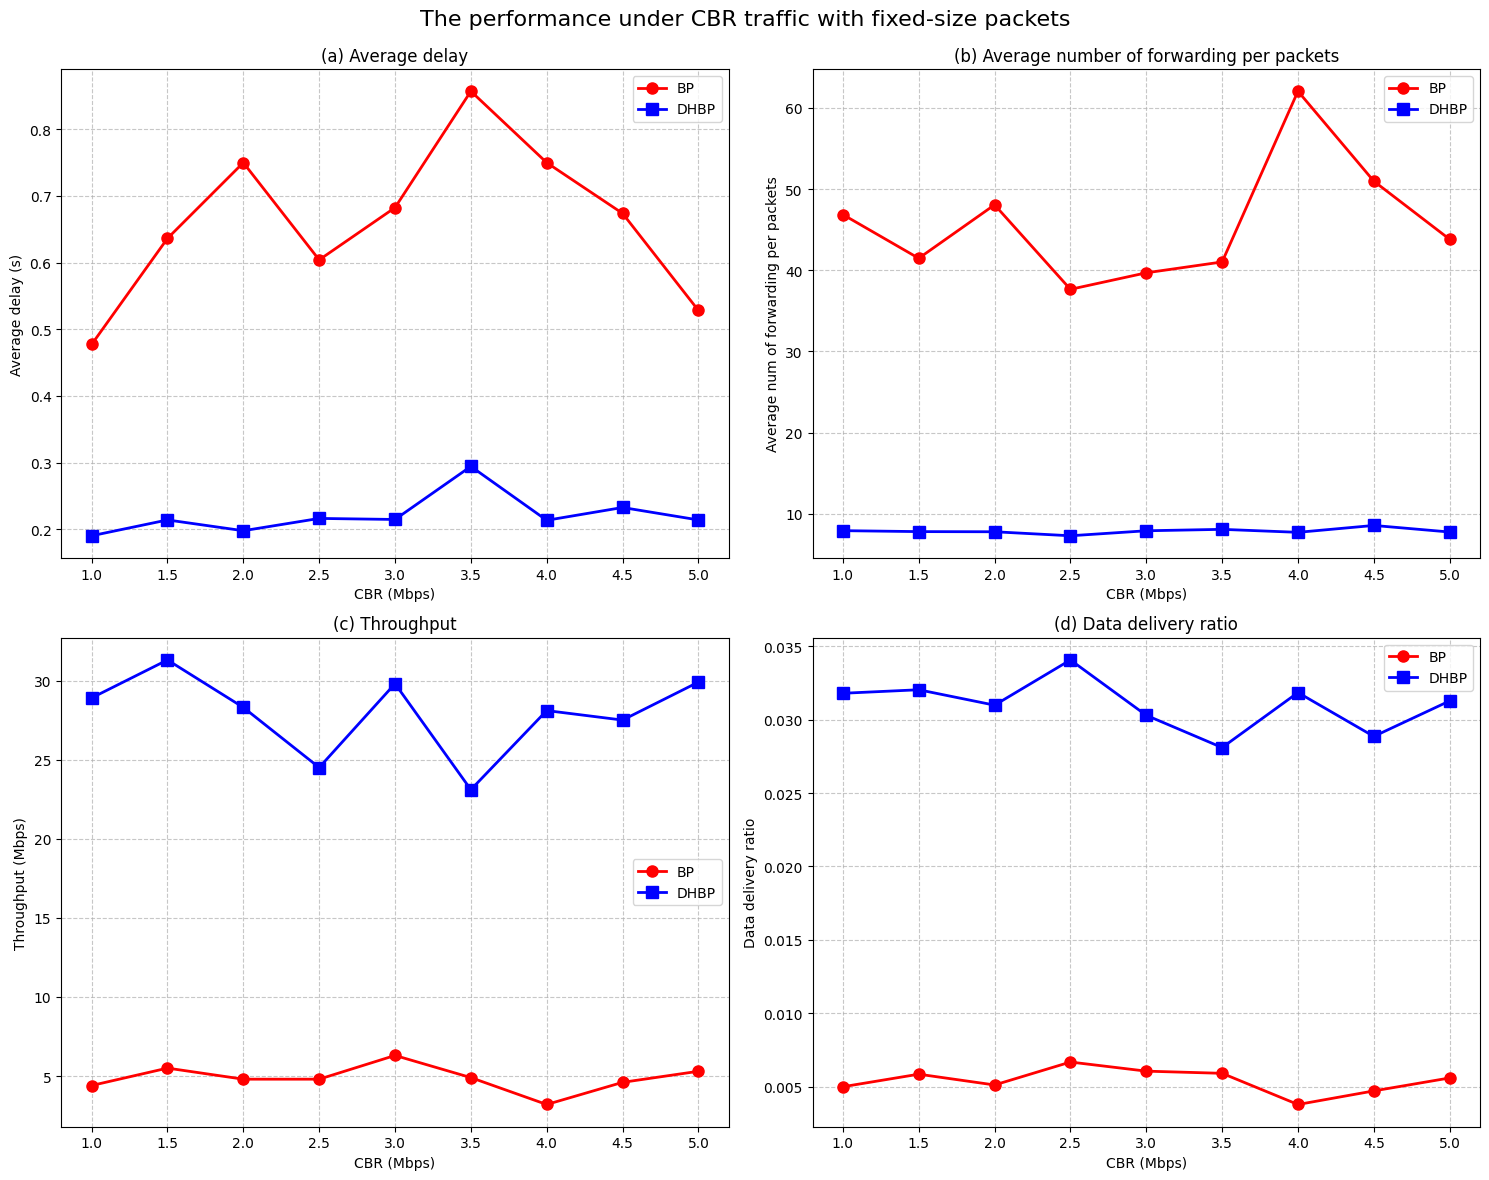

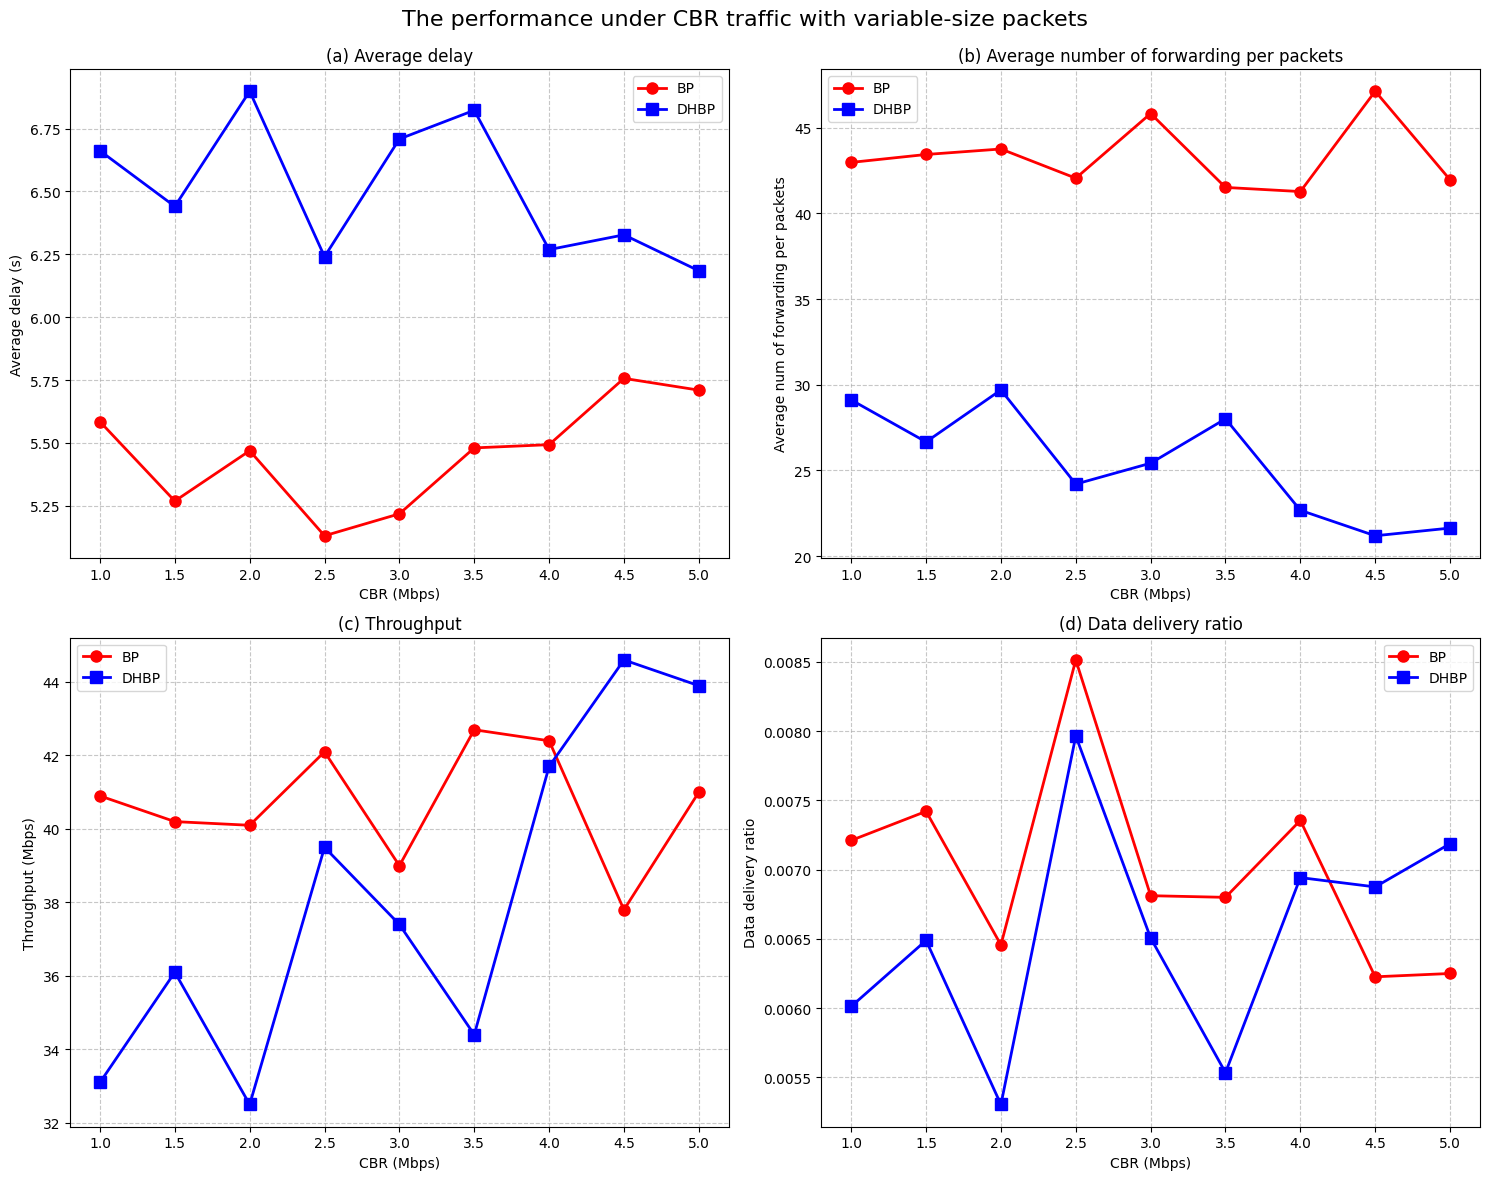

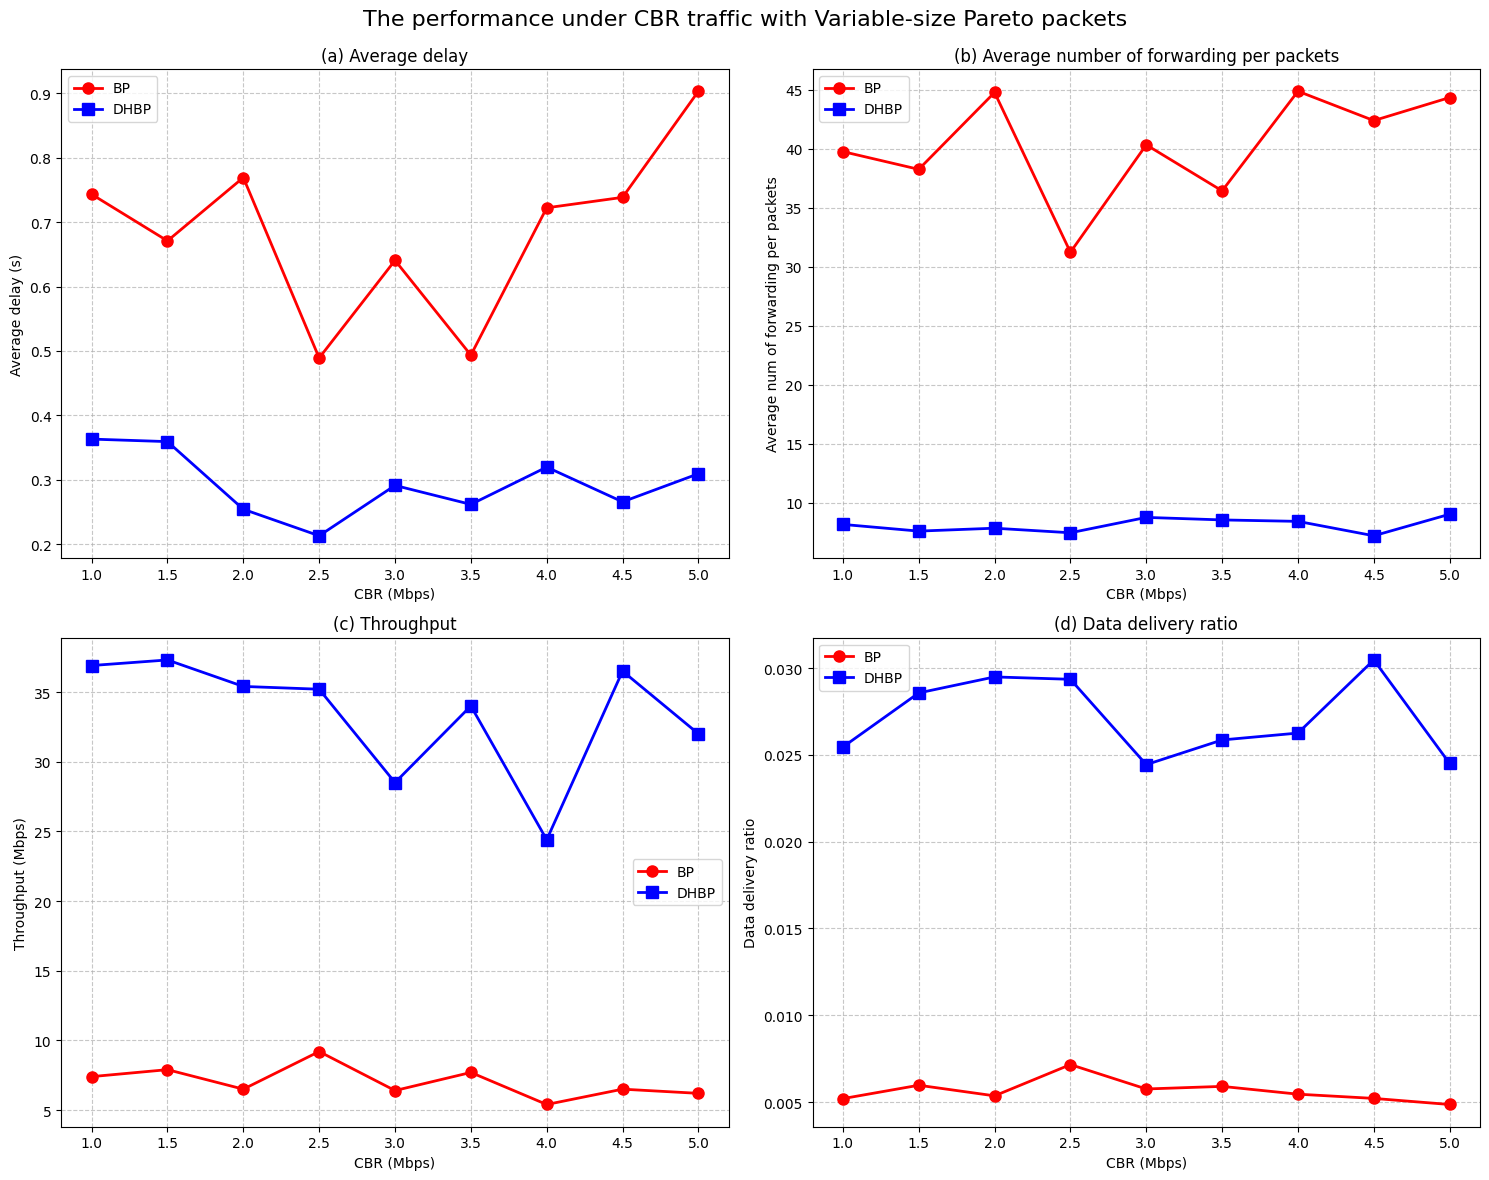

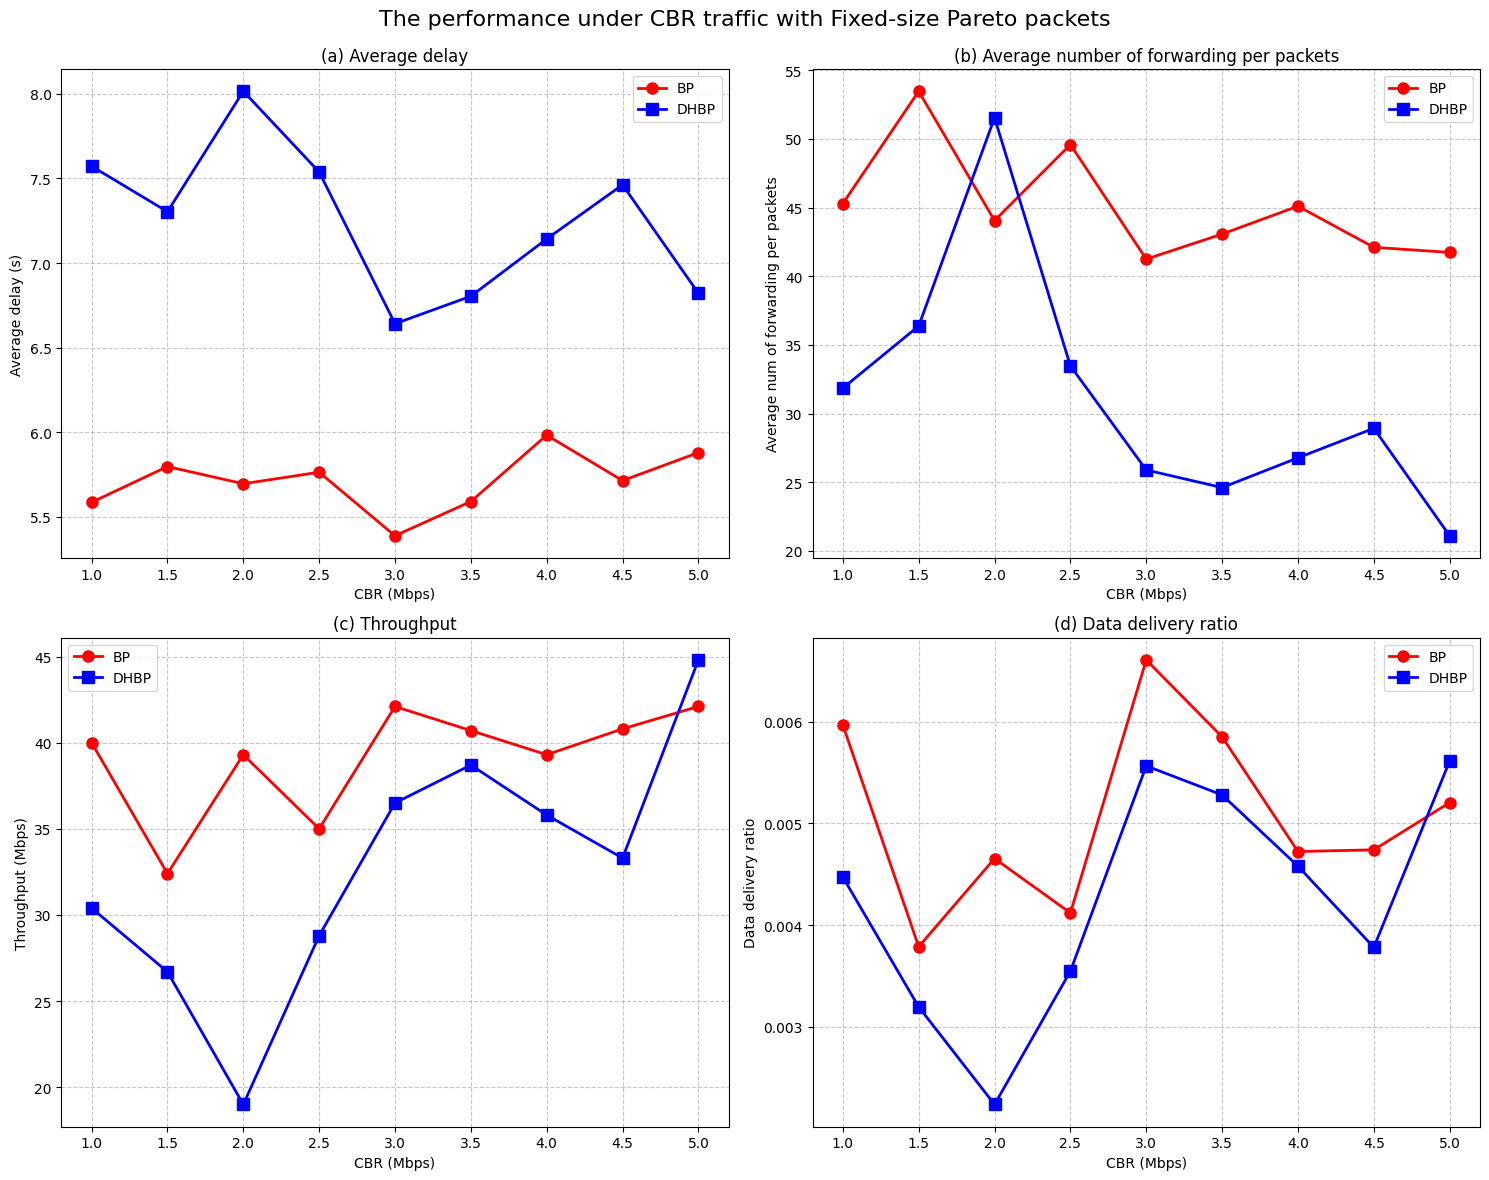

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from final_trail_without_broadcast import LEOSatelliteNetwork
import random
import pandas as pd
import seaborn as sns

def run_comparison_with_increasing_traffic(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run a comparison between BP and DHBP with increasing traffic rates"""
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)  # Random target node
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running simulation with traffic rate: {rate} Mbps")

        # Create two identical networks
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        # Set the target node for both networks
        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        # Initialize orbital parameters for realistic hop calculation
        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # Set base traffic rate for all satellites
        for sat in bp_network.satellites:
            # Set shape and scale parameters to control traffic pattern
            sat.shape = random.uniform(1.0, 5.0)  # Pareto shape parameter
            sat.scale = rate  # Use the traffic rate as the scale parameter

        for sat in dhbp_network.satellites:
            # Use the same shape and scale for fair comparison
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second (10 timeslots/second)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def plot_comparison_results(results, packet_type="Variable-size", save_fig=True):
    """Plot comparison graphs similar to the research paper"""
    # Convert results to DataFrame for easier manipulation
    df = pd.DataFrame(results)

    # Create a figure with 4 subplots in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Set custom colors and markers
    bp_style = {'color': 'red', 'marker': 'o', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}
    dhbp_style = {'color': 'blue', 'marker': 's', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}

    # Plot 1: Average Delay
    bp_data = df[df['algorithm'] == 'BP']
    dhbp_data = df[df['algorithm'] == 'DHBP']

    axes[0, 0].plot(bp_data['traffic_rate'], bp_data['avg_delay'], **bp_style, label='BP')
    axes[0, 0].plot(dhbp_data['traffic_rate'], dhbp_data['avg_delay'], **dhbp_style, label='DHBP')
    axes[0, 0].set_xlabel('CBR (Mbps)')
    axes[0, 0].set_ylabel('Average delay (s)')
    axes[0, 0].set_title('(a) Average delay')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Average number of forwarding per packets
    axes[0, 1].plot(bp_data['traffic_rate'], bp_data['avg_forwarding'], **bp_style, label='BP')
    axes[0, 1].plot(dhbp_data['traffic_rate'], dhbp_data['avg_forwarding'], **dhbp_style, label='DHBP')
    axes[0, 1].set_xlabel('CBR (Mbps)')
    axes[0, 1].set_ylabel('Average num of forwarding per packets')
    axes[0, 1].set_title('(b) Average number of forwarding per packets')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Throughput
    axes[1, 0].plot(bp_data['traffic_rate'], bp_data['throughput'], **bp_style, label='BP')
    axes[1, 0].plot(dhbp_data['traffic_rate'], dhbp_data['throughput'], **dhbp_style, label='DHBP')
    axes[1, 0].set_xlabel('CBR (Mbps)')
    axes[1, 0].set_ylabel('Throughput (Mbps)')
    axes[1, 0].set_title('(c) Throughput')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Data delivery ratio
    axes[1, 1].plot(bp_data['traffic_rate'], bp_data['delivery_ratio'], **bp_style, label='BP')
    axes[1, 1].plot(dhbp_data['traffic_rate'], dhbp_data['delivery_ratio'], **dhbp_style, label='DHBP')
    axes[1, 1].set_xlabel('CBR (Mbps)')
    axes[1, 1].set_ylabel('Data delivery ratio')
    axes[1, 1].set_title('(d) Data delivery ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Set overall title
    fig.suptitle(f'The performance under CBR traffic with {packet_type} packets', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    if save_fig:
        plt.savefig(f"bp_dhbp_comparison_{packet_type.lower().replace('-', '_')}.png", dpi=300, bbox_inches='tight')

    return fig


def run_pareto_comparison(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run comparison with Pareto traffic distribution"""
    # Similar to the constant bit rate function but using Pareto distribution
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running Pareto simulation with base traffic rate: {rate} Mbps")

        # Create networks with identical initial settings
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # For Pareto distribution, ensure the shape parameters are set
        for sat in bp_network.satellites:
            # Shape controls the heaviness of the tail - lower values mean more burstiness
            sat.shape = random.uniform(1.0, 7.0)  # More bursty traffic with heavier tails
            sat.scale = rate  # Base rate

        # Ensure DHBP network has the same parameters
        for sat in dhbp_network.satellites:
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def main():
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Parameters for the comparison
    rows = 4
    cols = 5
    steps = 100  # Number of simulation steps
    traffic_rates = np.arange(1.0, 5.1, 0.5)  # From 1.0 to 5.0 Mbps with 0.5 increments

    # Run with variable packet sizes
    print("Running comparison with fixed-size packets and constant bit rate...")
    cbr_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot variable packet size results
    plot_comparison_results(cbr_results, "fixed-size")

    # Run with fixed packet sizes
    print("Running comparison with variable-size packets and constant bit rate...")
    cbr_fixed_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot fixed packet size results
    plot_comparison_results(cbr_fixed_results, "variable-size")

    # Run with Pareto traffic distribution and variable packet sizes
    print("Running comparison with variable-size packets and Pareto traffic...")
    pareto_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot Pareto with variable packet size results
    plot_comparison_results(pareto_results, "Variable-size Pareto", save_fig=True)

    # Run with Pareto traffic distribution and fixed packet sizes
    print("Running comparison with fixed-size packets and Pareto traffic...")
    pareto_fixed_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot Pareto with fixed packet size results
    plot_comparison_results(pareto_fixed_results, "Fixed-size Pareto", save_fig=True)

    print("All simulations and plots complete.")
    plt.show()


if __name__ == "__main__":
    main()

Running comparison with fixed-size packets and constant bit rate...
Using target node: 4
Running simulation with traffic rate: 1.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 1.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.0 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop calculation
Running simulation with traffic rate: 2.5 Mbps
Target node set to Satellite 4
Target node set to Satellite 4
Orbital parameters initialized for realistic hop calculation
Orbital parameters initialized for realistic hop

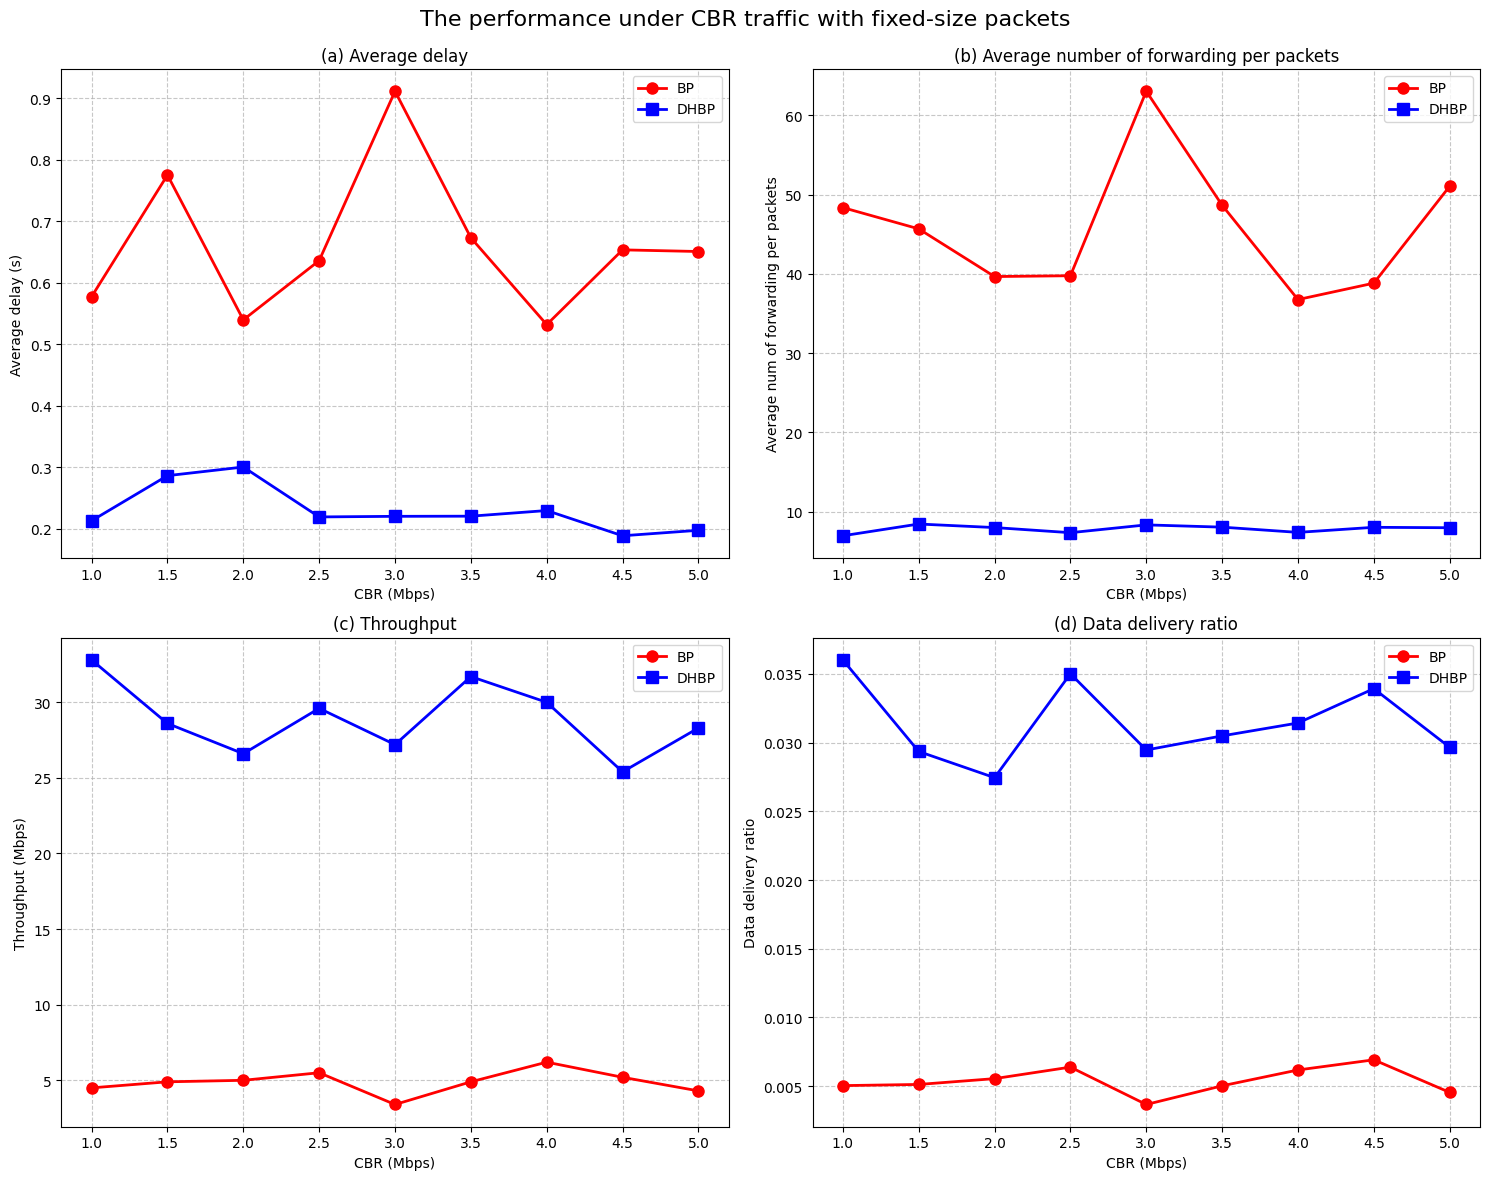

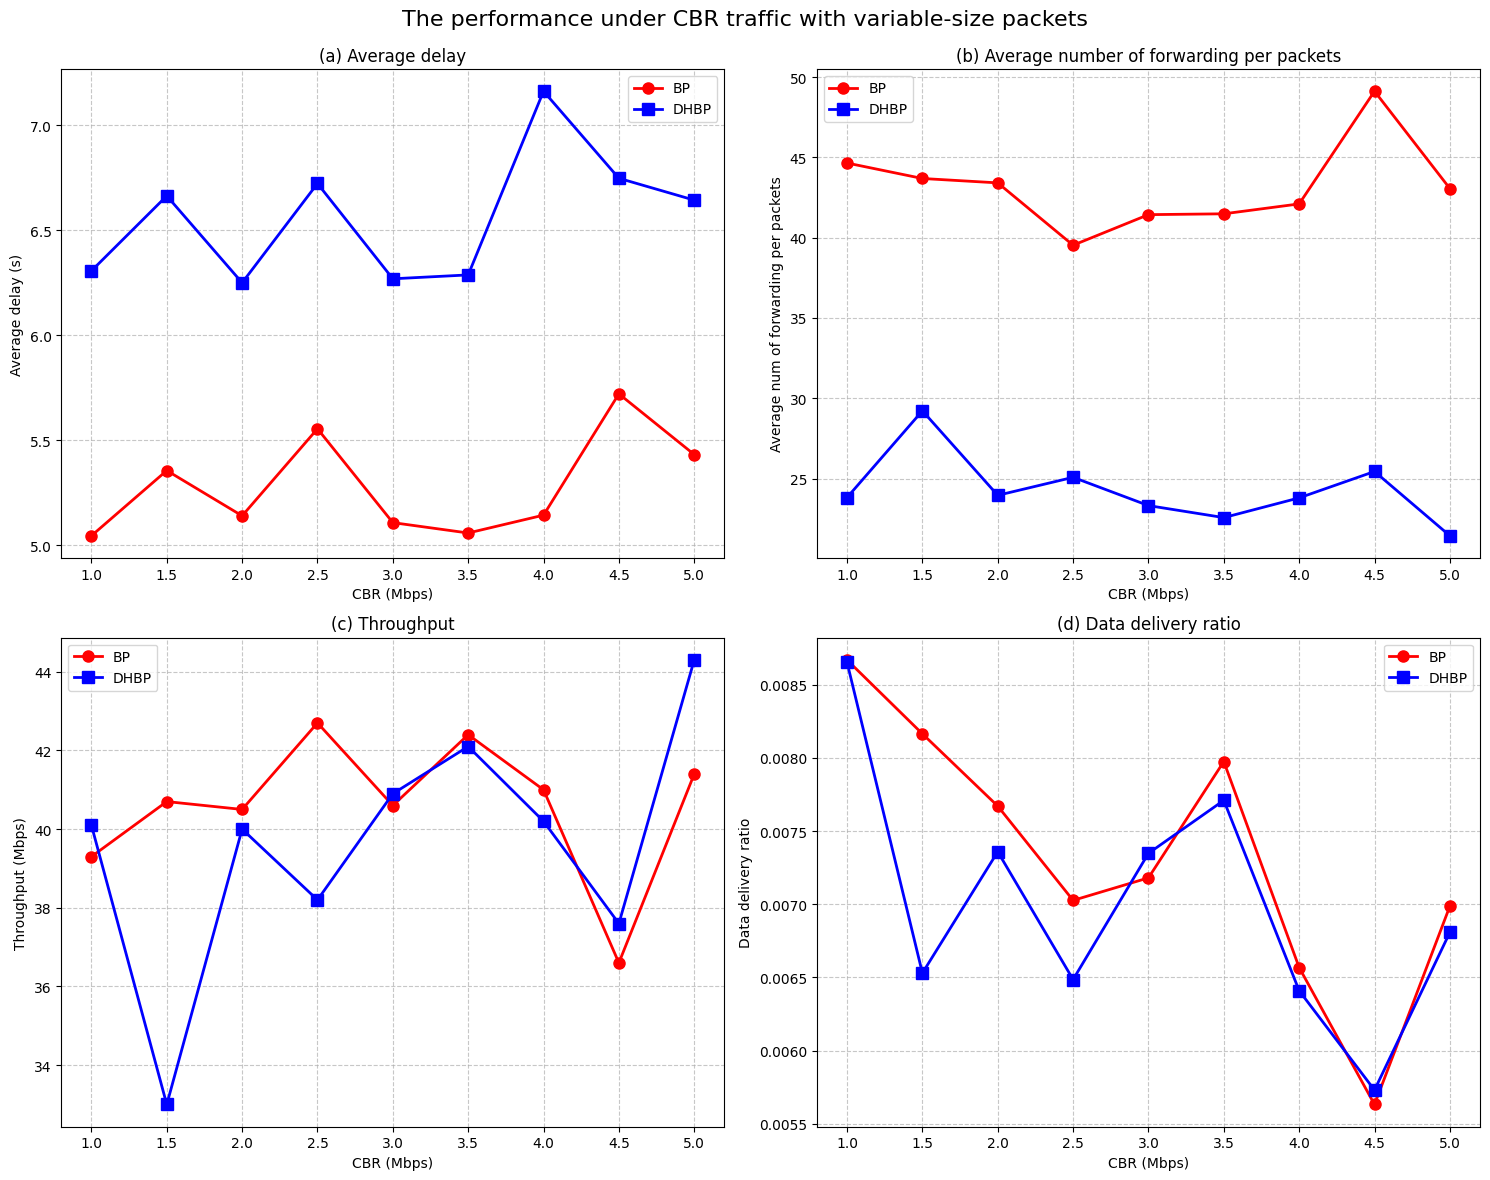

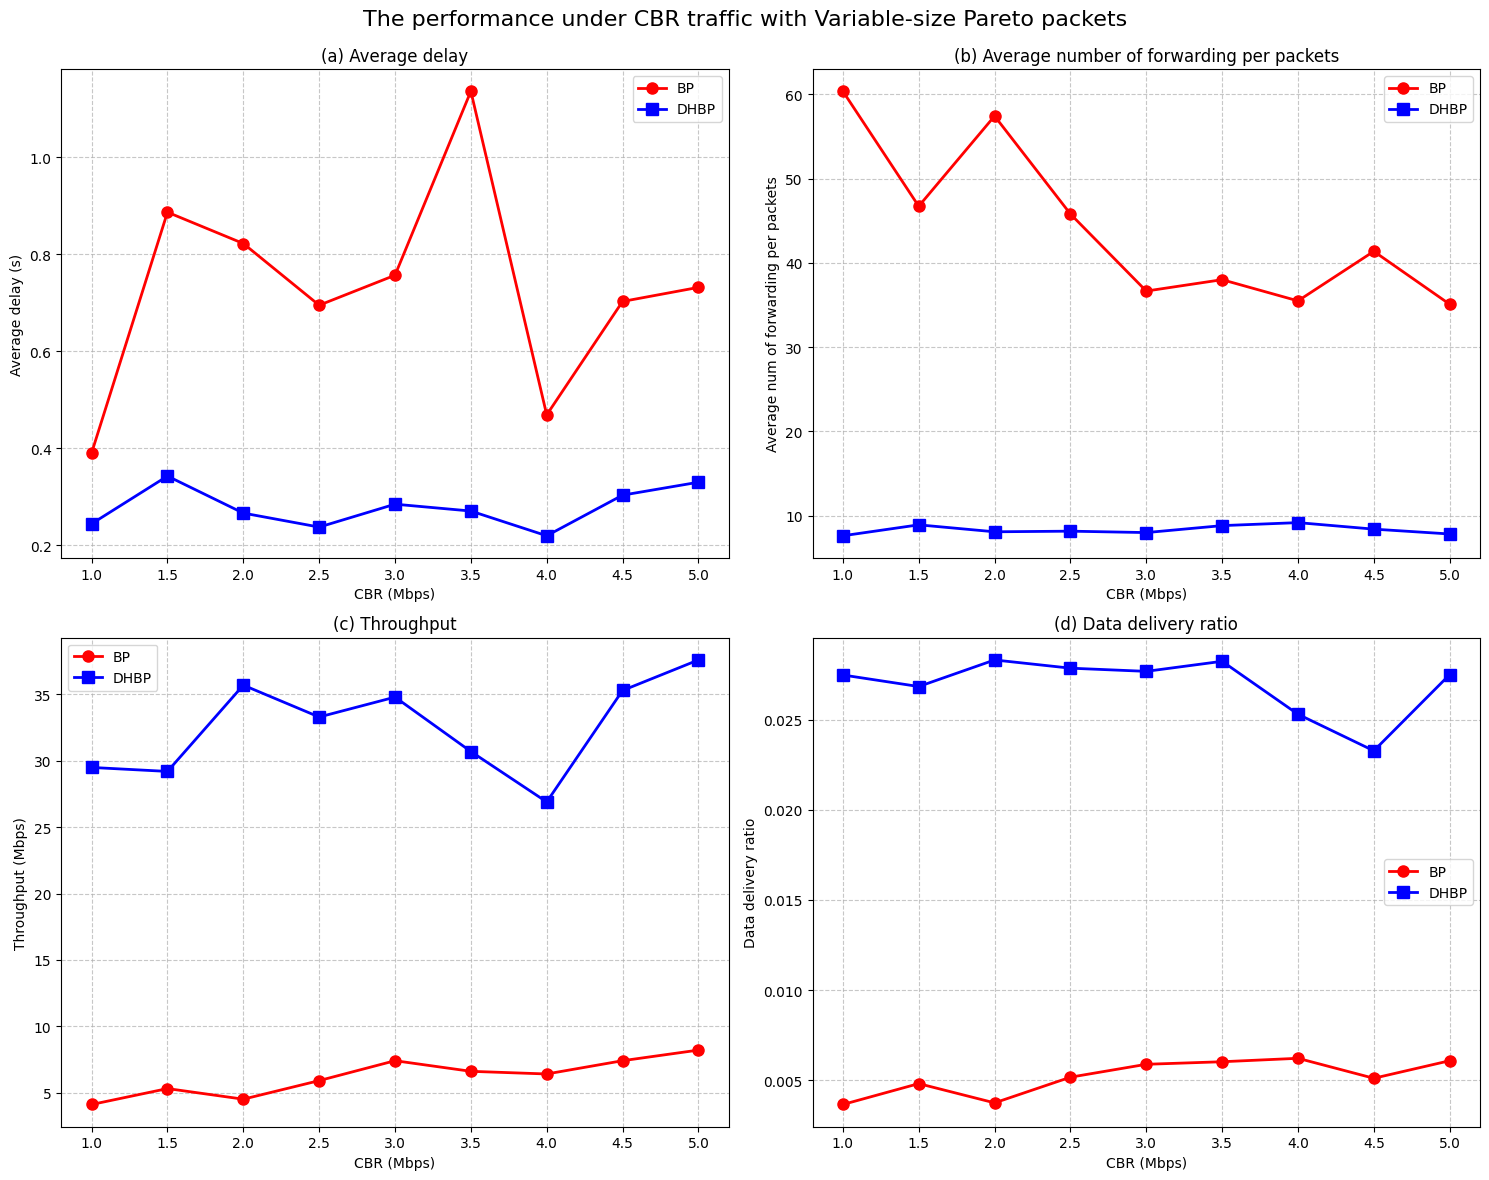

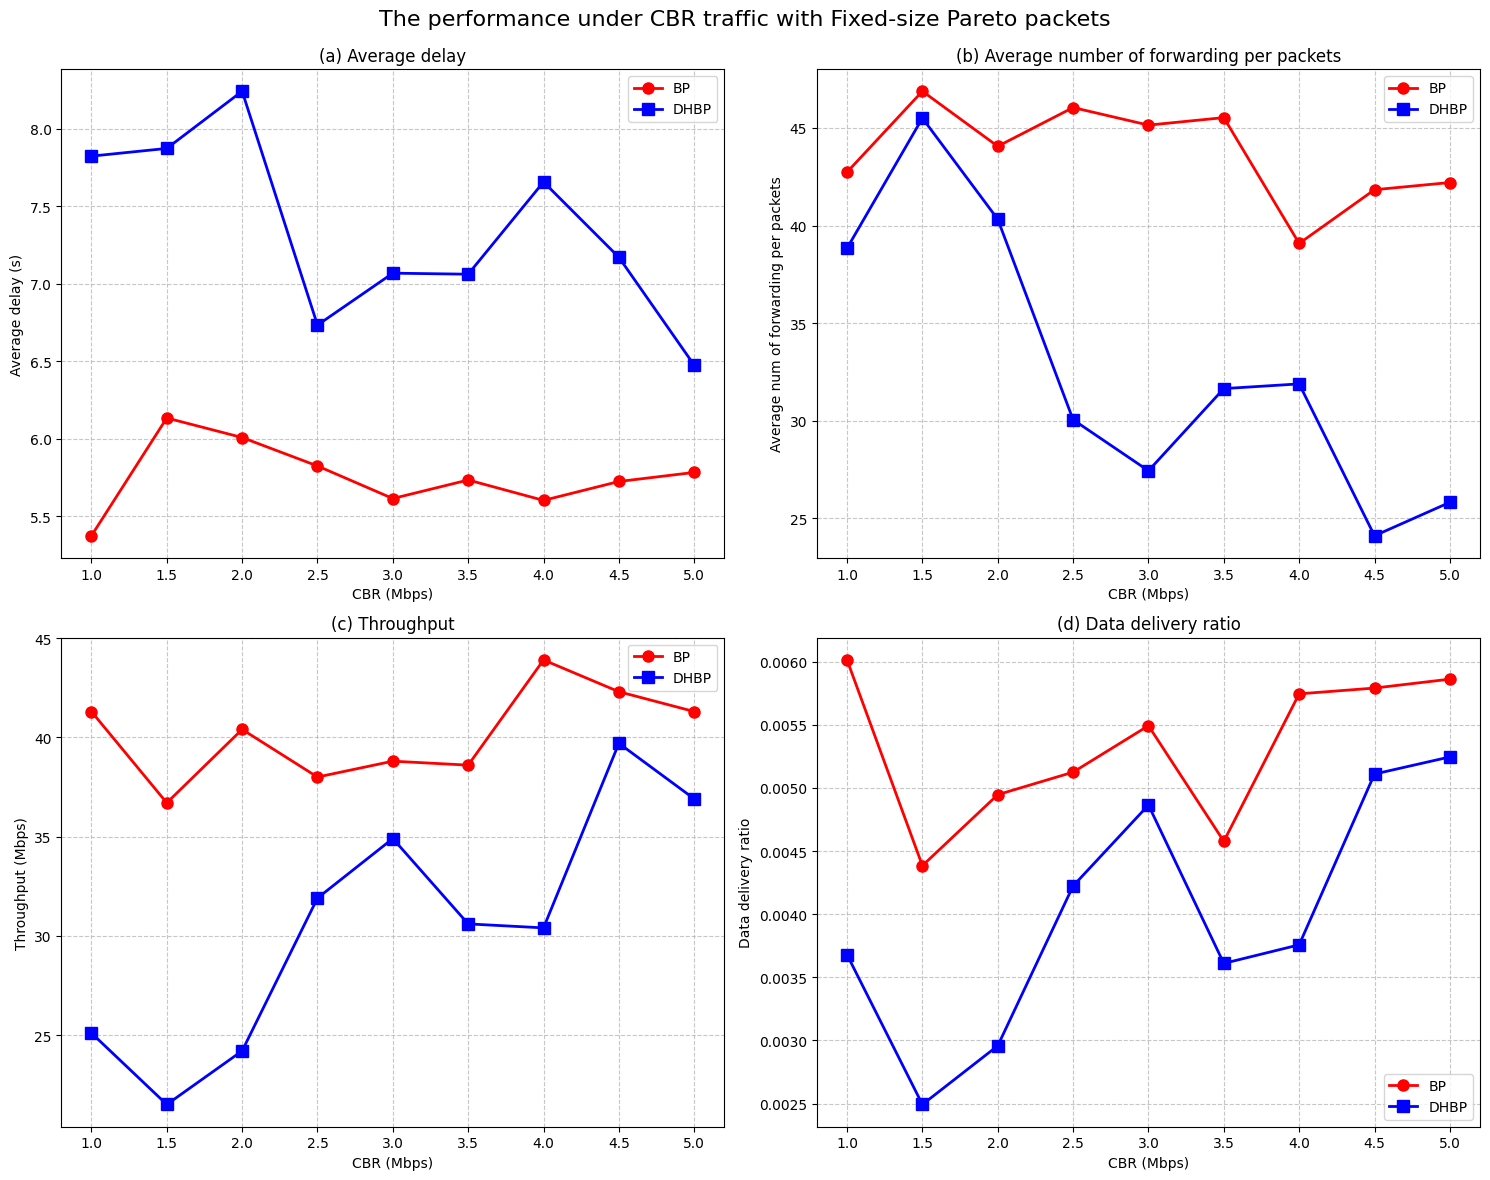

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from with_arima6 import LEOSatelliteNetwork
import random
import pandas as pd
import seaborn as sns

def run_comparison_with_increasing_traffic(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run a comparison between BP and DHBP with increasing traffic rates"""
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)  # Random target node
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running simulation with traffic rate: {rate} Mbps")

        # Create two identical networks
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        # Set the target node for both networks
        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        # Initialize orbital parameters for realistic hop calculation
        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # Set base traffic rate for all satellites
        for sat in bp_network.satellites:
            # Set shape and scale parameters to control traffic pattern
            sat.shape = random.uniform(1.0, 5.0)  # Pareto shape parameter
            sat.scale = rate  # Use the traffic rate as the scale parameter

        for sat in dhbp_network.satellites:
            # Use the same shape and scale for fair comparison
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second (10 timeslots/second)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)  # Packets per second
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def plot_comparison_results(results, packet_type="Variable-size", save_fig=True):
    """Plot comparison graphs similar to the research paper"""
    # Convert results to DataFrame for easier manipulation
    df = pd.DataFrame(results)

    # Create a figure with 4 subplots in a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Set custom colors and markers
    bp_style = {'color': 'red', 'marker': 'o', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}
    dhbp_style = {'color': 'blue', 'marker': 's', 'linestyle': '-', 'linewidth': 2, 'markersize': 8}

    # Plot 1: Average Delay
    bp_data = df[df['algorithm'] == 'BP']
    dhbp_data = df[df['algorithm'] == 'DHBP']

    axes[0, 0].plot(bp_data['traffic_rate'], bp_data['avg_delay'], **bp_style, label='BP')
    axes[0, 0].plot(dhbp_data['traffic_rate'], dhbp_data['avg_delay'], **dhbp_style, label='DHBP')
    axes[0, 0].set_xlabel('CBR (Mbps)')
    axes[0, 0].set_ylabel('Average delay (s)')
    axes[0, 0].set_title('(a) Average delay')
    axes[0, 0].legend()
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 2: Average number of forwarding per packets
    axes[0, 1].plot(bp_data['traffic_rate'], bp_data['avg_forwarding'], **bp_style, label='BP')
    axes[0, 1].plot(dhbp_data['traffic_rate'], dhbp_data['avg_forwarding'], **dhbp_style, label='DHBP')
    axes[0, 1].set_xlabel('CBR (Mbps)')
    axes[0, 1].set_ylabel('Average num of forwarding per packets')
    axes[0, 1].set_title('(b) Average number of forwarding per packets')
    axes[0, 1].legend()
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)

    # Plot 3: Throughput
    axes[1, 0].plot(bp_data['traffic_rate'], bp_data['throughput'], **bp_style, label='BP')
    axes[1, 0].plot(dhbp_data['traffic_rate'], dhbp_data['throughput'], **dhbp_style, label='DHBP')
    axes[1, 0].set_xlabel('CBR (Mbps)')
    axes[1, 0].set_ylabel('Throughput (Mbps)')
    axes[1, 0].set_title('(c) Throughput')
    axes[1, 0].legend()
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)

    # Plot 4: Data delivery ratio
    axes[1, 1].plot(bp_data['traffic_rate'], bp_data['delivery_ratio'], **bp_style, label='BP')
    axes[1, 1].plot(dhbp_data['traffic_rate'], dhbp_data['delivery_ratio'], **dhbp_style, label='DHBP')
    axes[1, 1].set_xlabel('CBR (Mbps)')
    axes[1, 1].set_ylabel('Data delivery ratio')
    axes[1, 1].set_title('(d) Data delivery ratio')
    axes[1, 1].legend()
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)

    # Set overall title
    fig.suptitle(f'The performance under CBR traffic with {packet_type} packets', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    if save_fig:
        plt.savefig(f"bp_dhbp_comparison_{packet_type.lower().replace('-', '_')}.png", dpi=300, bbox_inches='tight')

    return fig


def run_pareto_comparison(rows=4, cols=5, steps=100, traffic_rates=None, use_fixed_size=False):
    """Run comparison with Pareto traffic distribution"""
    # Similar to the constant bit rate function but using Pareto distribution
    if traffic_rates is None:
        traffic_rates = np.arange(0.5, 5.1, 0.5)  # From 0.5 to 5.0 Mbps with 0.5 increments

    results = {
        'traffic_rate': [],
        'algorithm': [],
        'delivered_packets': [],
        'dropped_packets': [],
        'avg_delay': [],
        'throughput': [],
        'delivery_ratio': [],
        'avg_forwarding': []
    }

    target_node = random.randint(1, rows * cols)
    print(f"Using target node: {target_node}")

    for rate in traffic_rates:
        print(f"Running Pareto simulation with base traffic rate: {rate} Mbps")

        # Create networks with identical initial settings
        bp_network = LEOSatelliteNetwork(rows=rows, cols=cols)
        dhbp_network = LEOSatelliteNetwork(rows=rows, cols=cols)

        bp_network.set_target_node(target_node)
        dhbp_network.set_target_node(target_node)

        bp_network.initialize_orbital_parameters()
        dhbp_network.initialize_orbital_parameters()

        # For Pareto distribution, ensure the shape parameters are set
        for sat in bp_network.satellites:
            # Shape controls the heaviness of the tail - lower values mean more burstiness
            sat.shape = random.uniform(1.0, 7.0)  # More bursty traffic with heavier tails
            sat.scale = rate  # Base rate

        # Ensure DHBP network has the same parameters
        for sat in dhbp_network.satellites:
            sat.shape = bp_network.satellites[sat.id-1].shape
            sat.scale = bp_network.satellites[sat.id-1].scale

        # Run simulations
        bp_network.run_simulation(steps=steps, use_dhbp=False, use_fixed_size=use_fixed_size)
        dhbp_network.run_simulation(steps=steps, use_dhbp=True, use_fixed_size=use_fixed_size)

        # Calculate average forwarding for BP
        bp_total_forwarded = sum(sat.packets_forwarded for sat in bp_network.satellites)
        bp_avg_forwarding = bp_total_forwarded / max(1, bp_network.simulation_stats['delivered_packets'])

        # Calculate average forwarding for DHBP
        dhbp_total_forwarded = sum(sat.packets_forwarded for sat in dhbp_network.satellites)
        dhbp_avg_forwarding = dhbp_total_forwarded / max(1, dhbp_network.simulation_stats['delivered_packets'])

        # Collect BP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('BP')
        results['delivered_packets'].append(bp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(bp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(bp_network.simulation_stats['avg_delay'])
        results['throughput'].append(bp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_bp = bp_network.simulation_stats['delivered_packets'] + bp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(bp_network.simulation_stats['delivered_packets'] / max(1, total_bp))
        results['avg_forwarding'].append(bp_avg_forwarding)

        # Collect DHBP results
        results['traffic_rate'].append(rate)
        results['algorithm'].append('DHBP')
        results['delivered_packets'].append(dhbp_network.simulation_stats['delivered_packets'])
        results['dropped_packets'].append(dhbp_network.simulation_stats['dropped_packets'])
        results['avg_delay'].append(dhbp_network.simulation_stats['avg_delay'])
        results['throughput'].append(dhbp_network.simulation_stats['delivered_packets'] / steps * 10)
        total_dhbp = dhbp_network.simulation_stats['delivered_packets'] + dhbp_network.simulation_stats['dropped_packets']
        results['delivery_ratio'].append(dhbp_network.simulation_stats['delivered_packets'] / max(1, total_dhbp))
        results['avg_forwarding'].append(dhbp_avg_forwarding)

    return results


def main():
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Parameters for the comparison
    rows = 4
    cols = 5
    steps = 100  # Number of simulation steps
    traffic_rates = np.arange(1.0, 5.1, 0.5)  # From 1.0 to 5.0 Mbps with 0.5 increments

    # Run with variable packet sizes
    print("Running comparison with fixed-size packets and constant bit rate...")
    cbr_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot variable packet size results
    plot_comparison_results(cbr_results, "fixed-size")

    # Run with fixed packet sizes
    print("Running comparison with variable-size packets and constant bit rate...")
    cbr_fixed_results = run_comparison_with_increasing_traffic(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot fixed packet size results
    plot_comparison_results(cbr_fixed_results, "variable-size")

    # Run with Pareto traffic distribution and variable packet sizes
    print("Running comparison with variable-size packets and Pareto traffic...")
    pareto_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=False
    )

    # Plot Pareto with variable packet size results
    plot_comparison_results(pareto_results, "Variable-size Pareto", save_fig=True)

    # Run with Pareto traffic distribution and fixed packet sizes
    print("Running comparison with fixed-size packets and Pareto traffic...")
    pareto_fixed_results = run_pareto_comparison(
        rows=rows, cols=cols, steps=steps, traffic_rates=traffic_rates, use_fixed_size=True
    )

    # Plot Pareto with fixed packet size results
    plot_comparison_results(pareto_fixed_results, "Fixed-size Pareto", save_fig=True)

    print("All simulations and plots complete.")
    plt.show()


if __name__ == "__main__":
    main()